<a href="https://colab.research.google.com/github/idanHur/-House-Prices---Advanced-Regression-Techniques-kaggle-competition/blob/main/Idan_Hur_House_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Idan Hur**



https://www.kaggle.com/idanhur

# TL;DR
In this exercise i will try to solve the Kaggle contest "House Prices - Advanced Regression Techniques" 

i will need to predict house prices in Ames, Iowa, according to vast variety of 80 features.

In order to do that i will need to analyze the data so i could find a connections between house features and its predicted price.


i will pick the best features for my modle and i will perform cross validation and i will perform ML regression on the data. 


# Imports

In [ ]:
# import numpy, matplotlib, etc.
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
!pip install sweetviz
import sweetviz as sw
!pip install --upgrade plotly
!pip install --upgrade pandas_profiling==2.9.0


# sklearn imports
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neural_network
from sklearn import model_selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, train_test_split, LeavePOut, GridSearchCV
from tqdm.auto import tqdm
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import ColumnTransformer

# Configurations
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20

# Load data

In [ ]:
#load the data with pandas
testCSV = pd.read_csv("test.csv")
trainCSV = pd.read_csv("train.csv") 

#dropping Id because it wont help us
trainCSV = trainCSV.drop(columns = 'Id', axis = 1)
testCSV = testCSV.drop(columns = 'Id', axis = 1)

# EDA

Now I will try and explore the data.

First, I will see explanations on every feature.

And then I will view the keys to get a fast overview of the features I will see,

I will also use heat map to see the corralation of the features.

After that, I will analyze the data using a report on the data that was created by sweetviz(it's also lighter than pandas profiling).

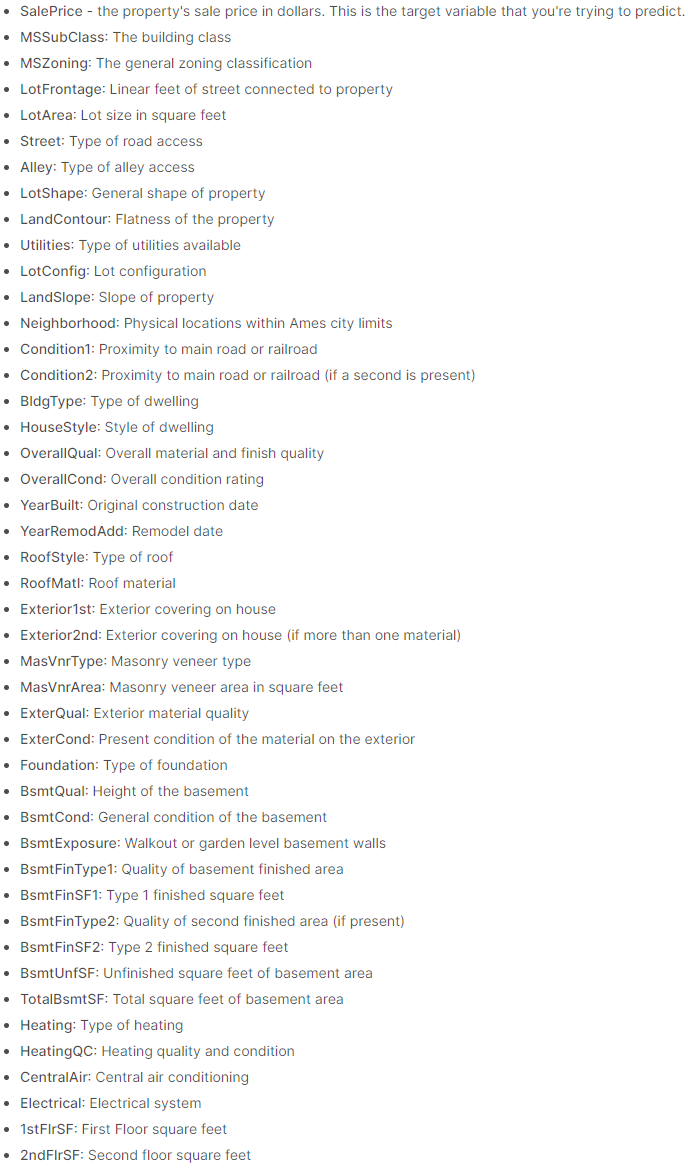

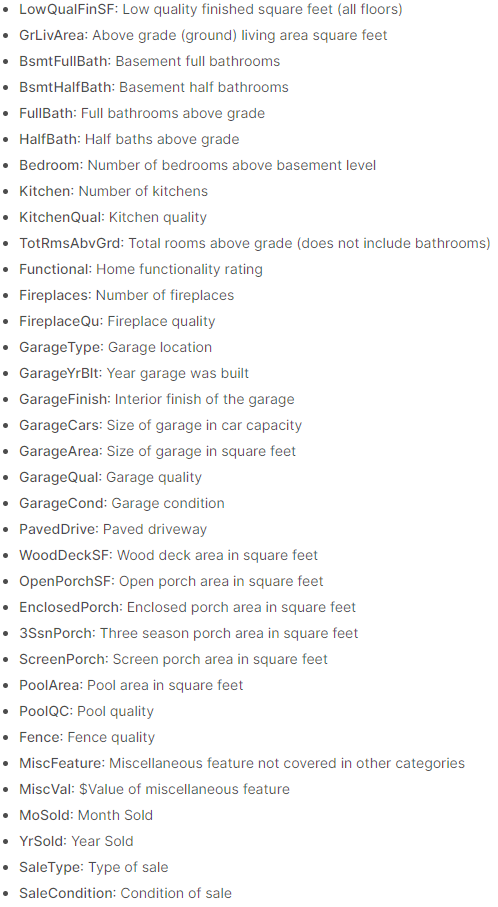

In [ ]:
trainCSV.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

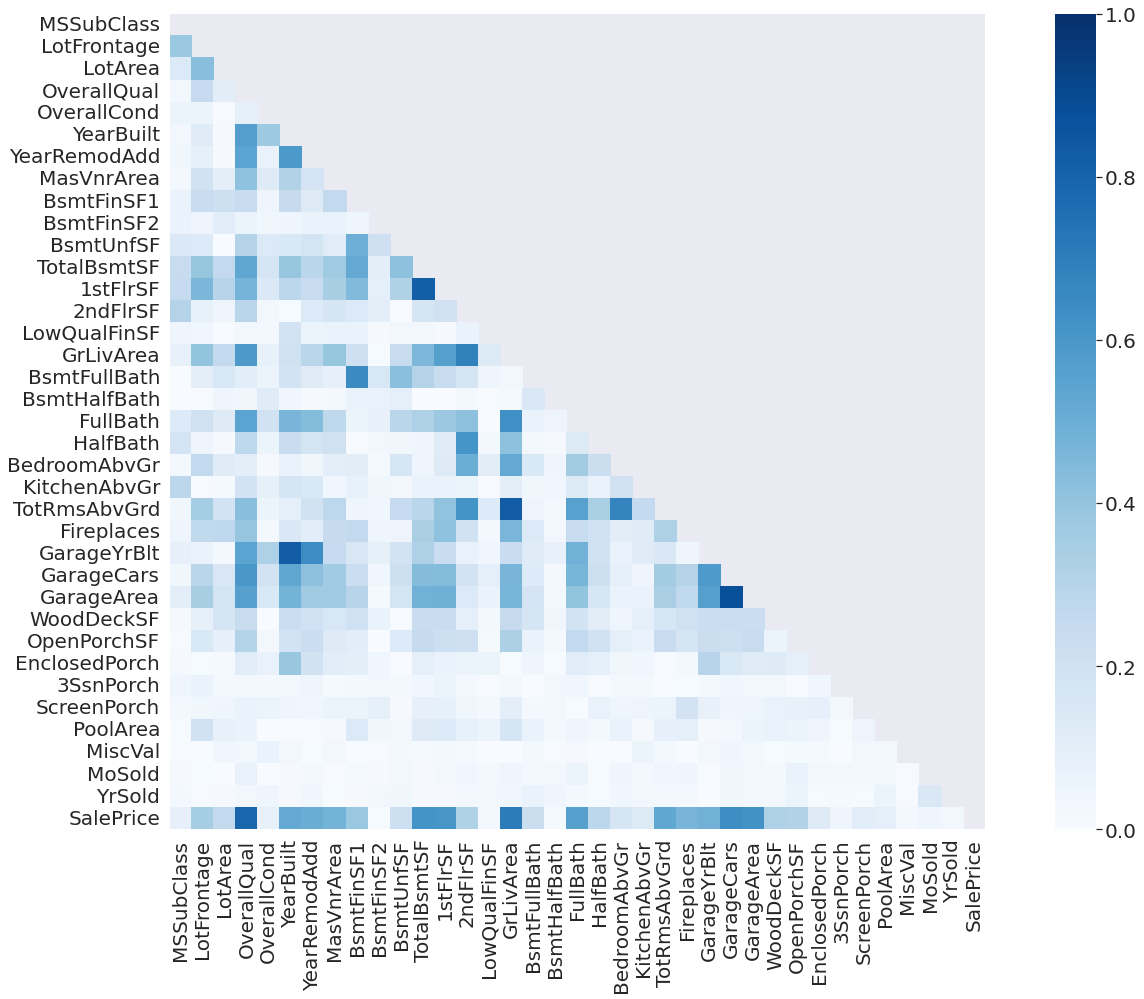

In [ ]:
#correlation matrix
corrmat = np.abs(trainCSV.corr())
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corrmat, cmap=plt.cm.Blues, vmin=0, vmax=1, mask = np.triu(corrmat), square=True);



                                             |          | [  0%]   00:00 -> (? left)


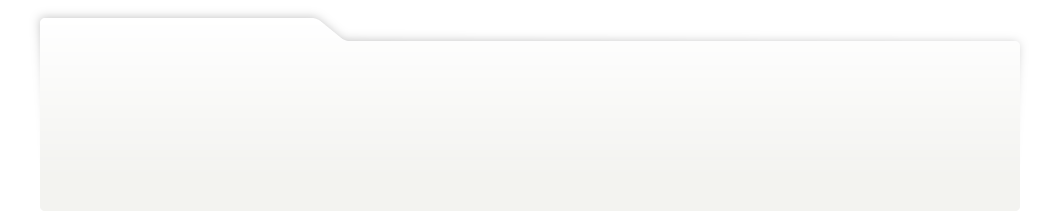
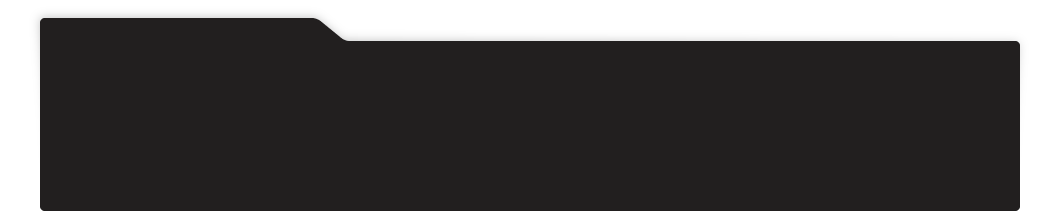
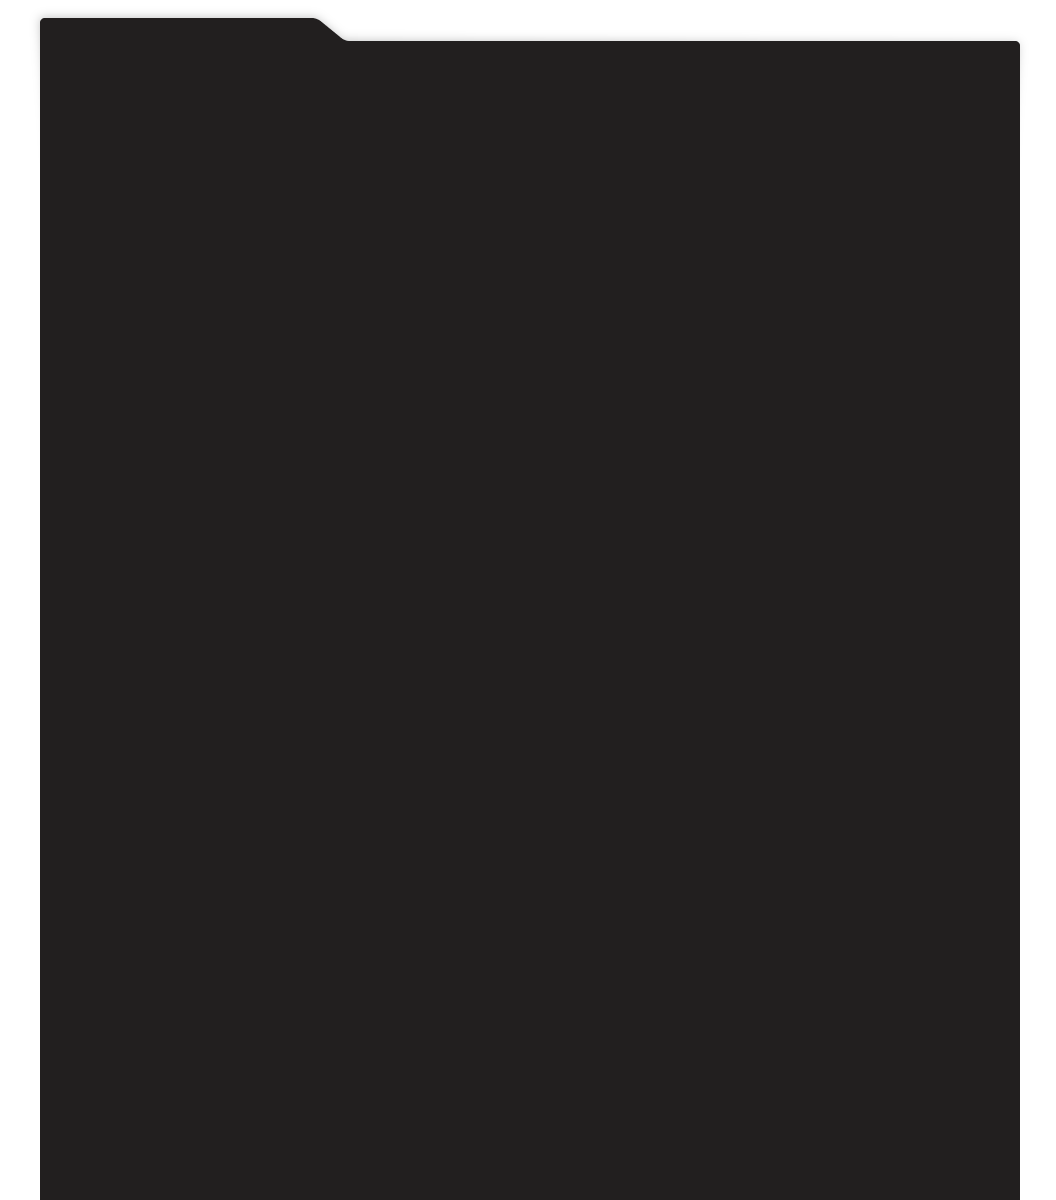
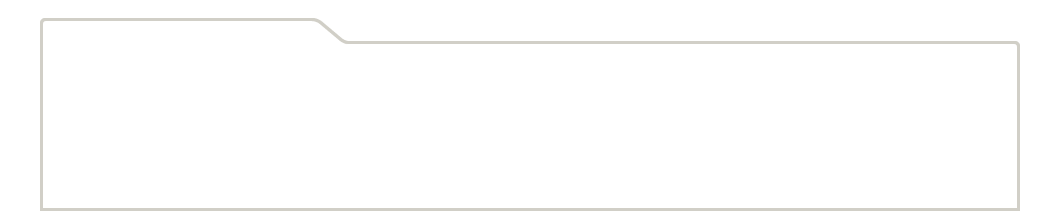
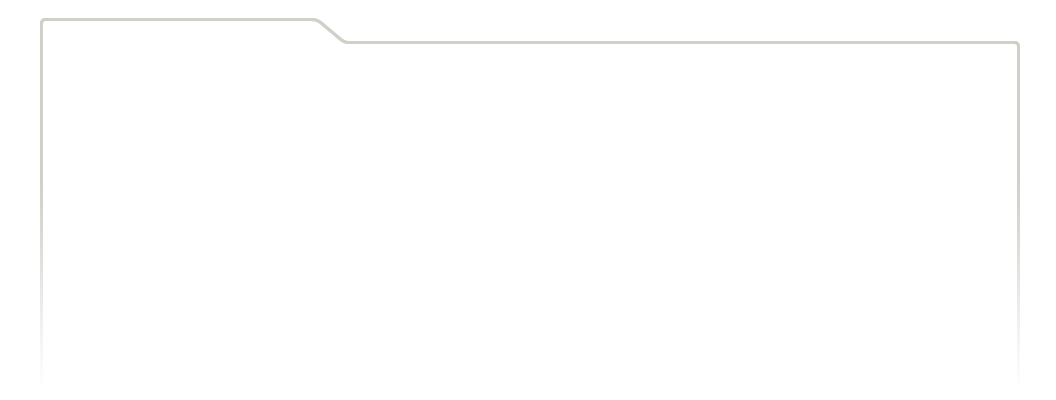
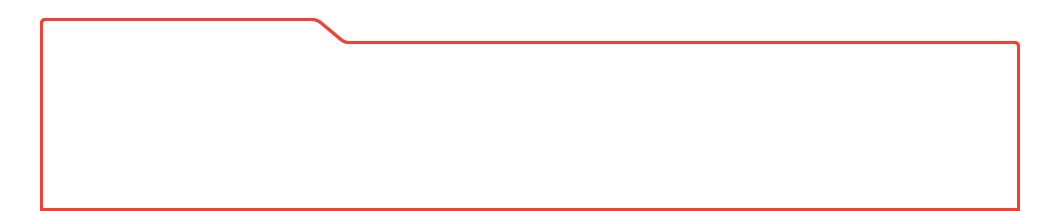
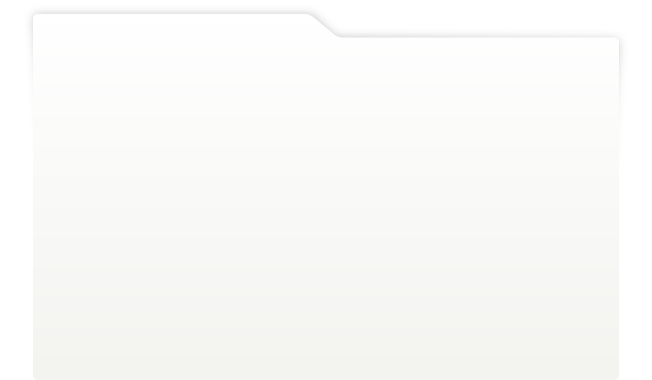
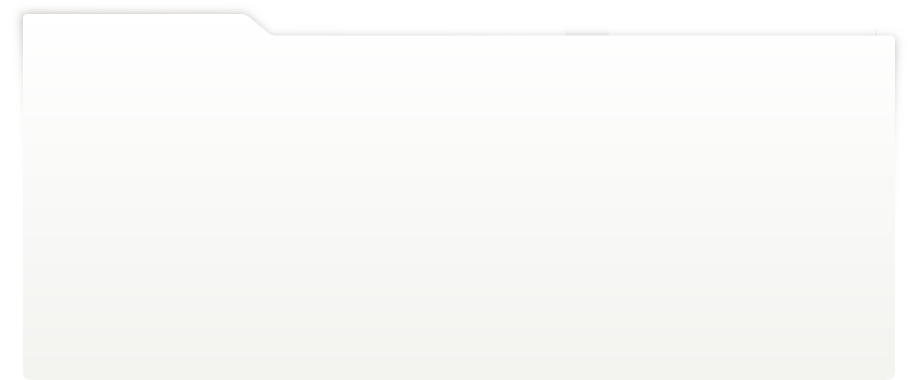
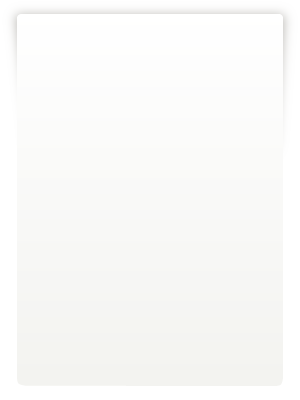
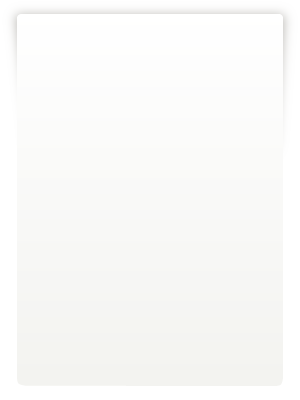
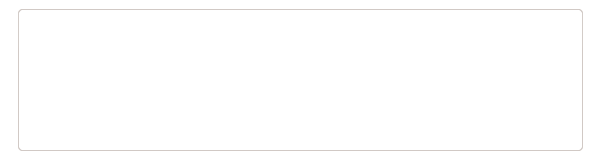
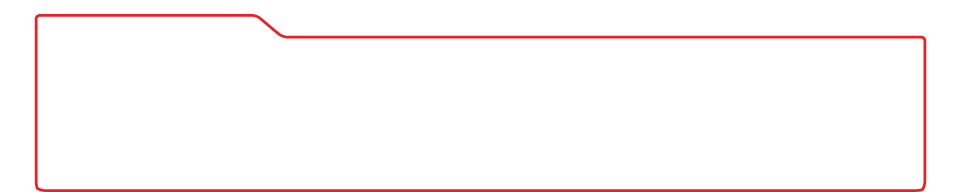
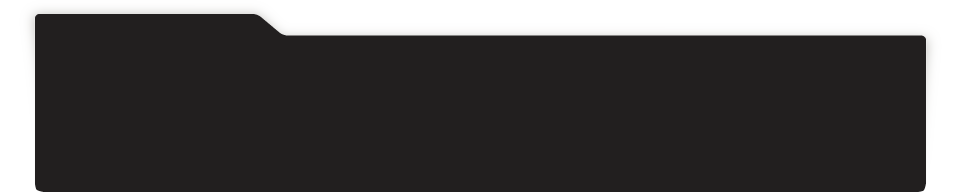
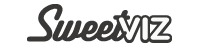
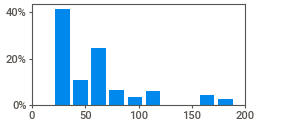
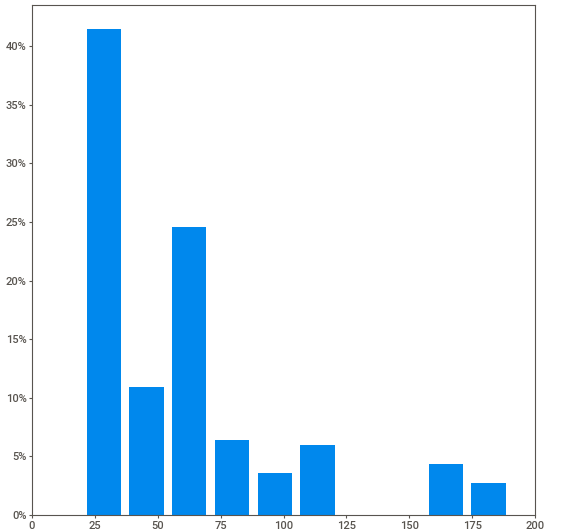
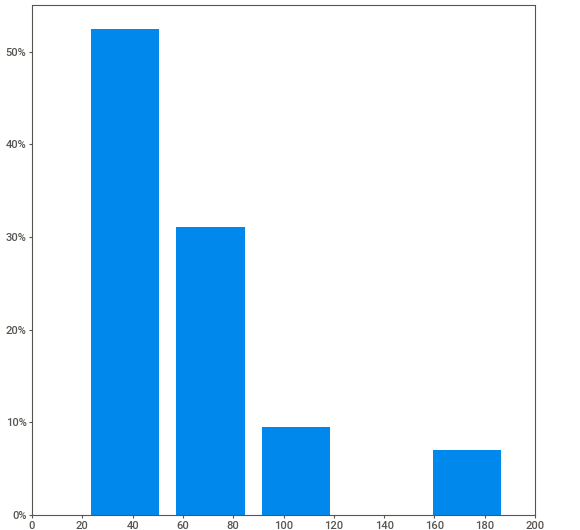
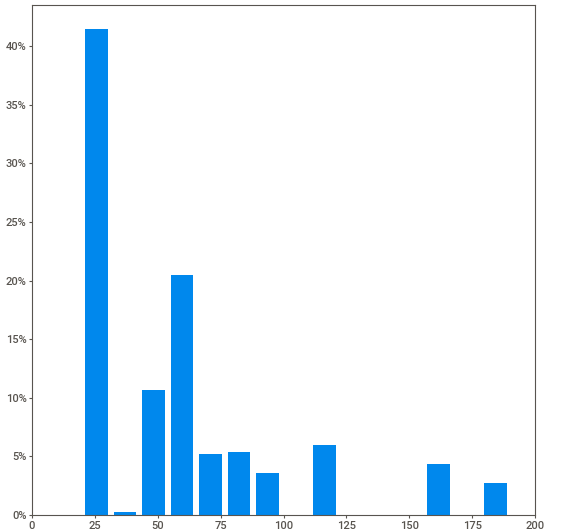
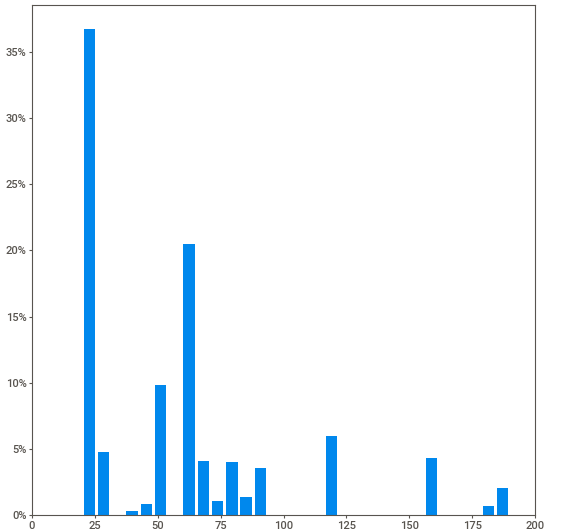
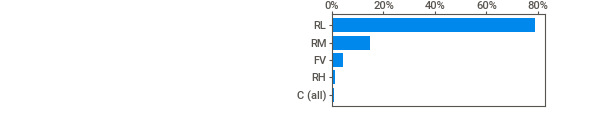
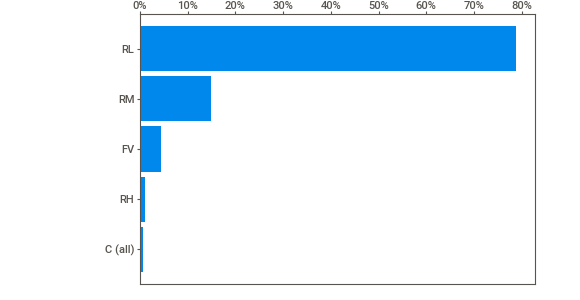
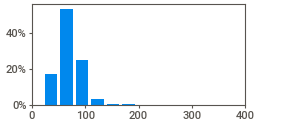
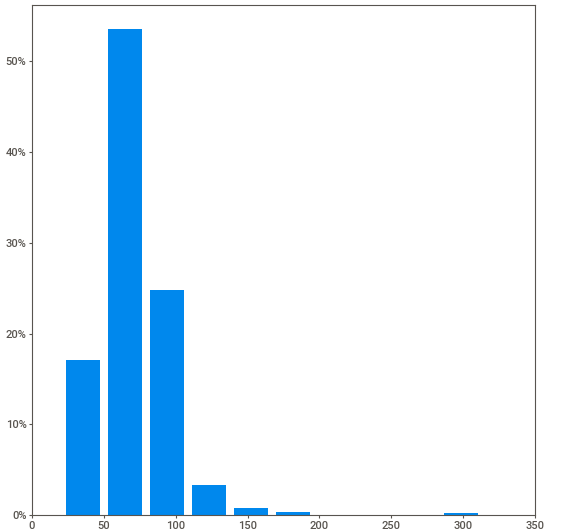
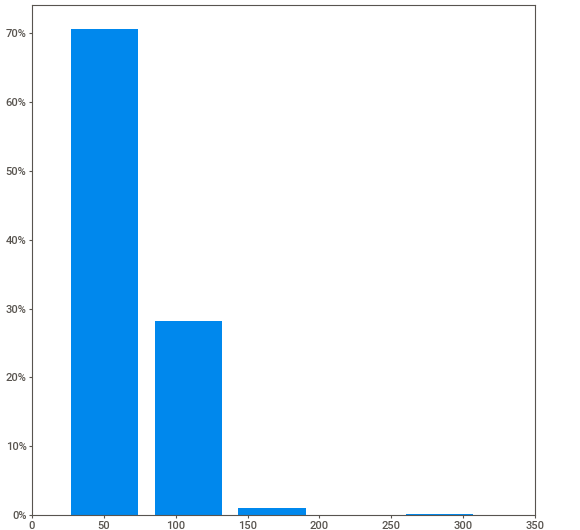
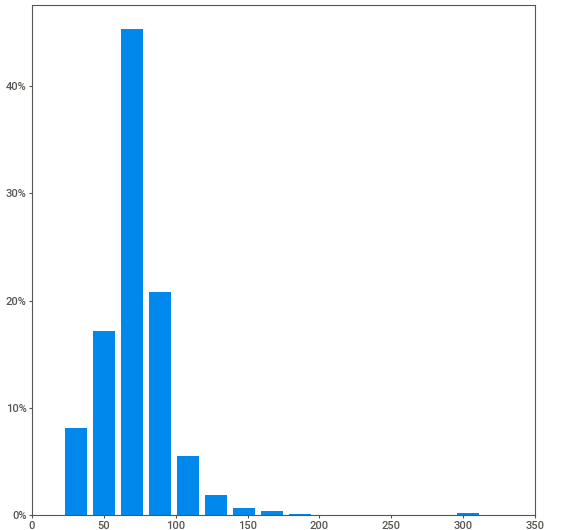
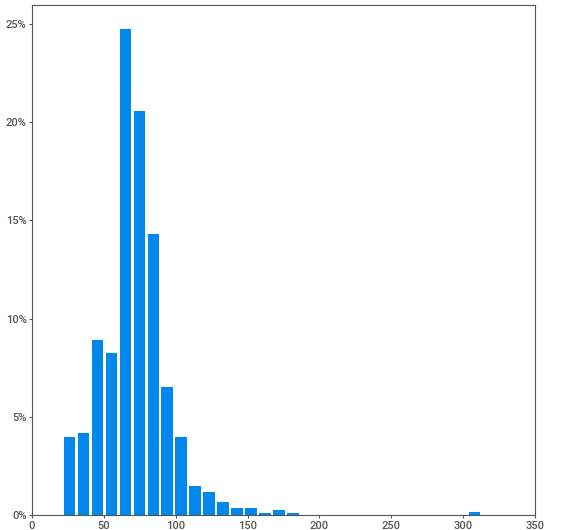
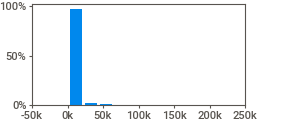
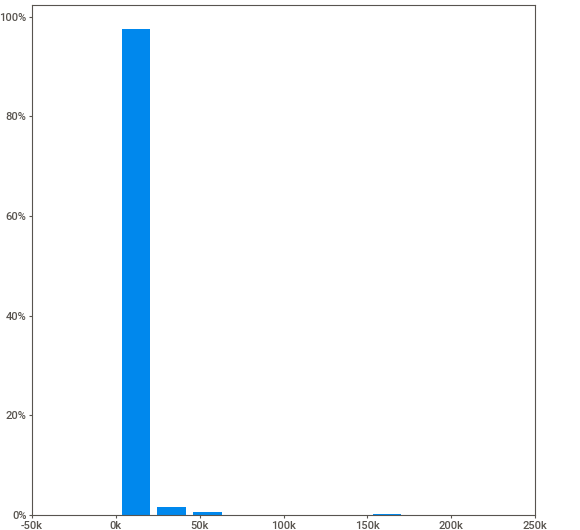
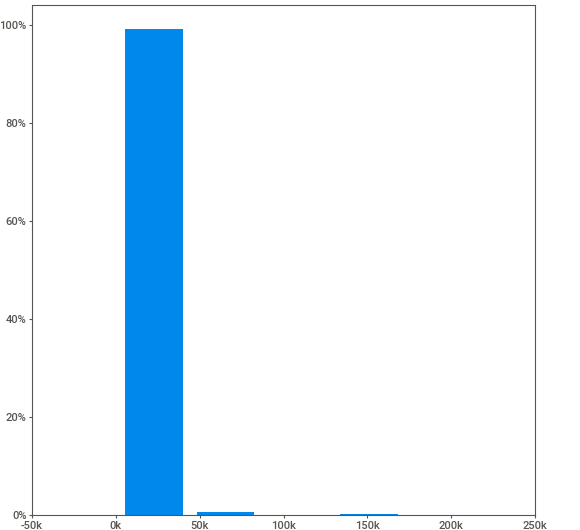
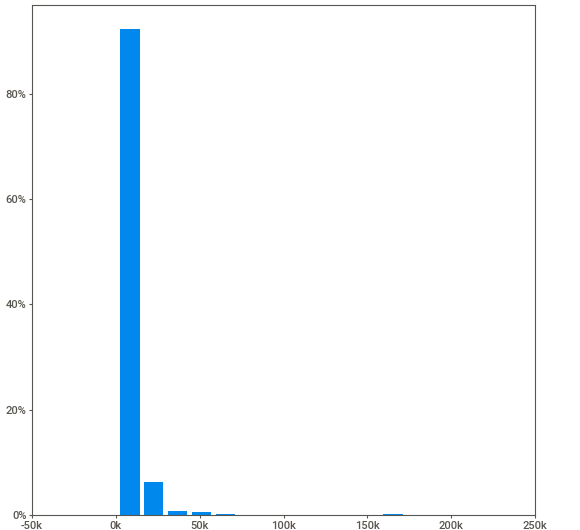
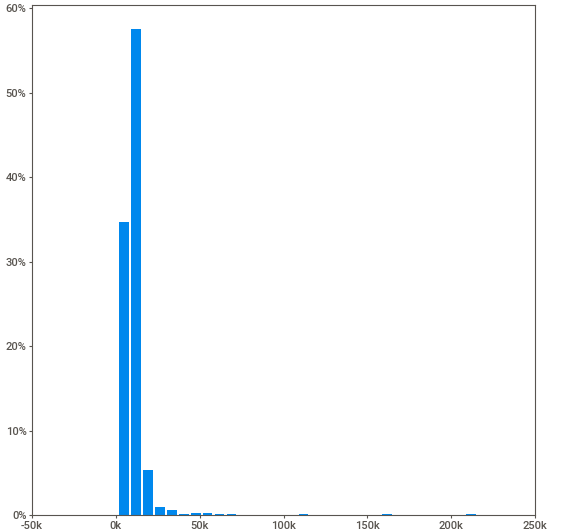
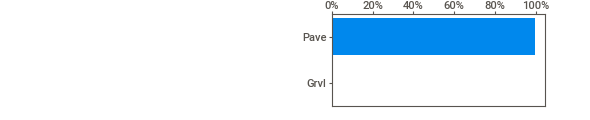
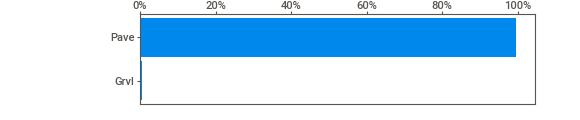
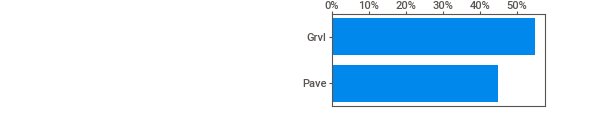
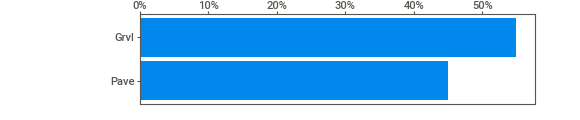
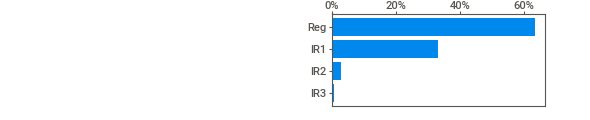
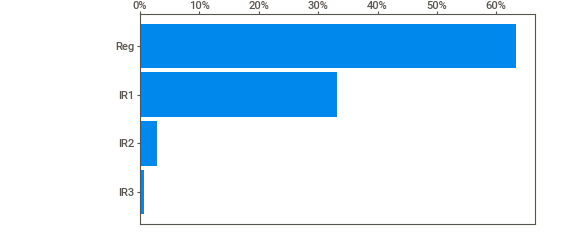
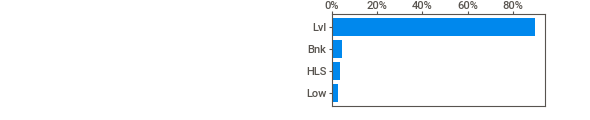
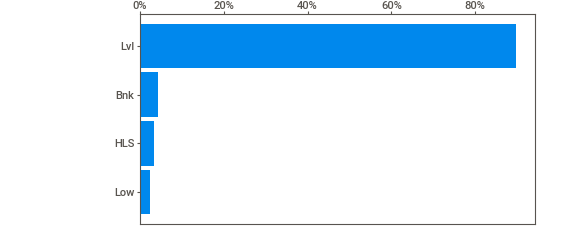
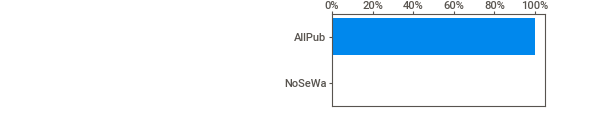
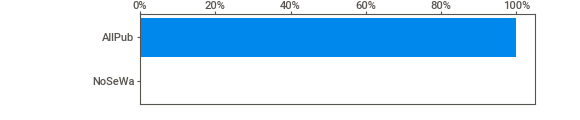
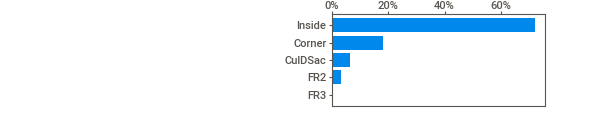
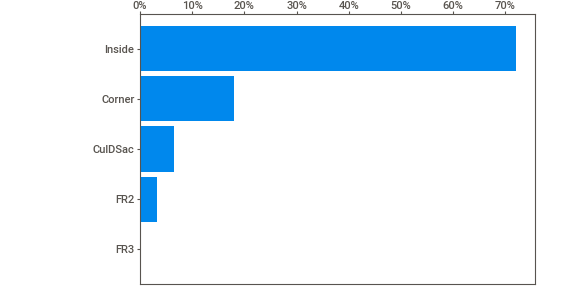
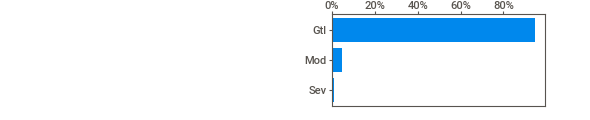
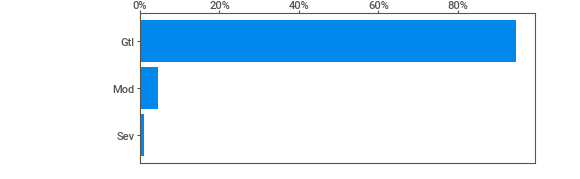
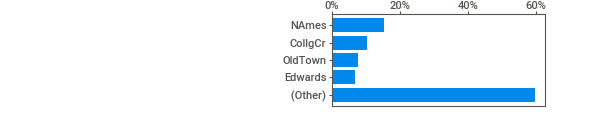
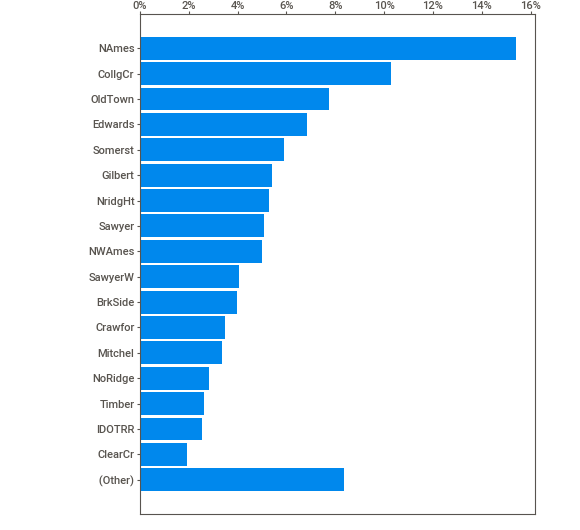
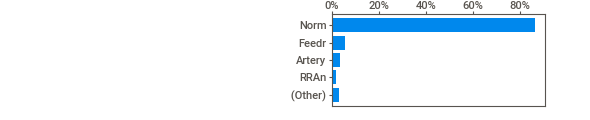
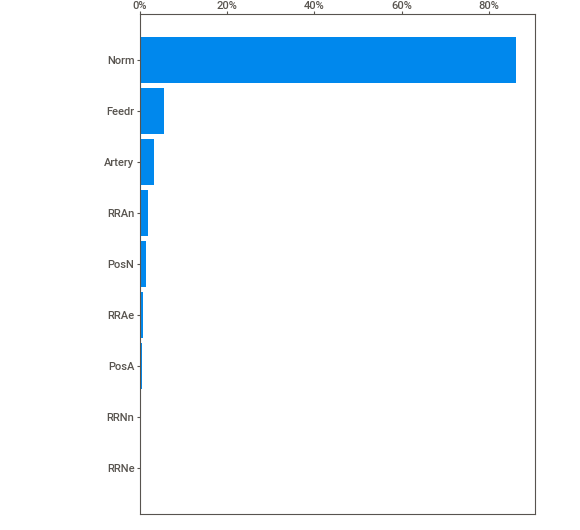
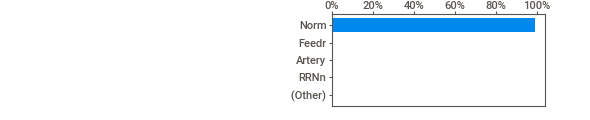
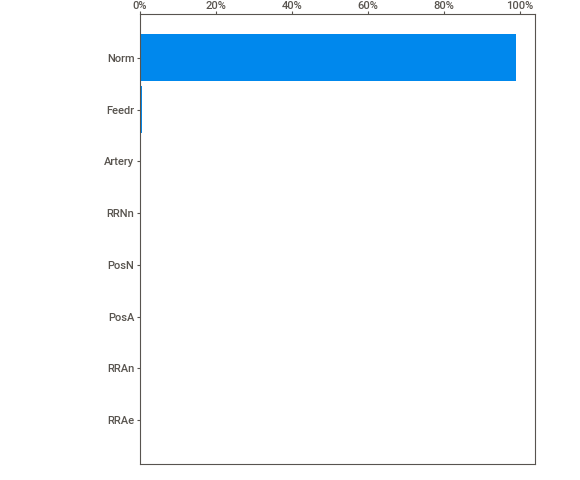
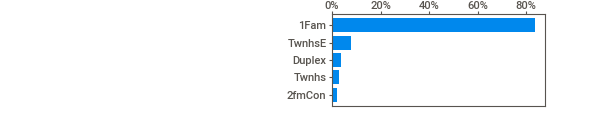
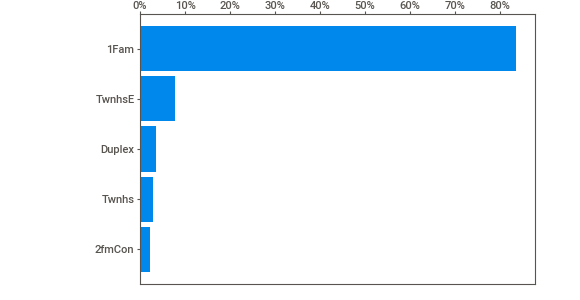
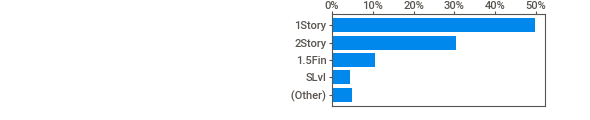
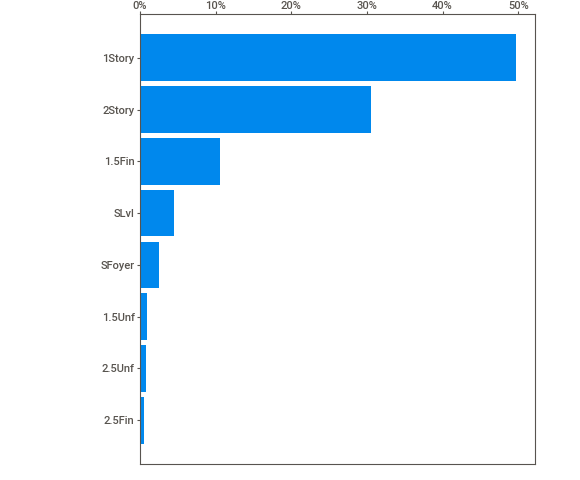
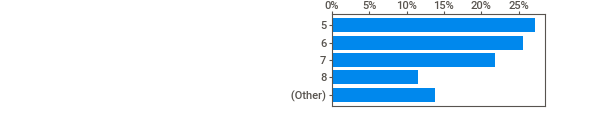
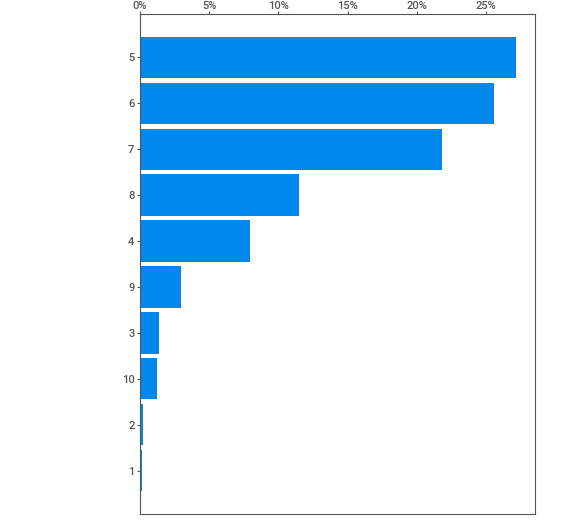
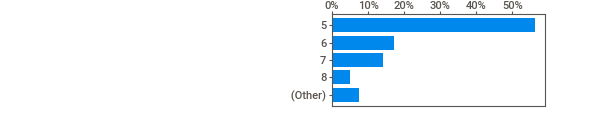
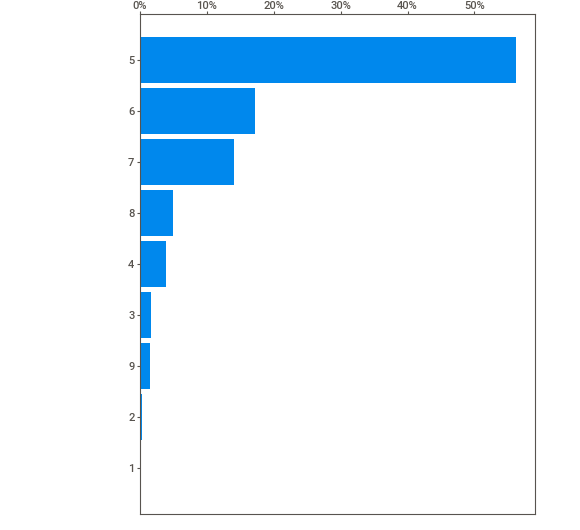
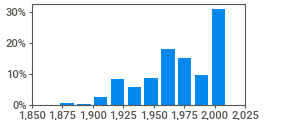
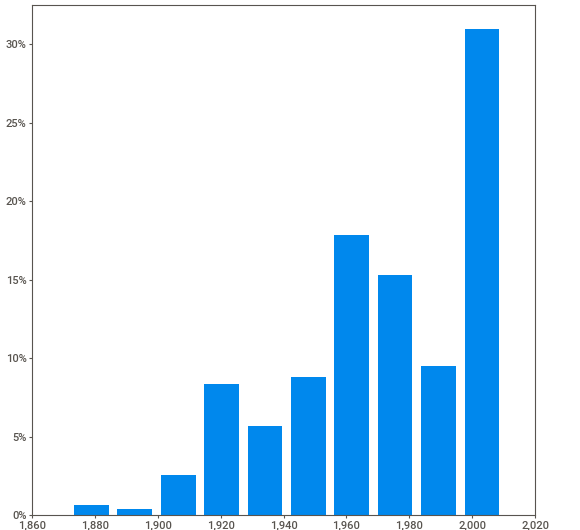
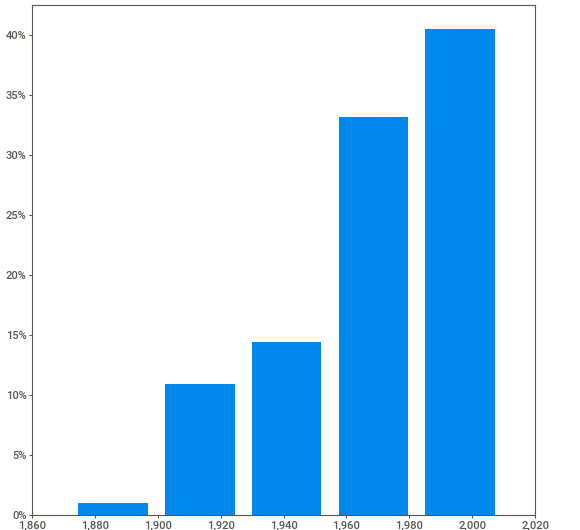
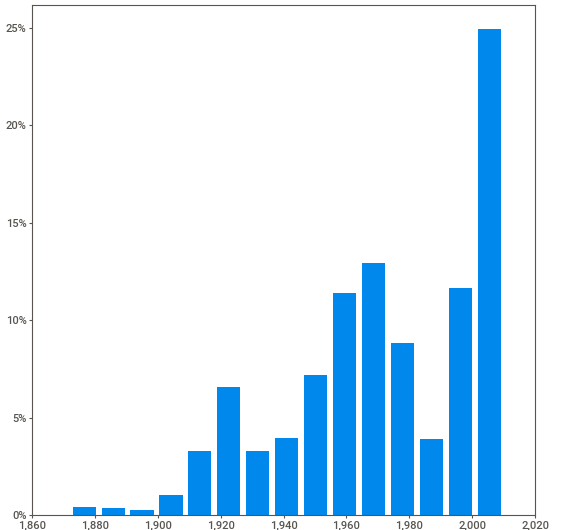
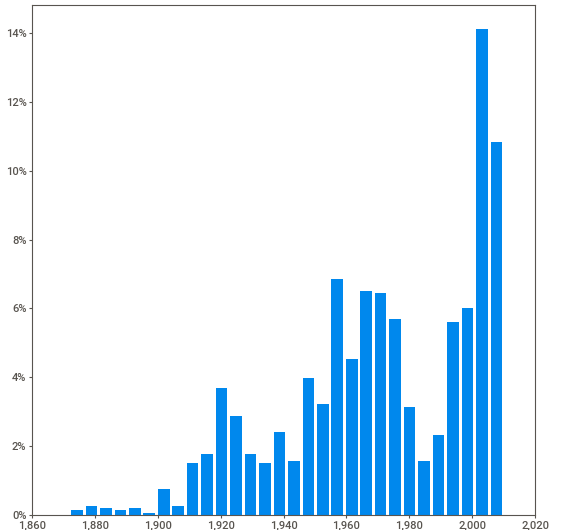
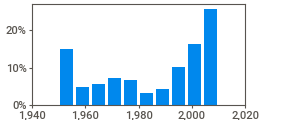
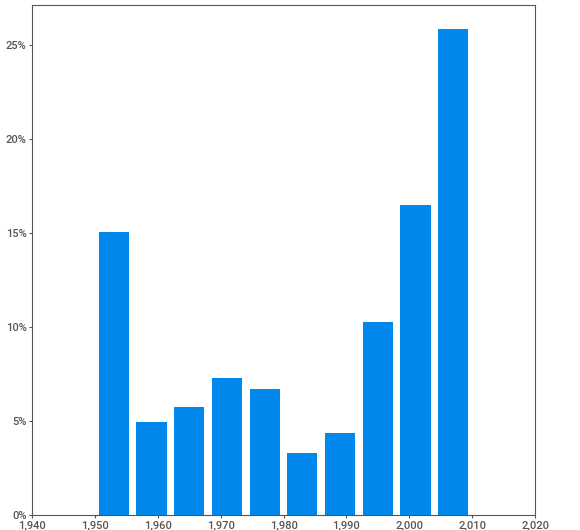
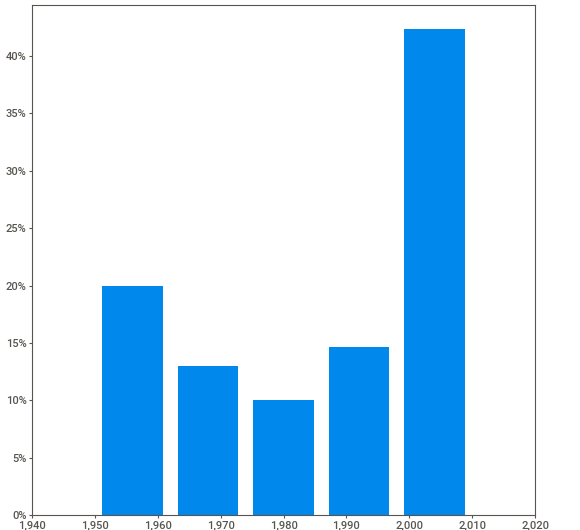
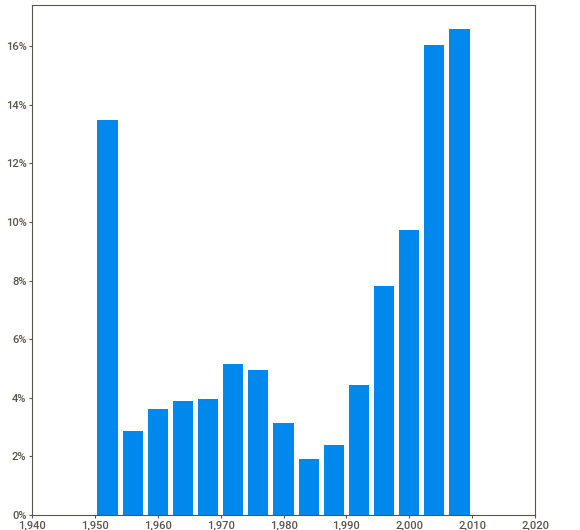
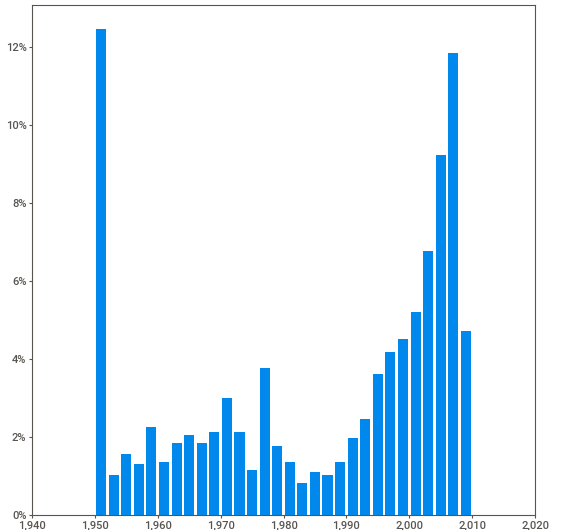
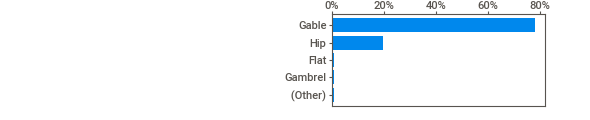
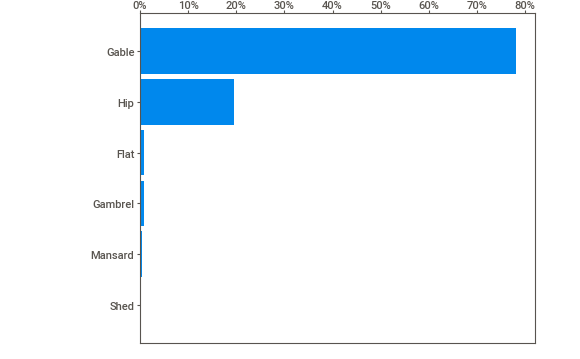
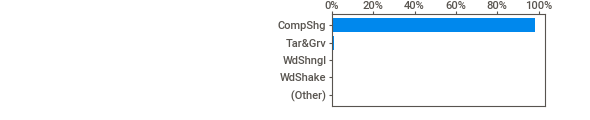
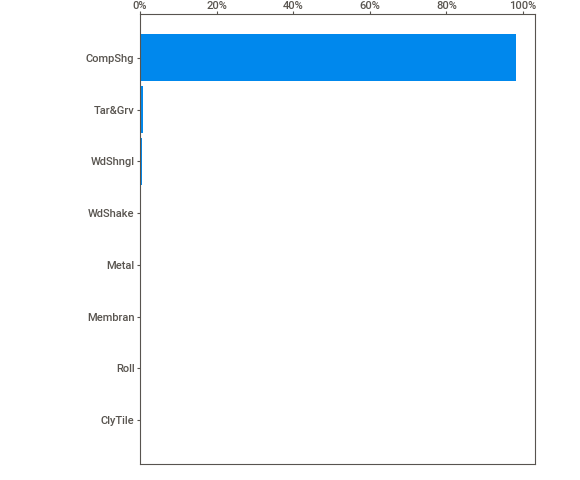
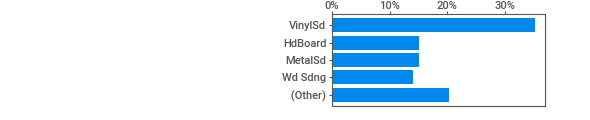
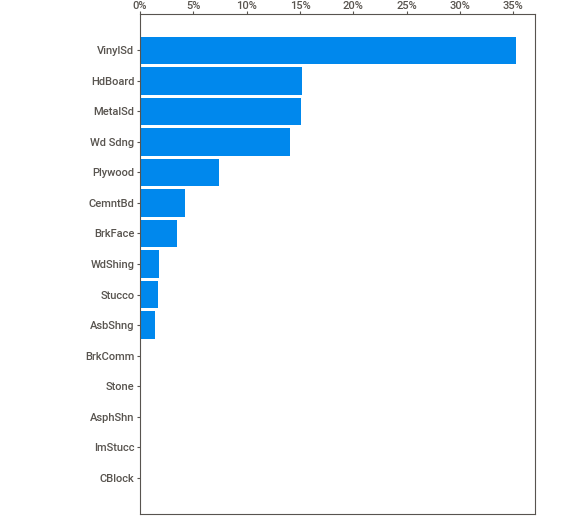
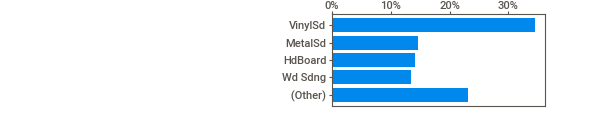
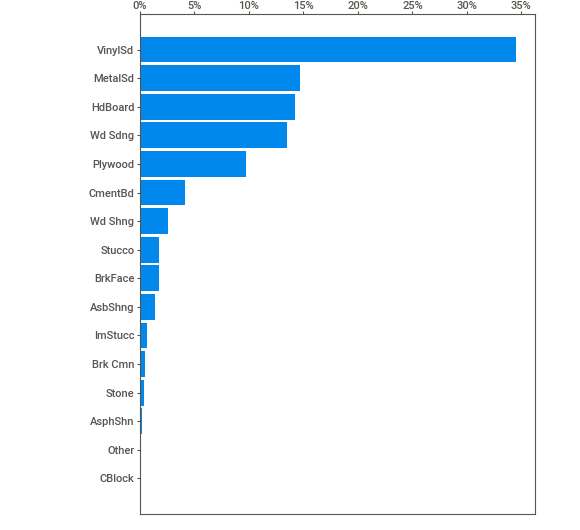
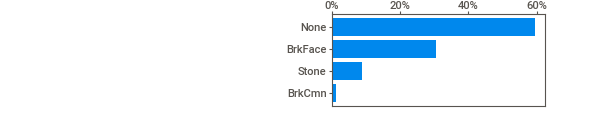
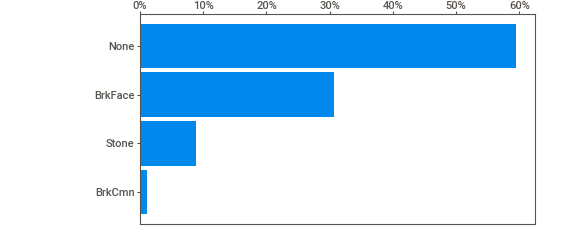
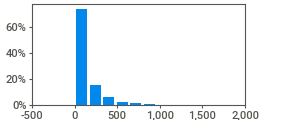
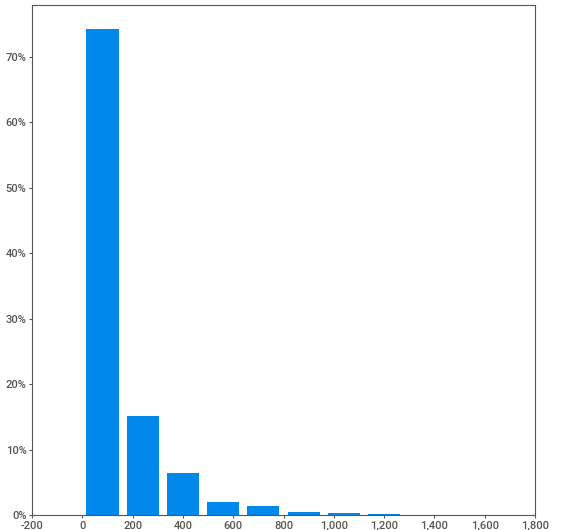
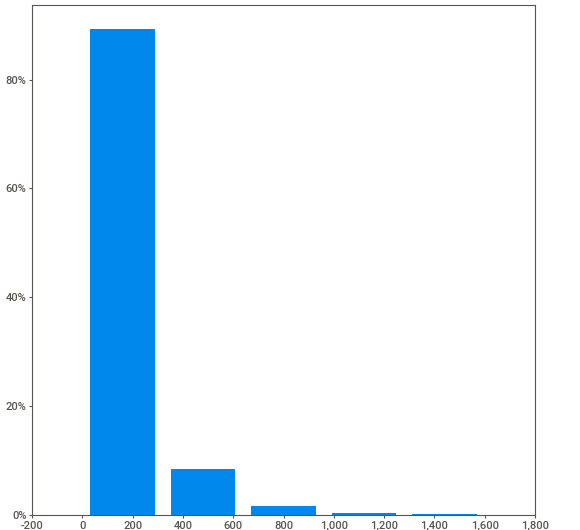
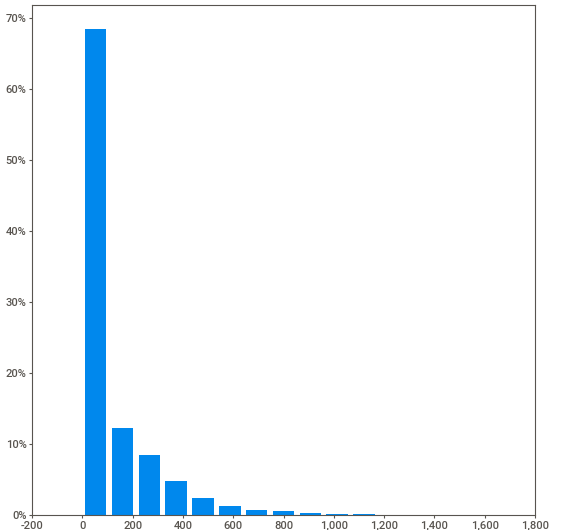
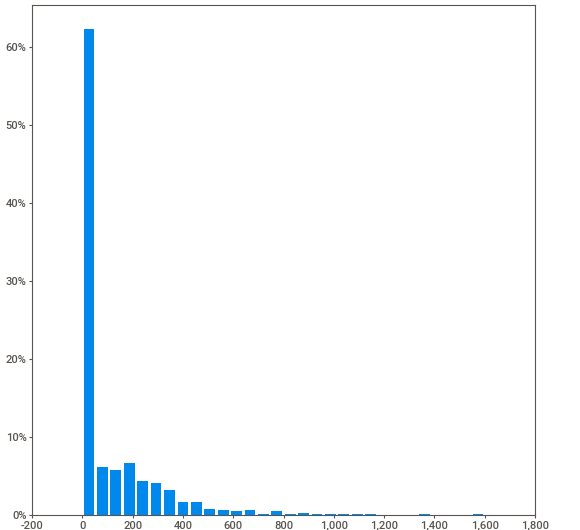
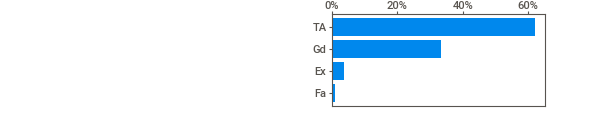
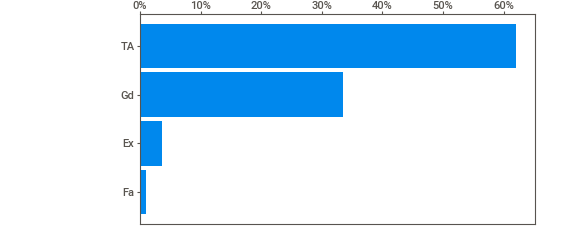
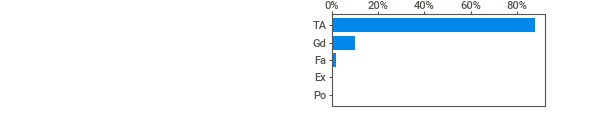
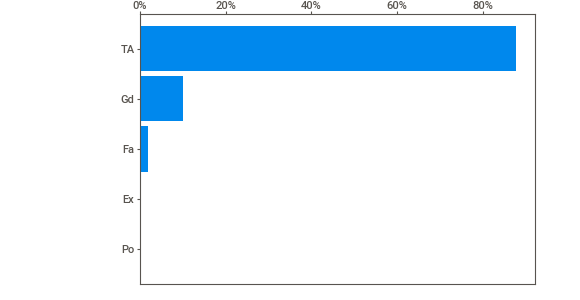
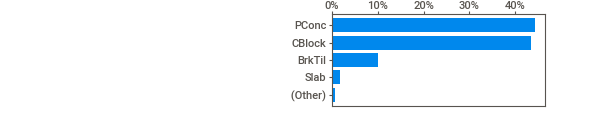
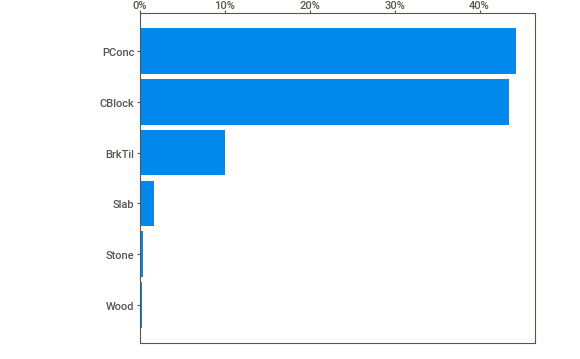
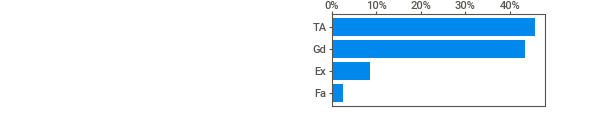
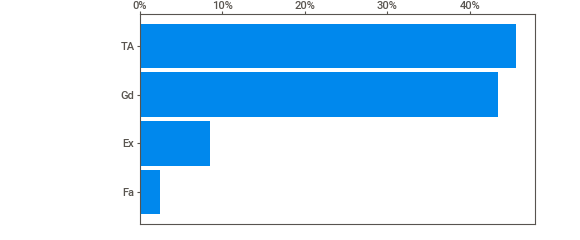
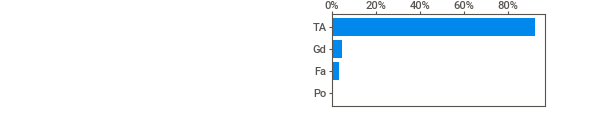
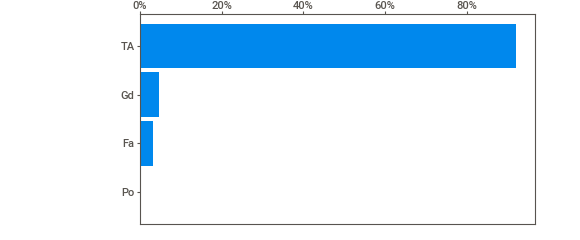
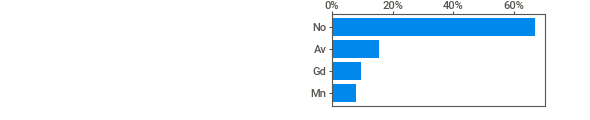
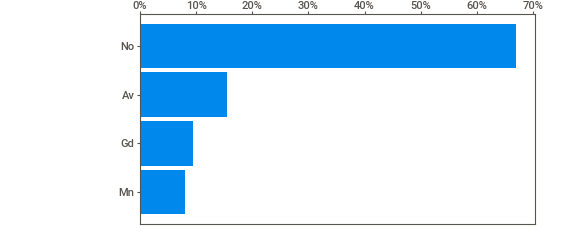
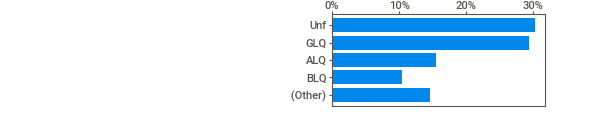
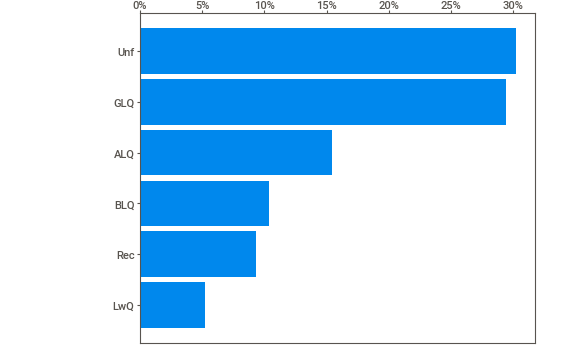
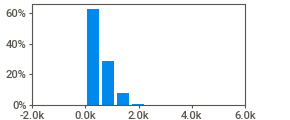
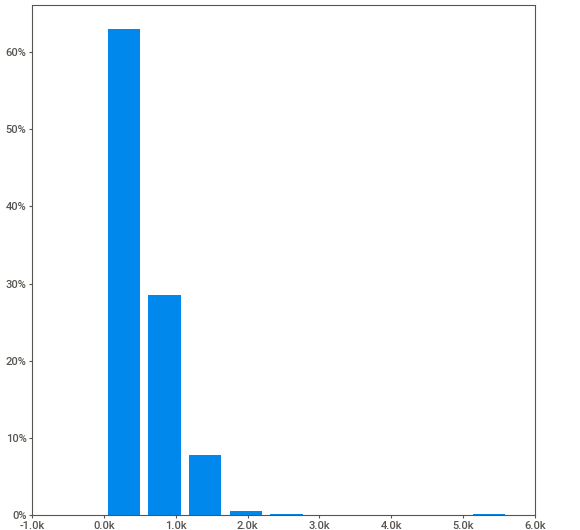
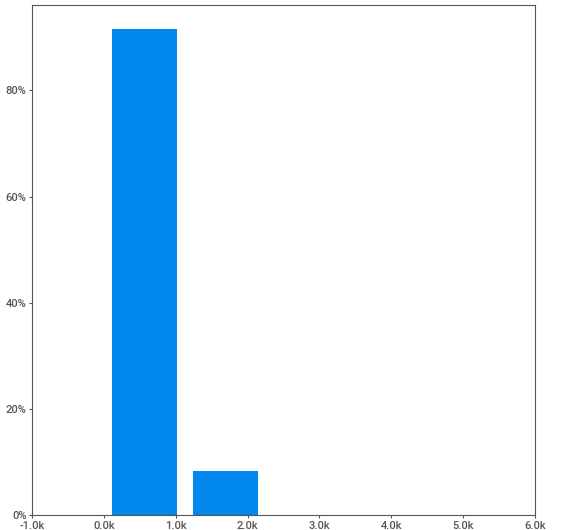
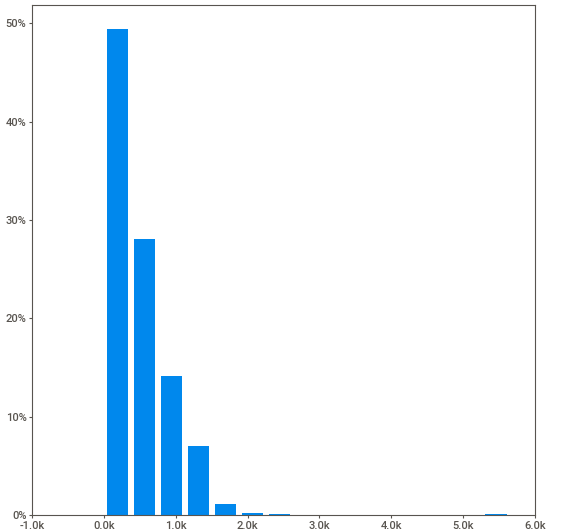
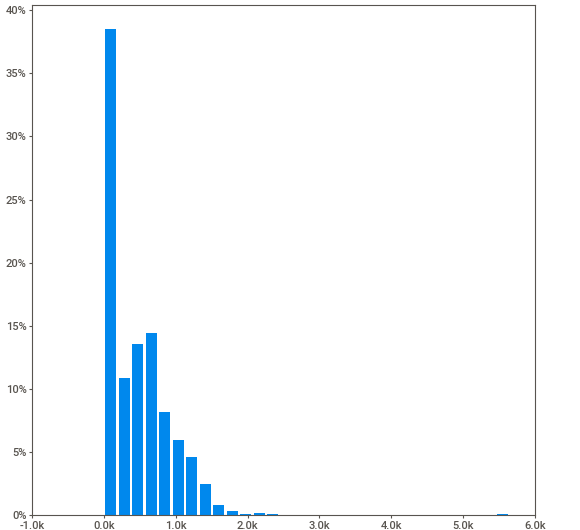
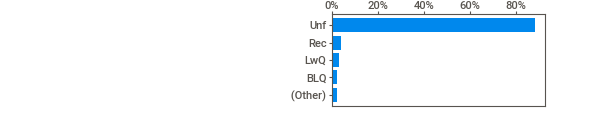
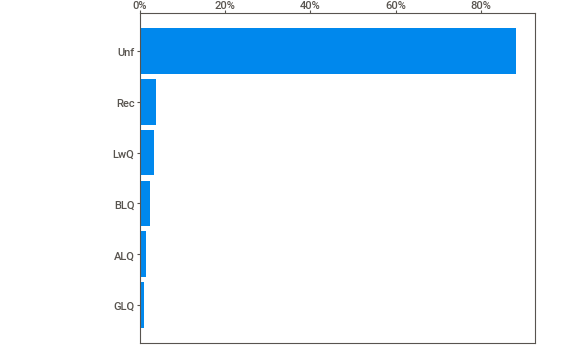
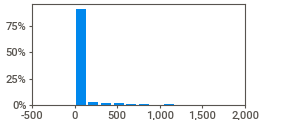
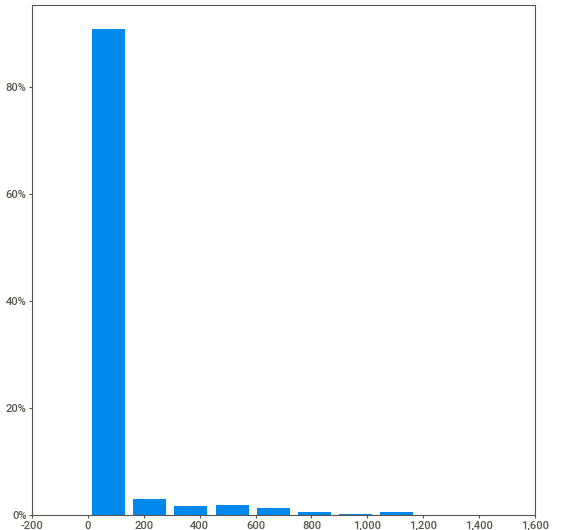
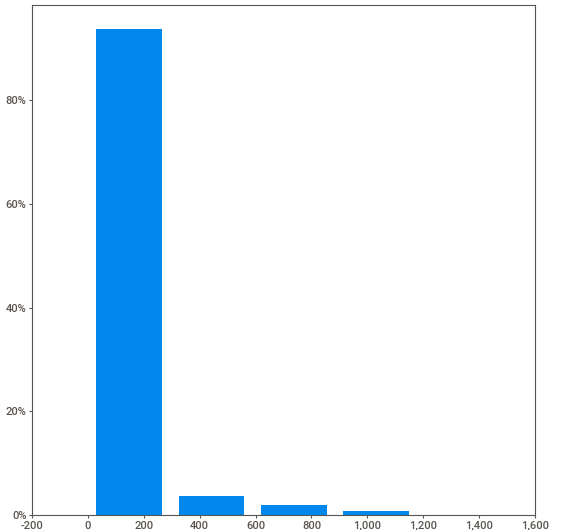
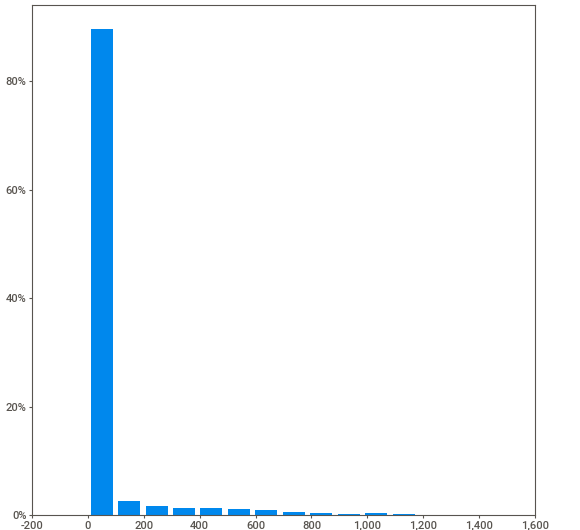
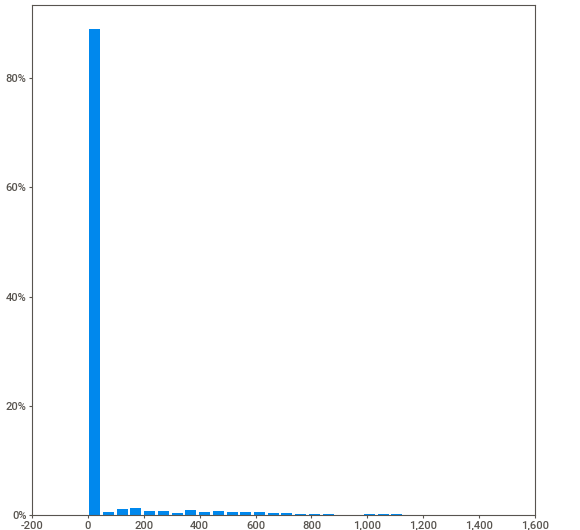
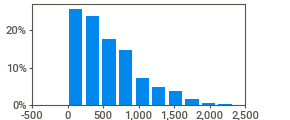
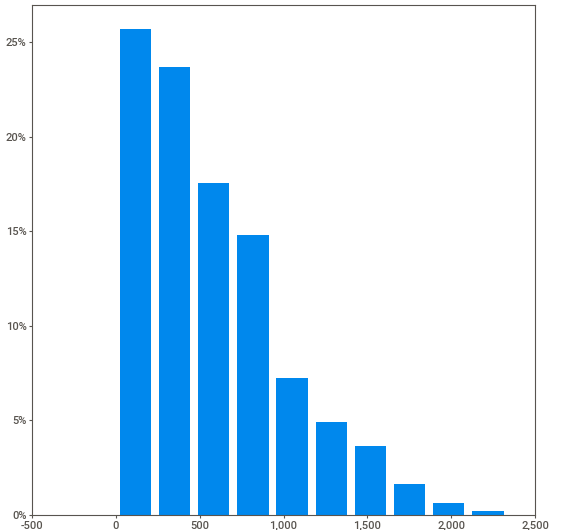
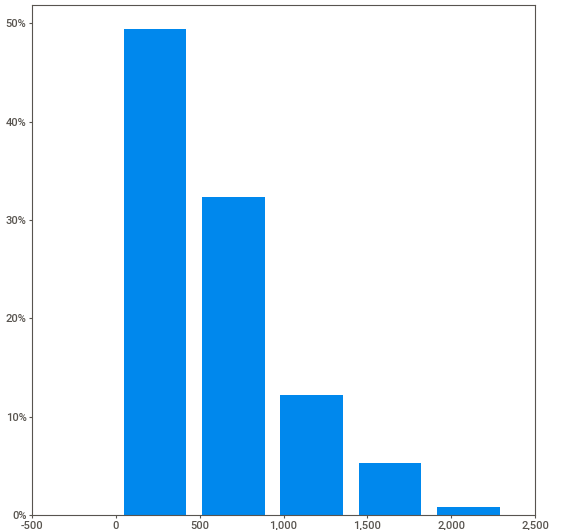
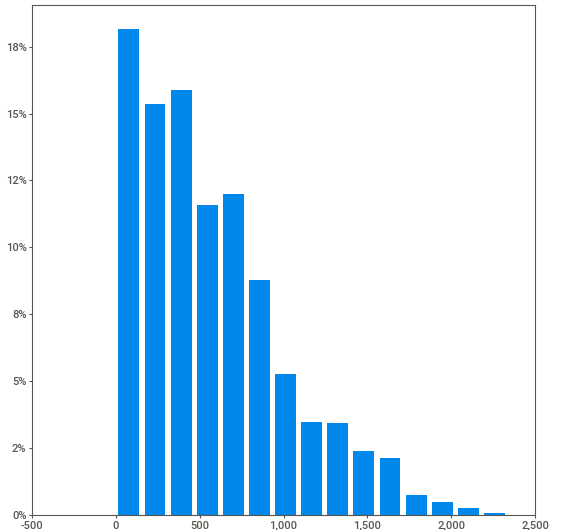
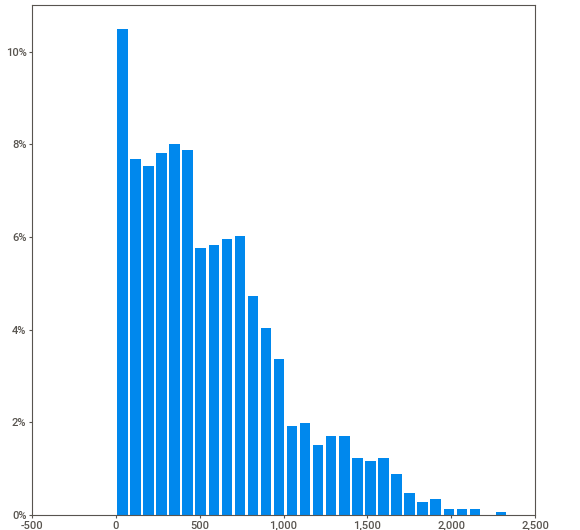
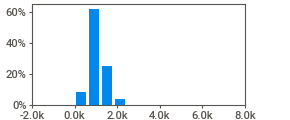
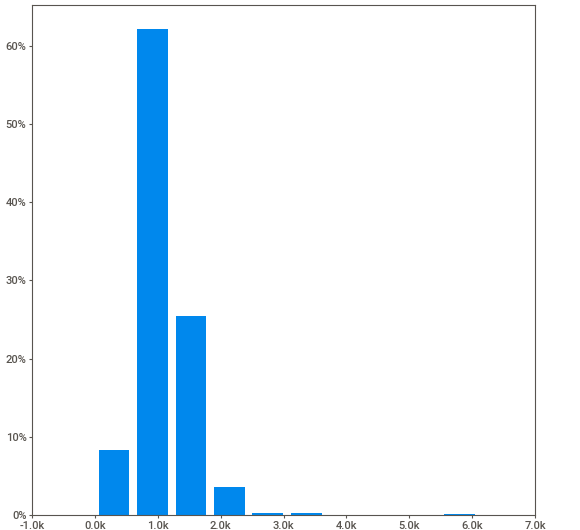
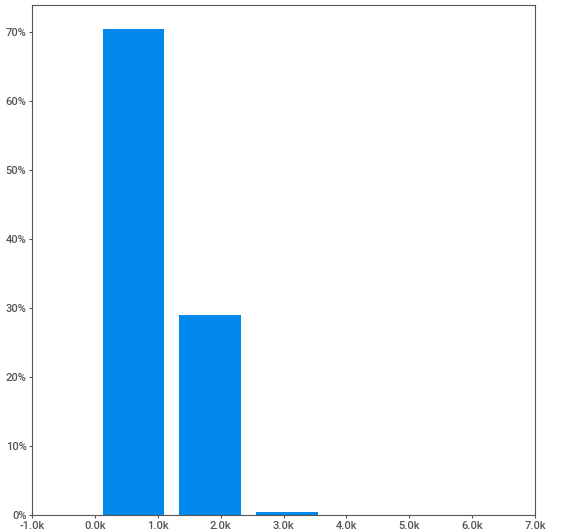
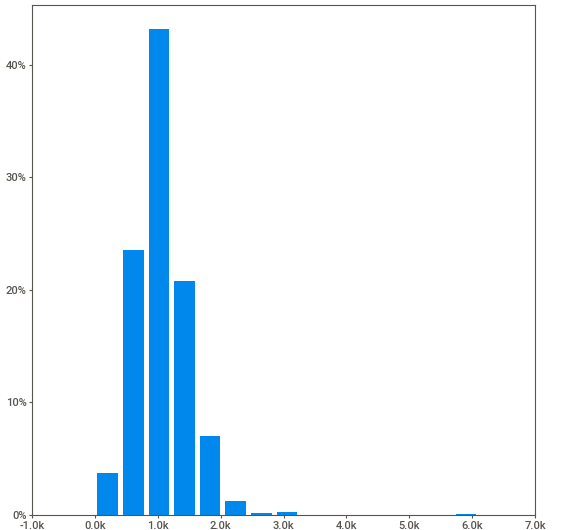
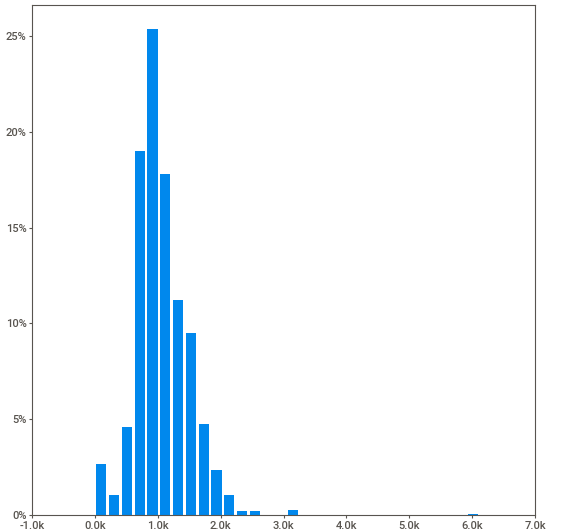
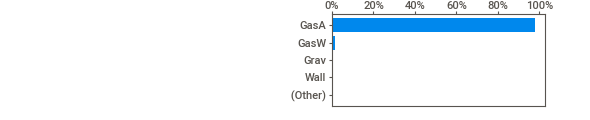
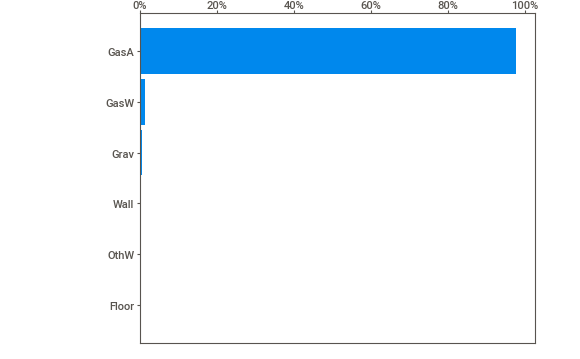
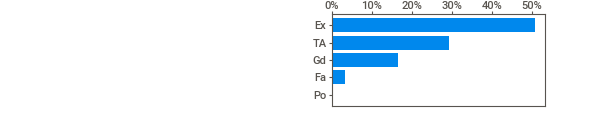
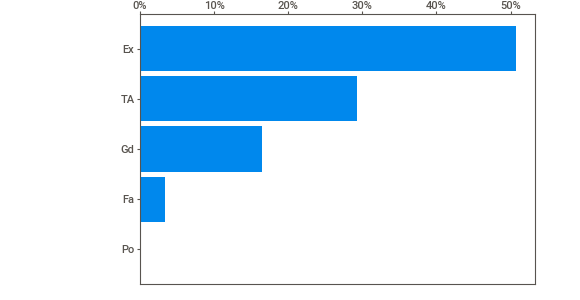
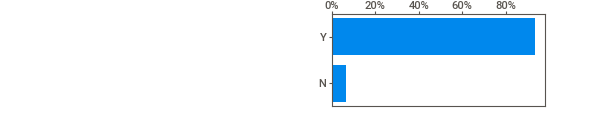
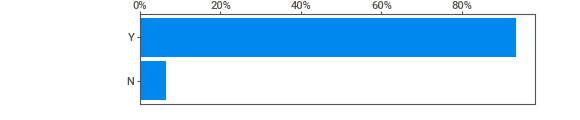
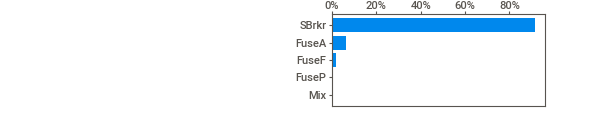
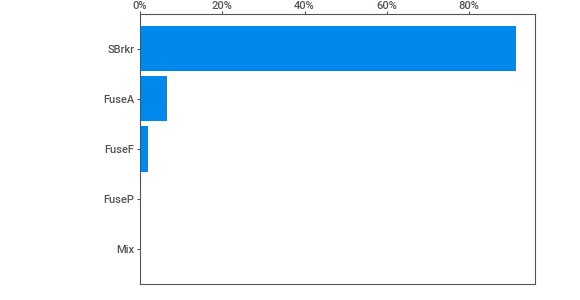
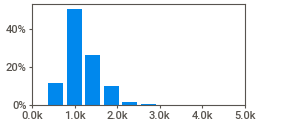
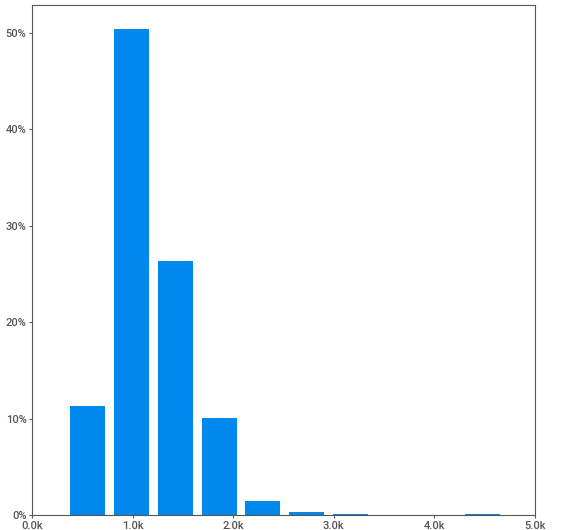
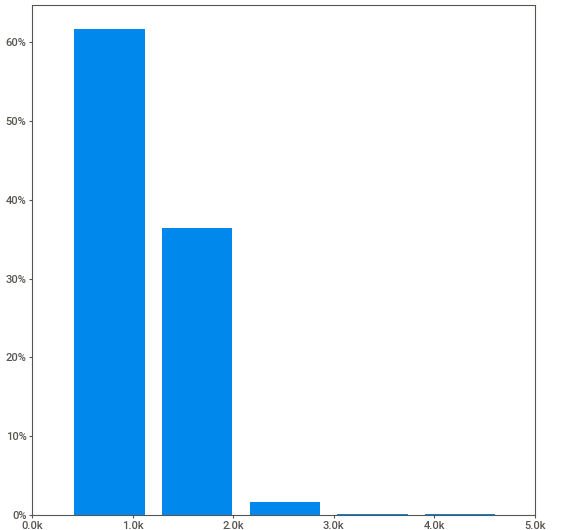
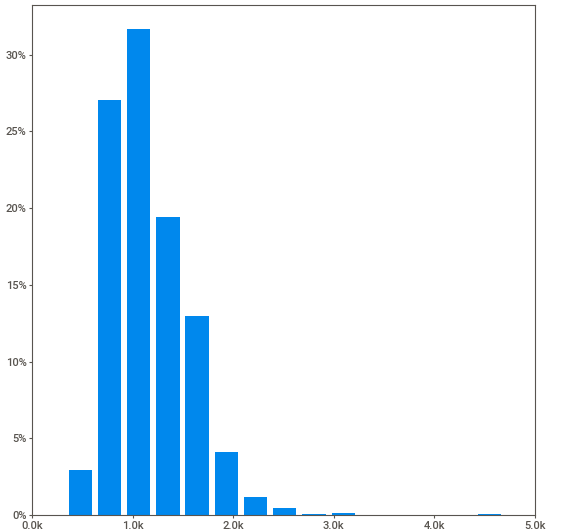
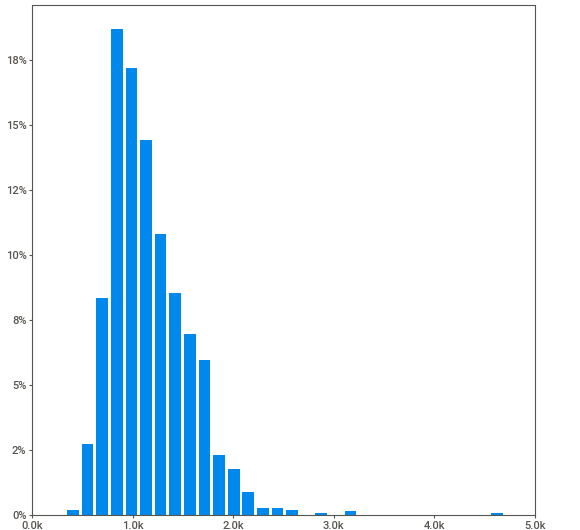
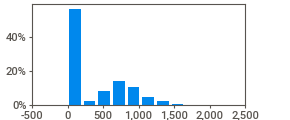
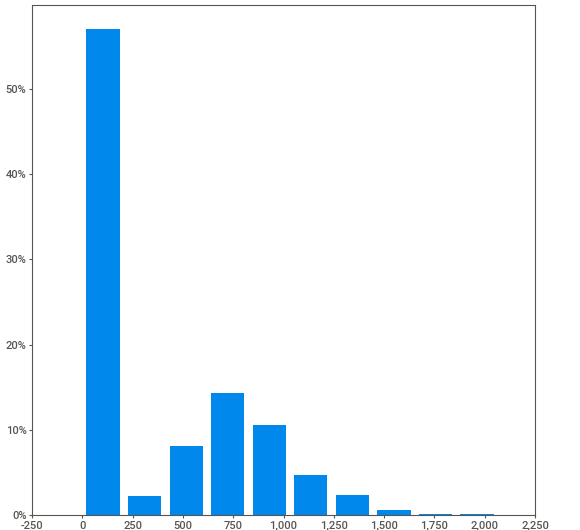
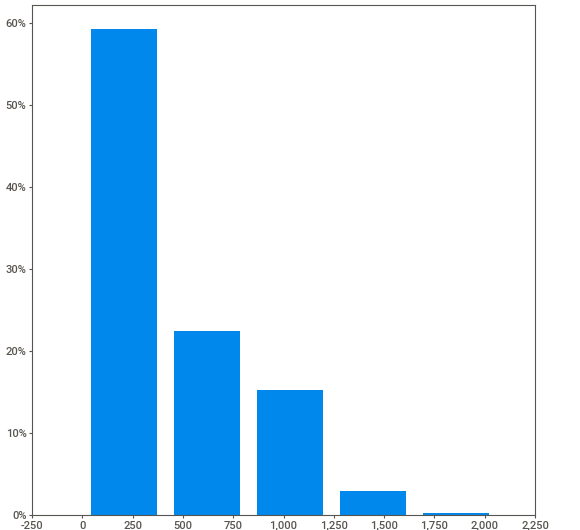
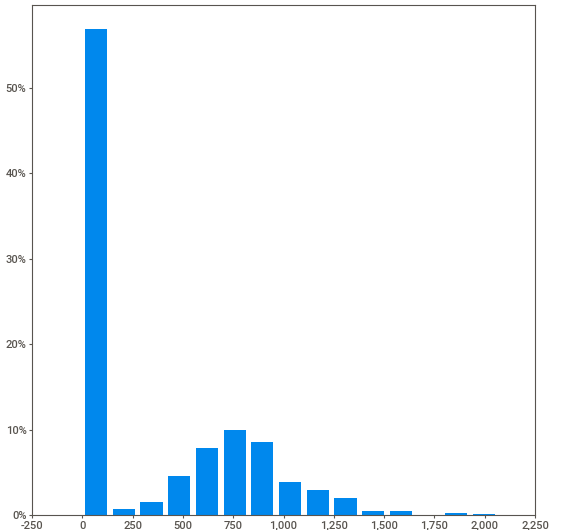
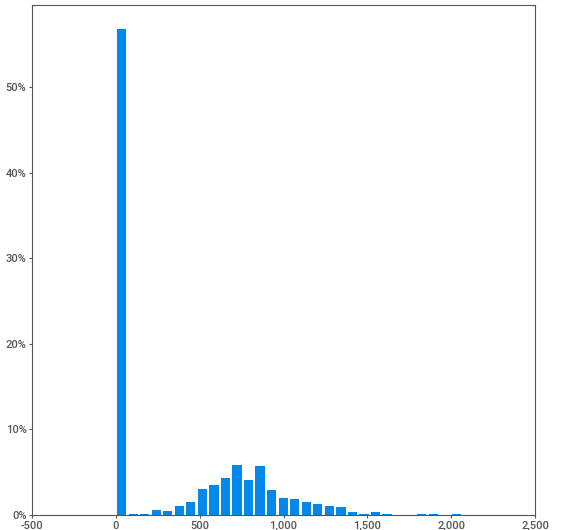
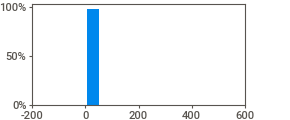
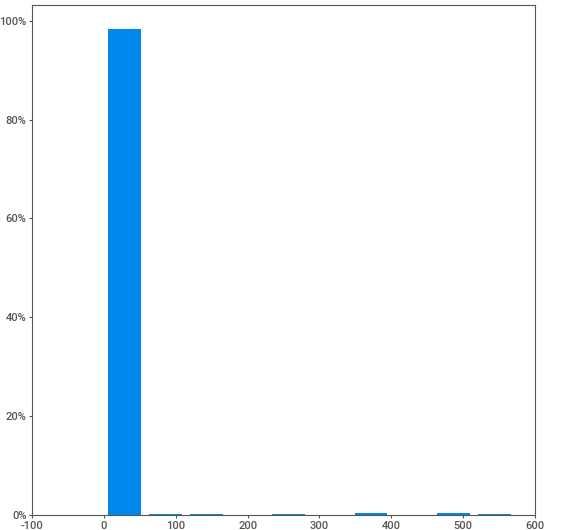
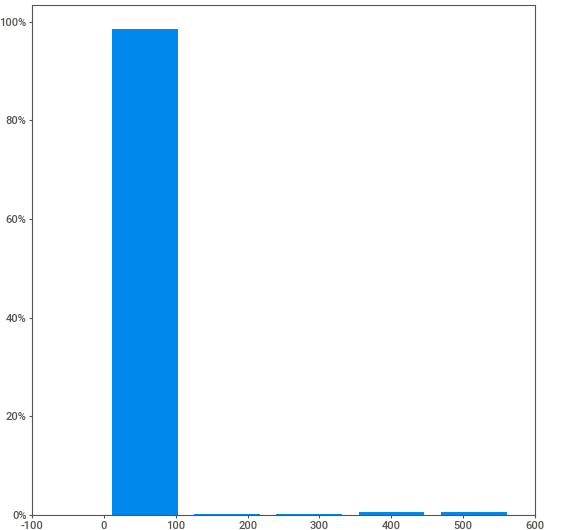
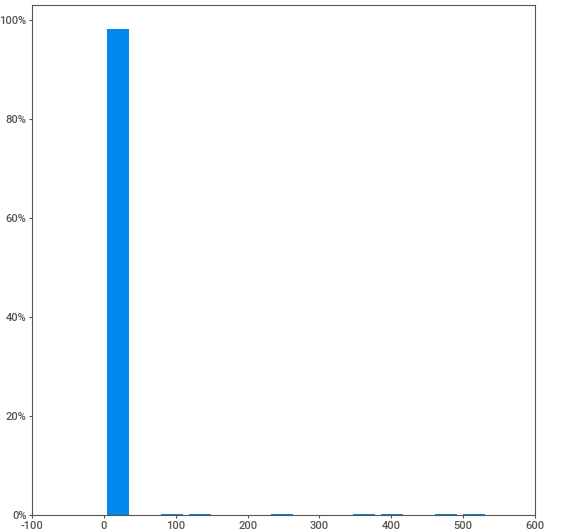
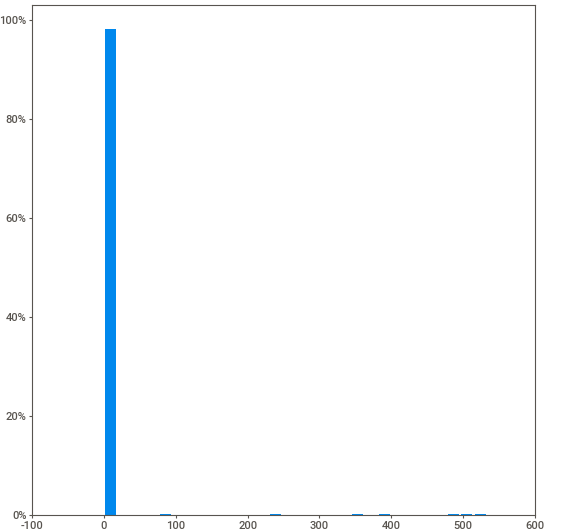
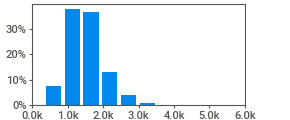
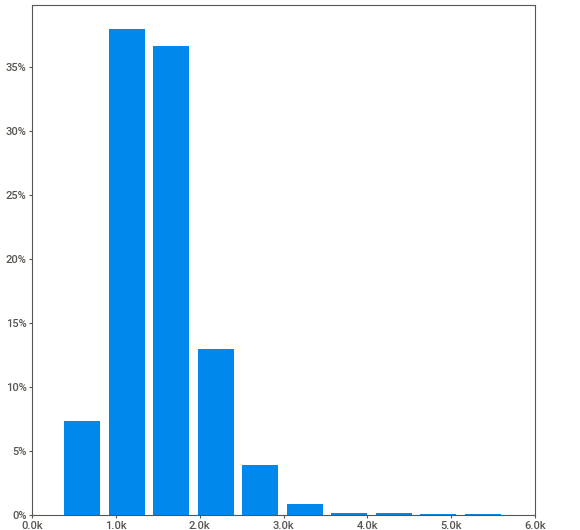
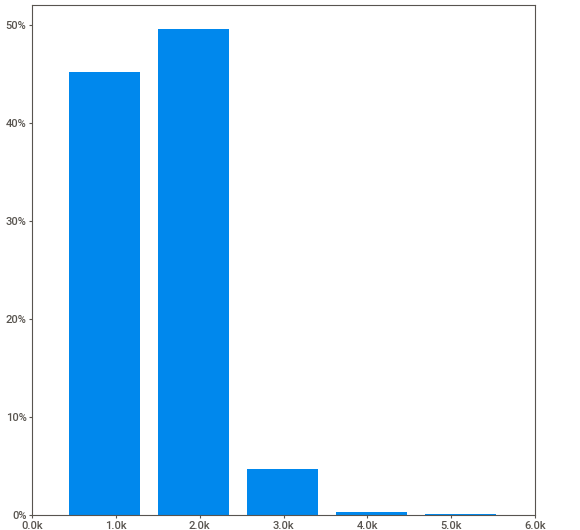
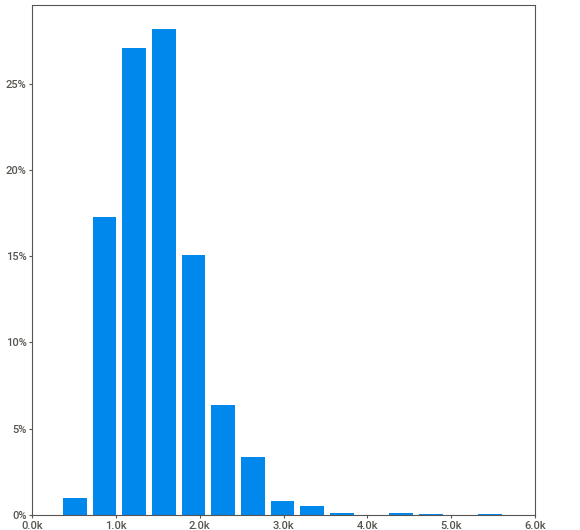
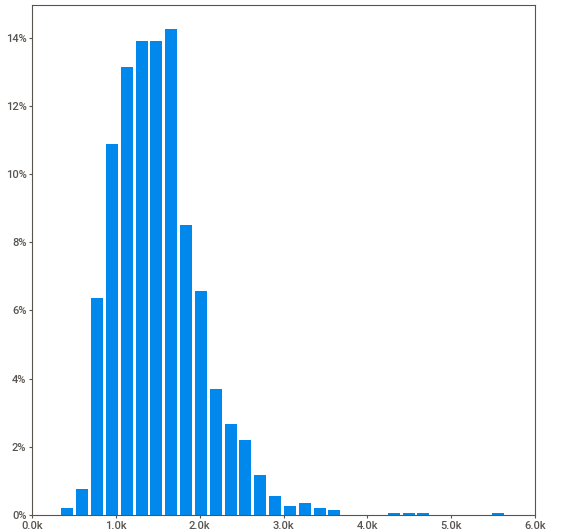
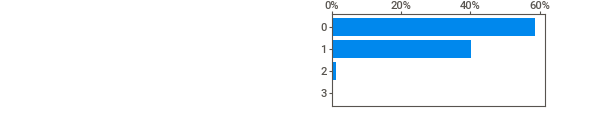
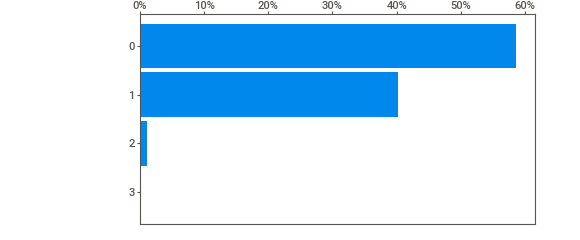
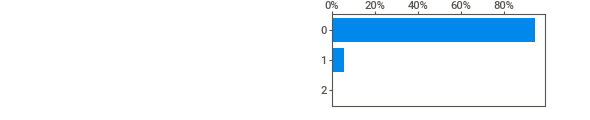
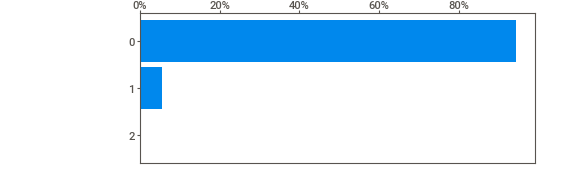
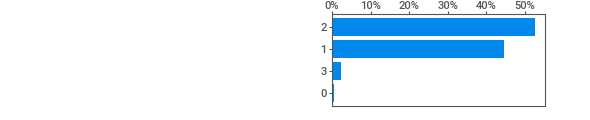
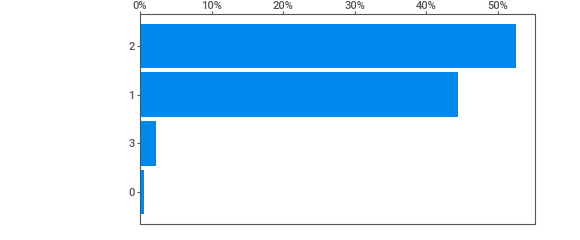
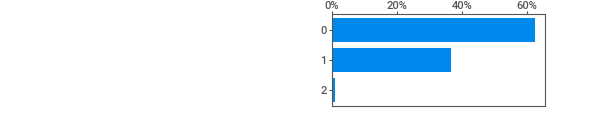
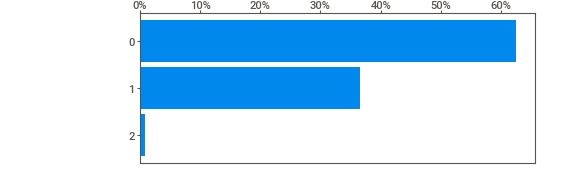
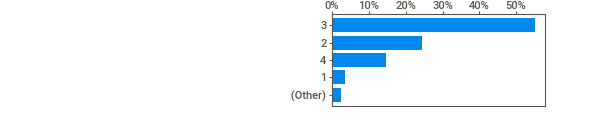
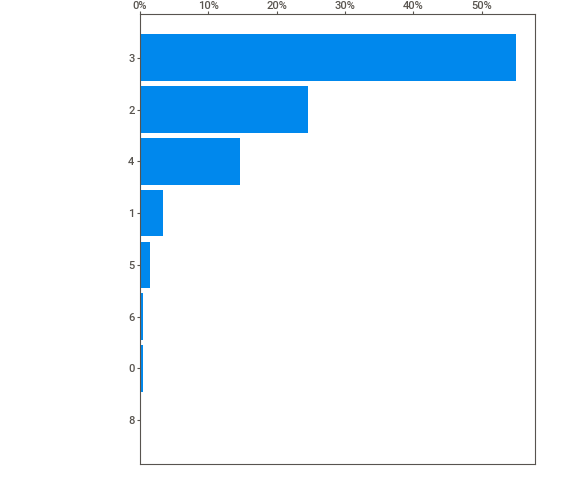
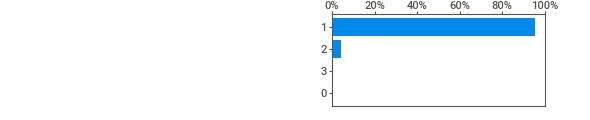
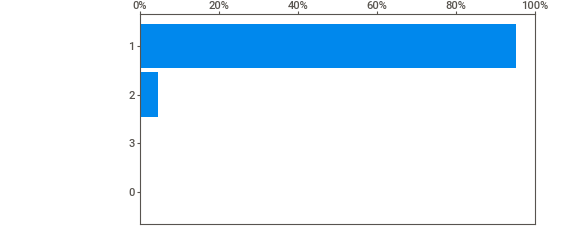
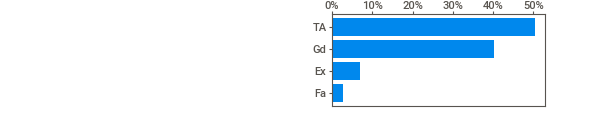
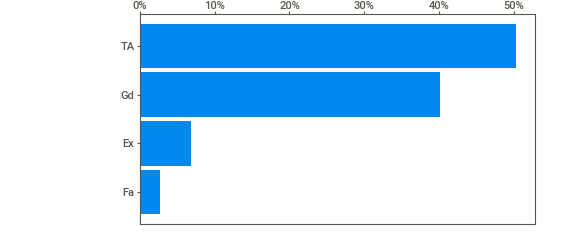
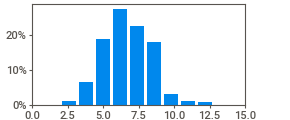
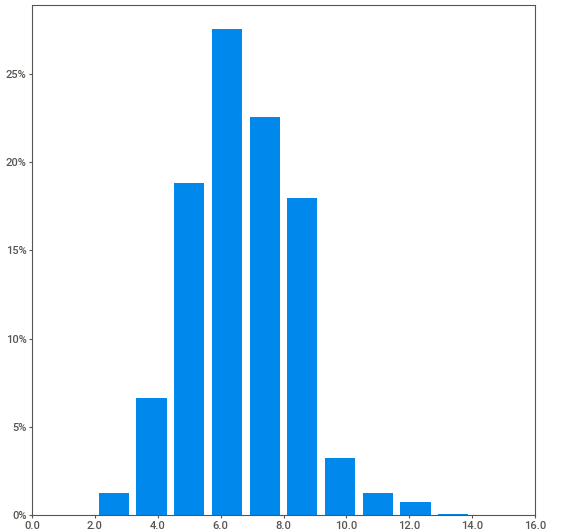
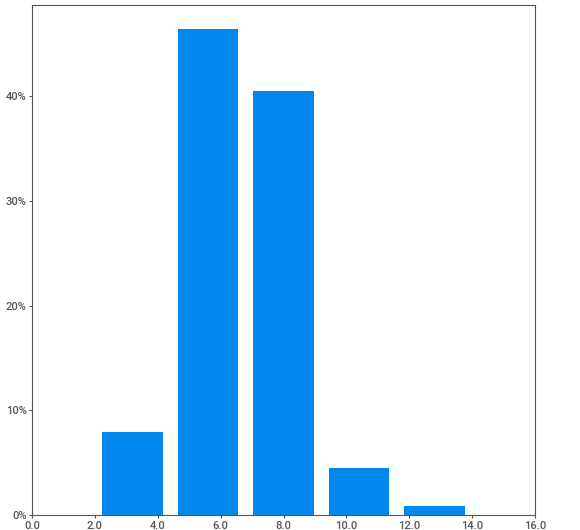
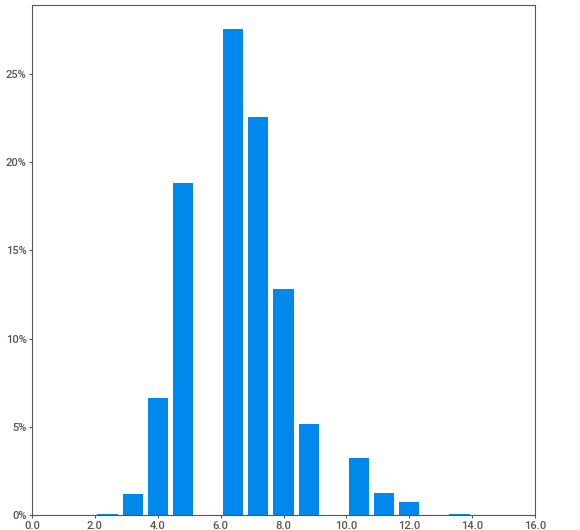
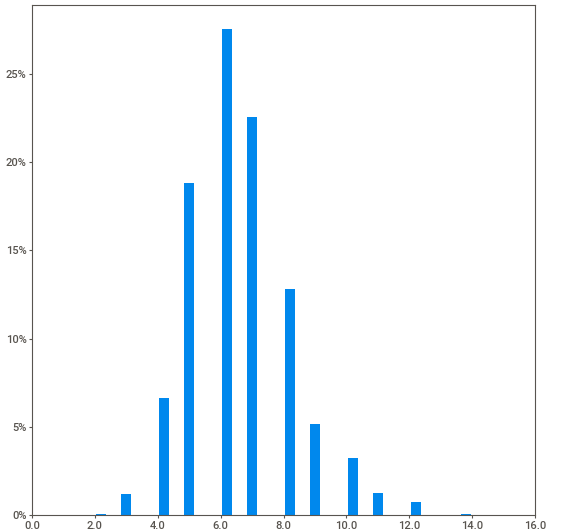
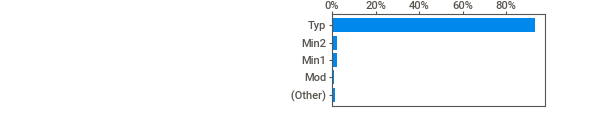
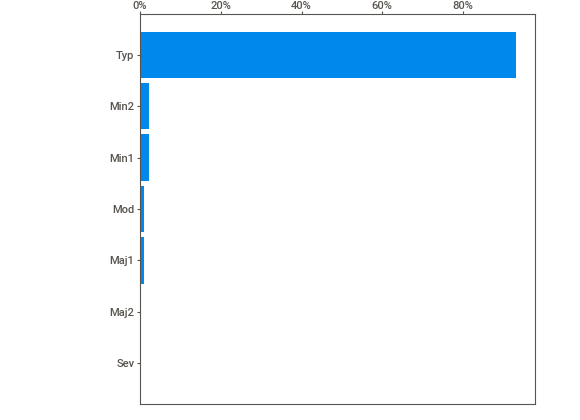
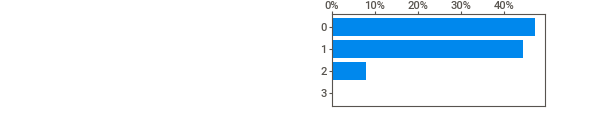
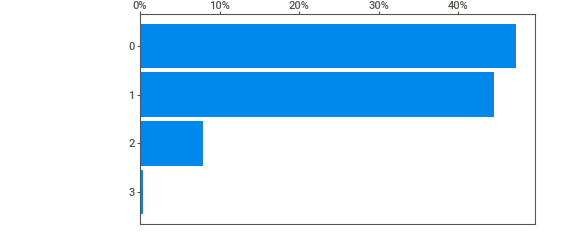
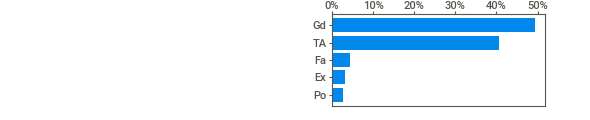
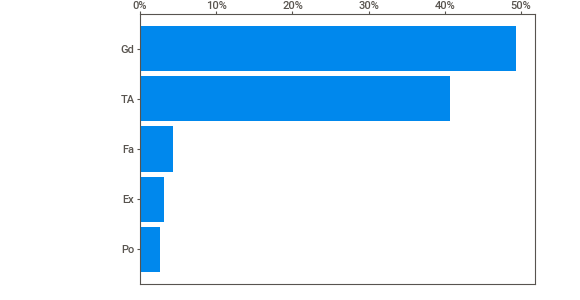
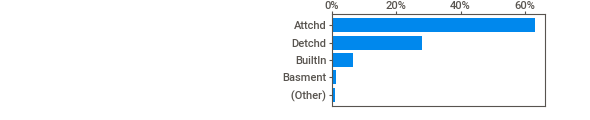
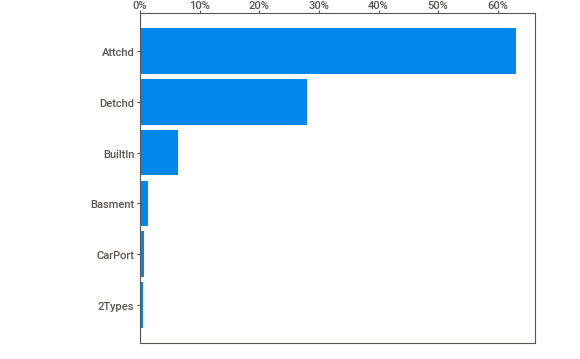
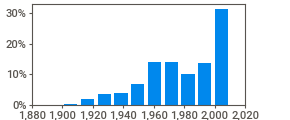
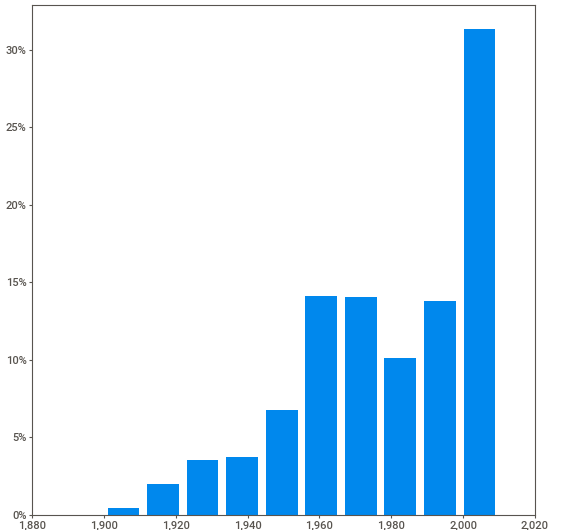
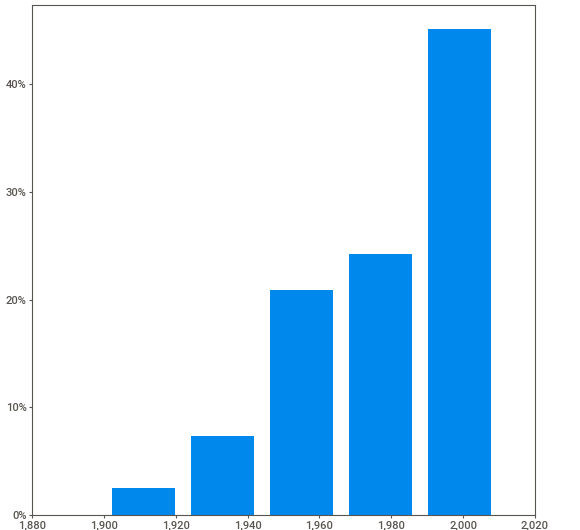
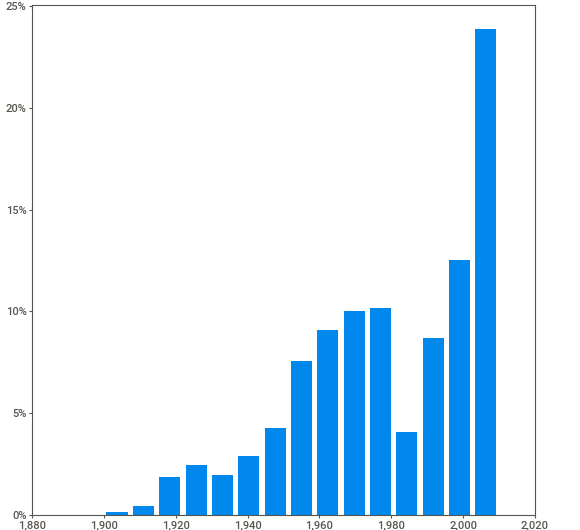
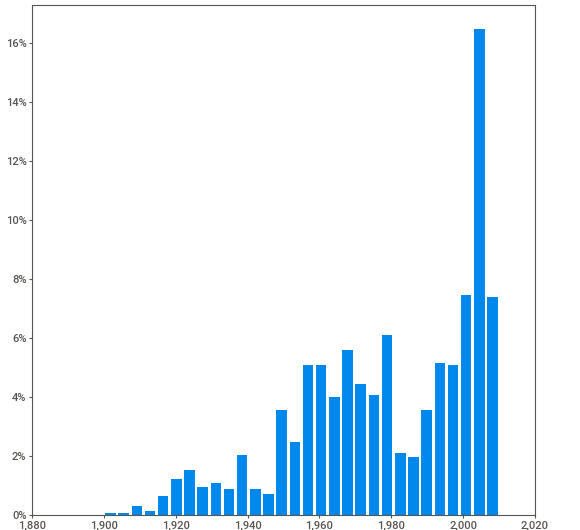
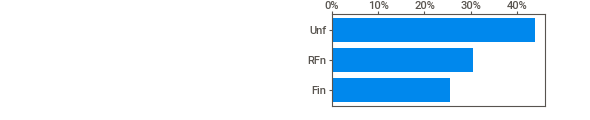
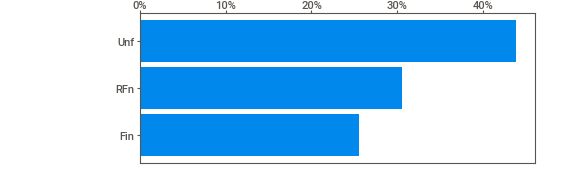
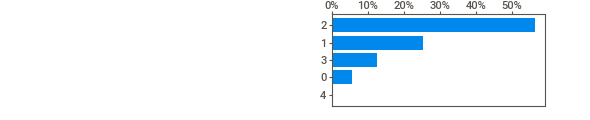
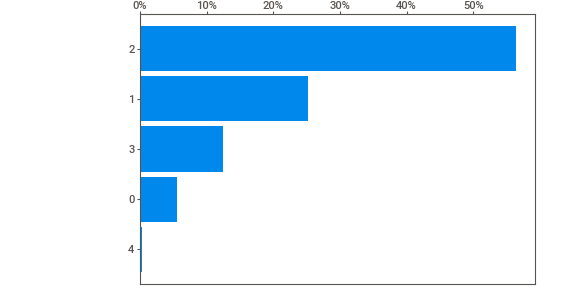
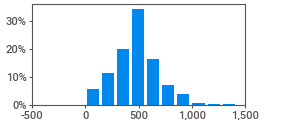
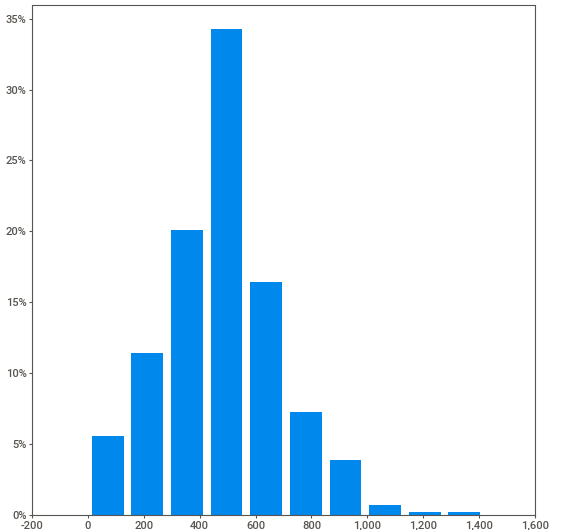
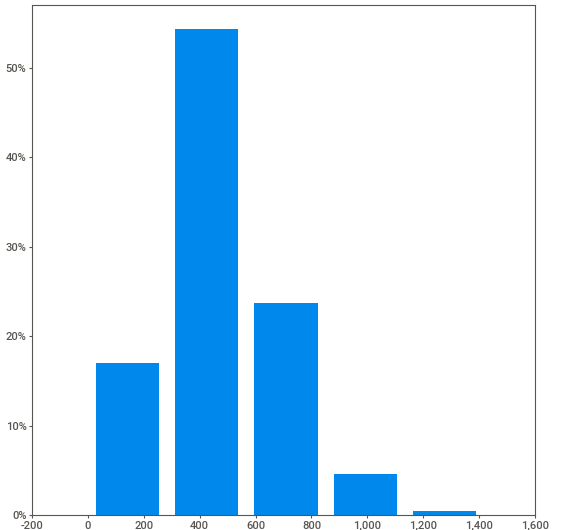
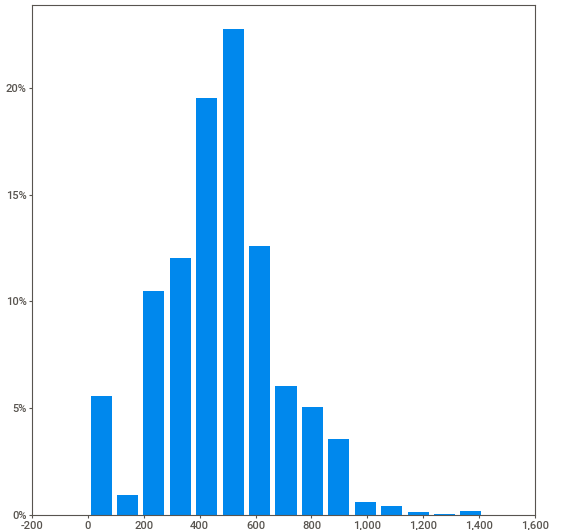
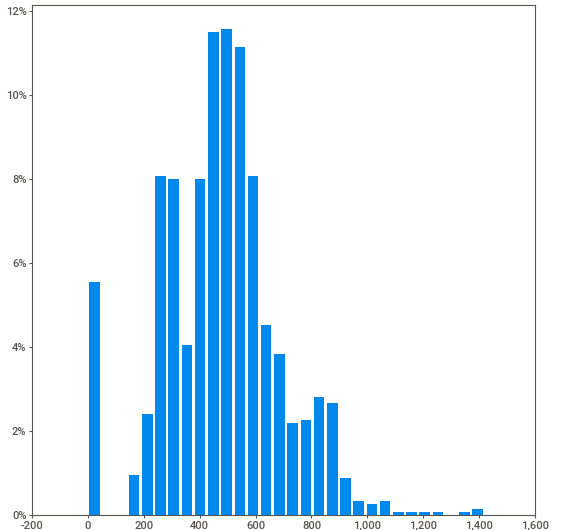
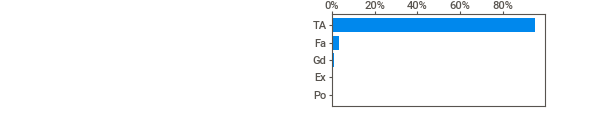
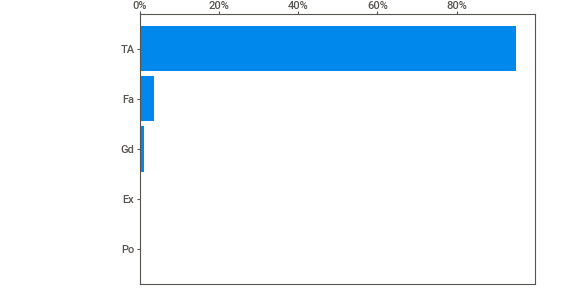
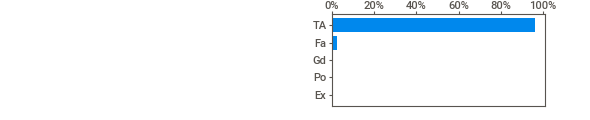
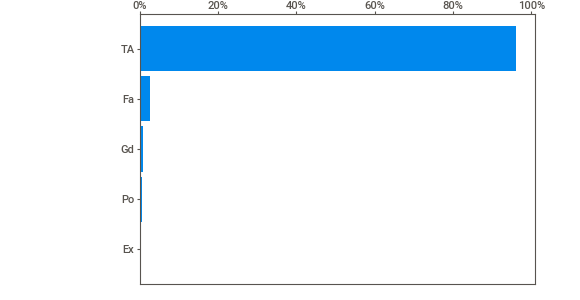
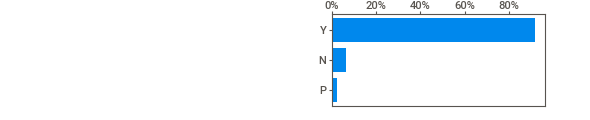
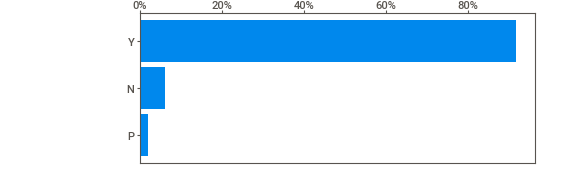
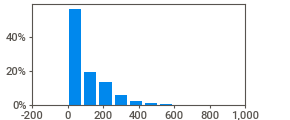
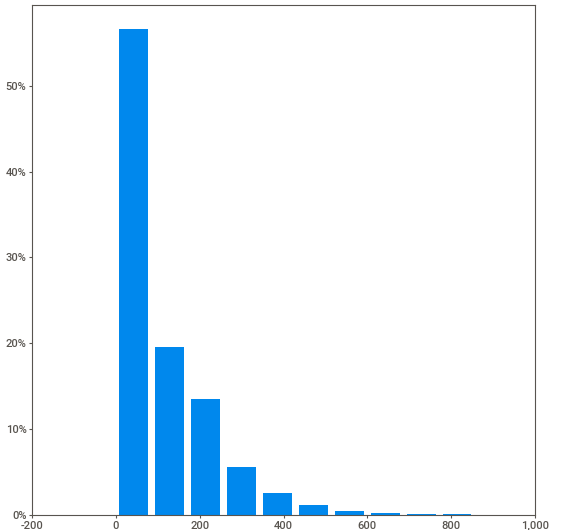
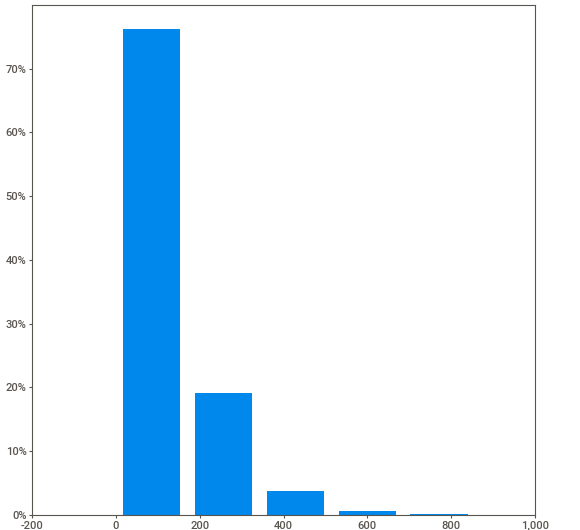
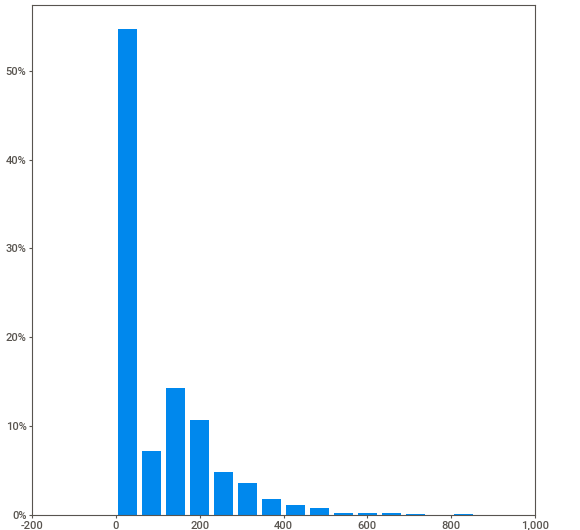
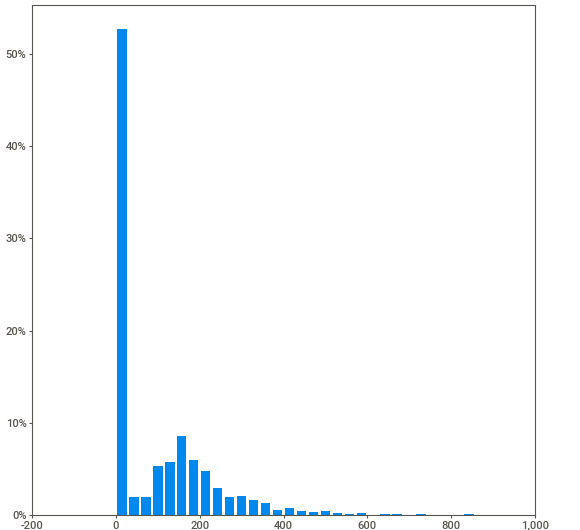
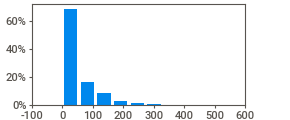
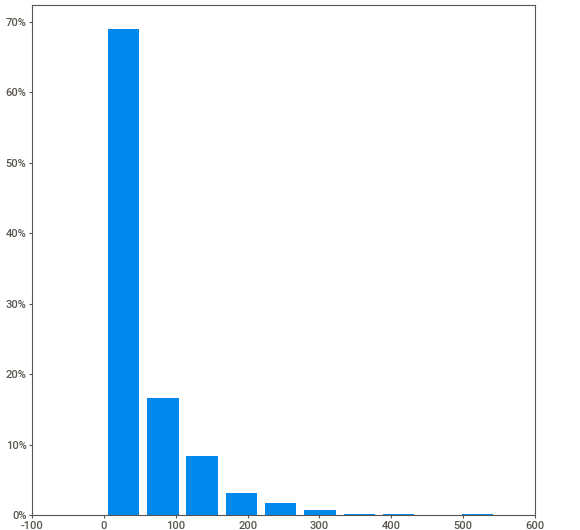
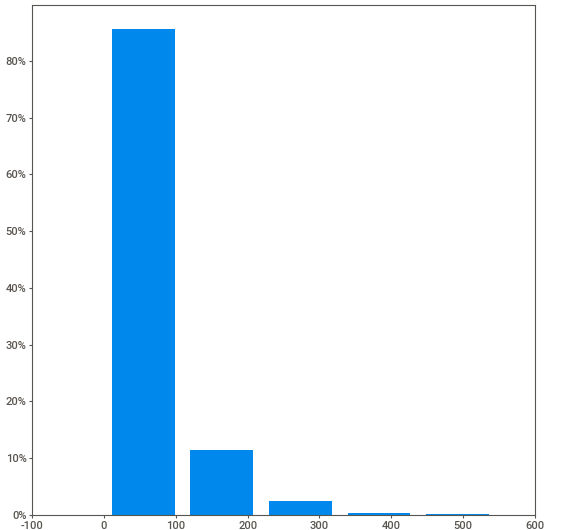
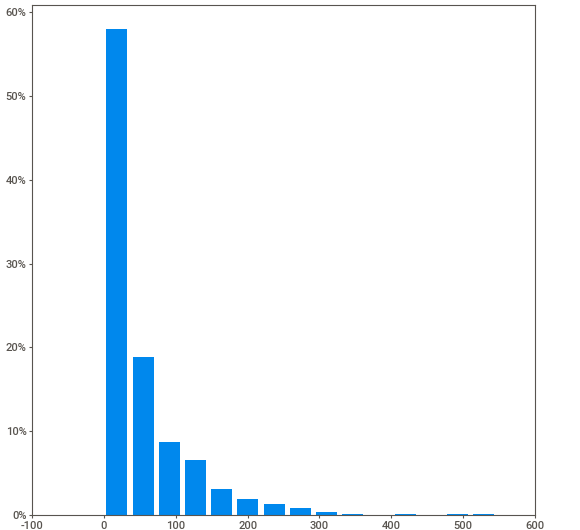
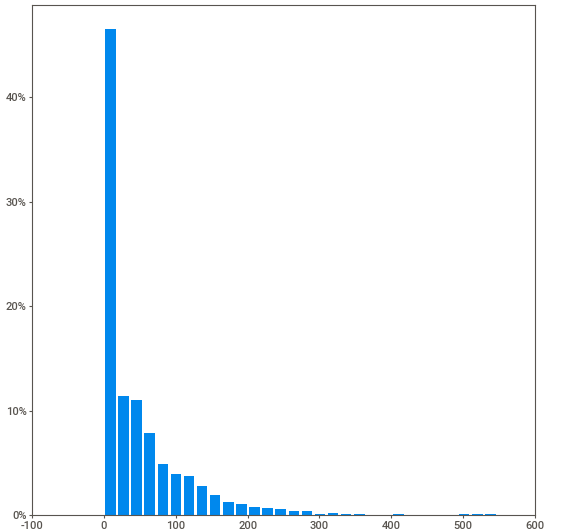
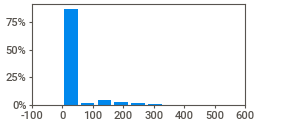
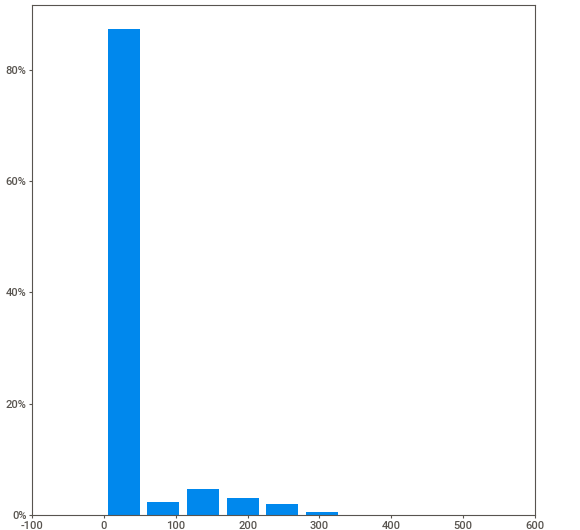
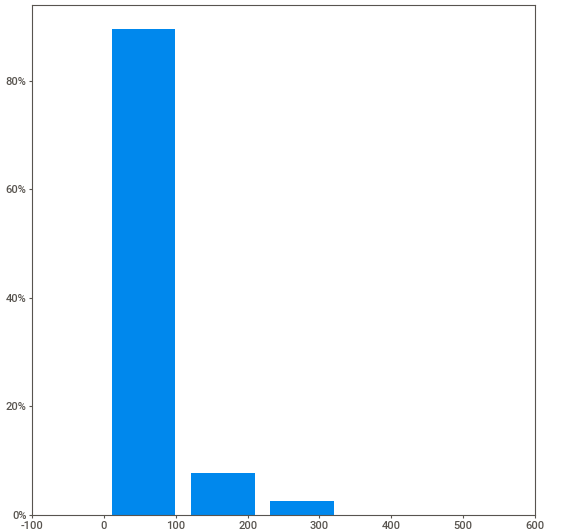
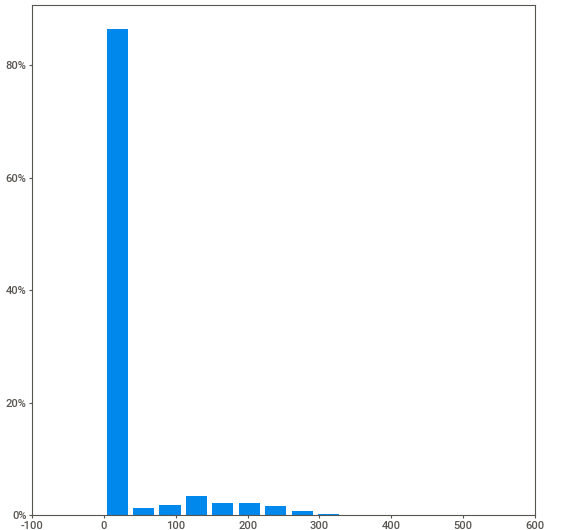
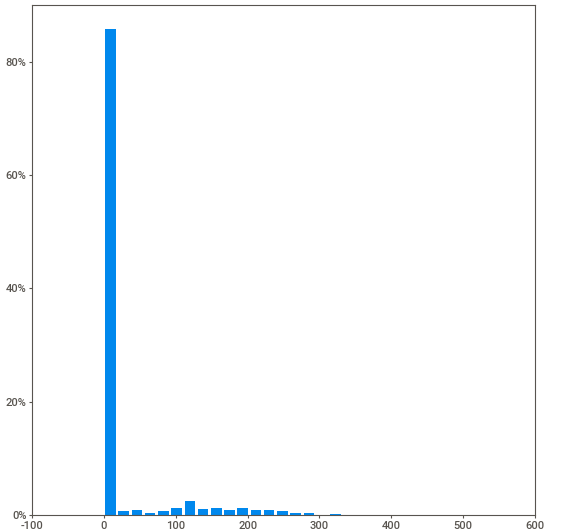
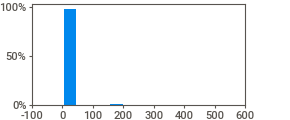
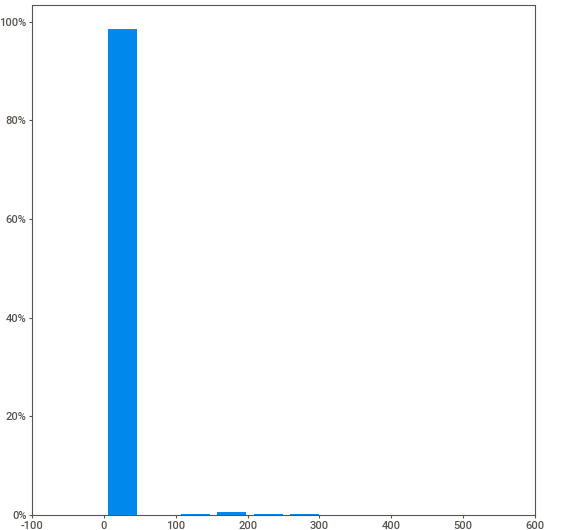
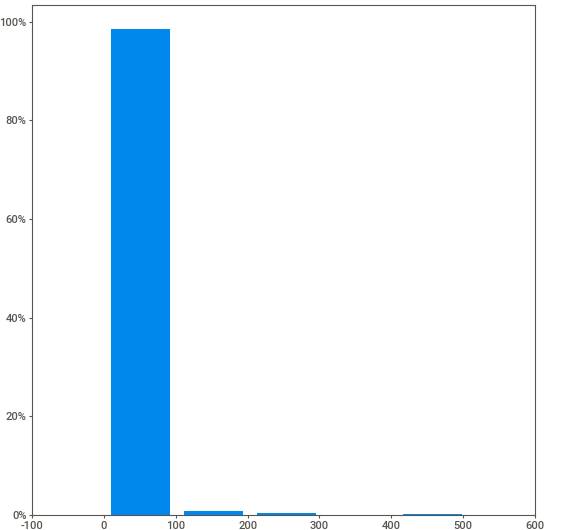
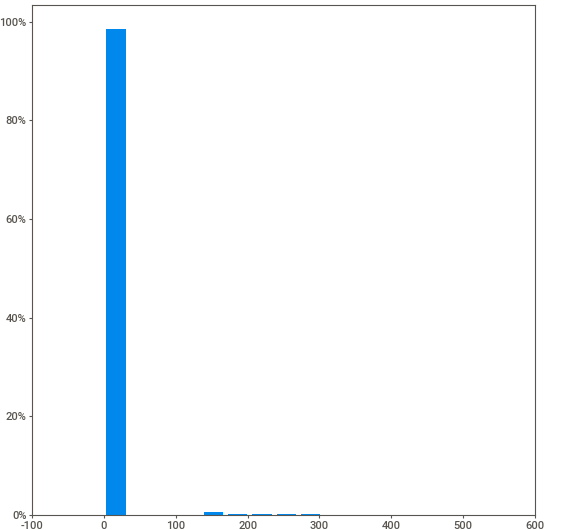
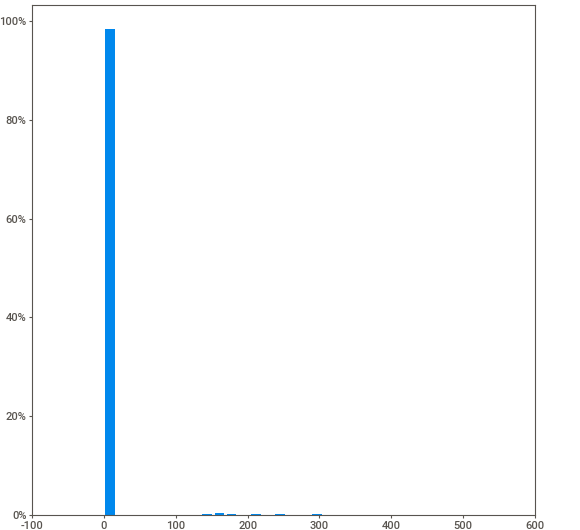
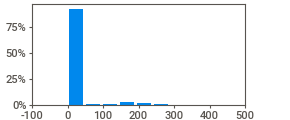
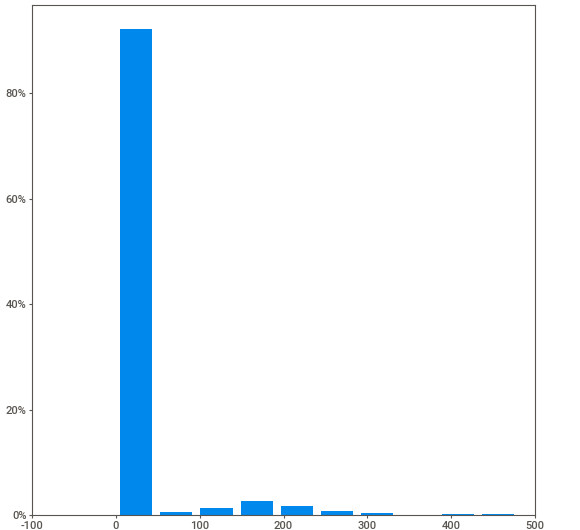
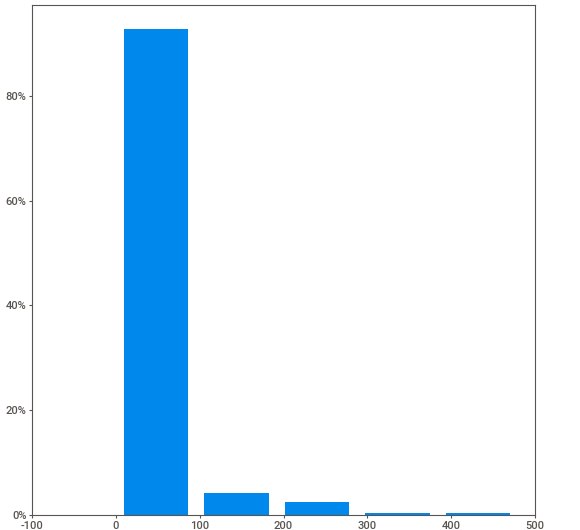
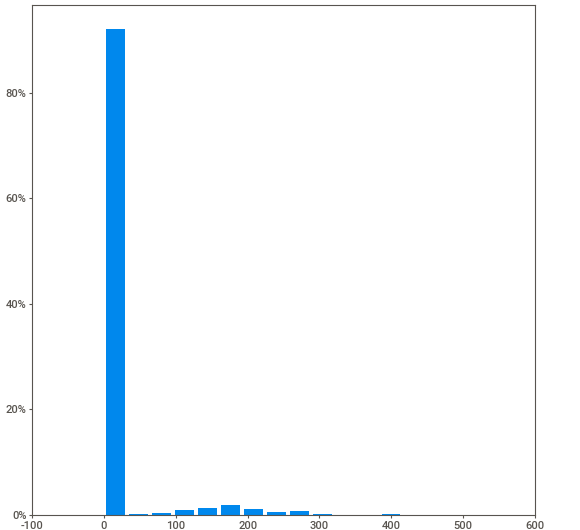
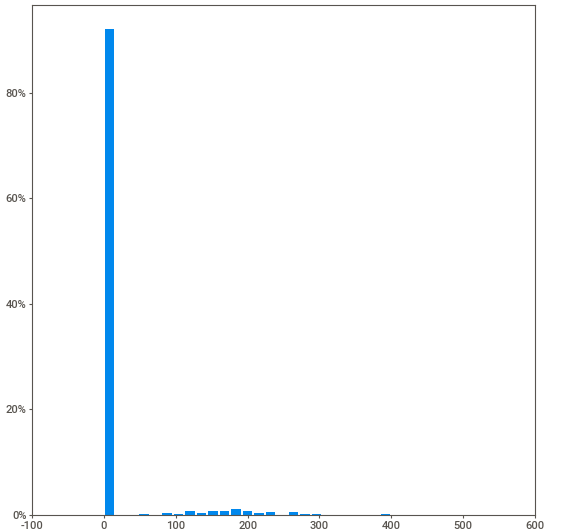
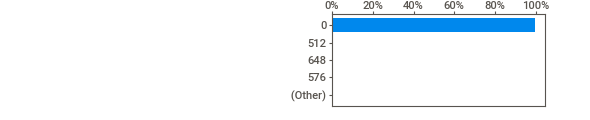
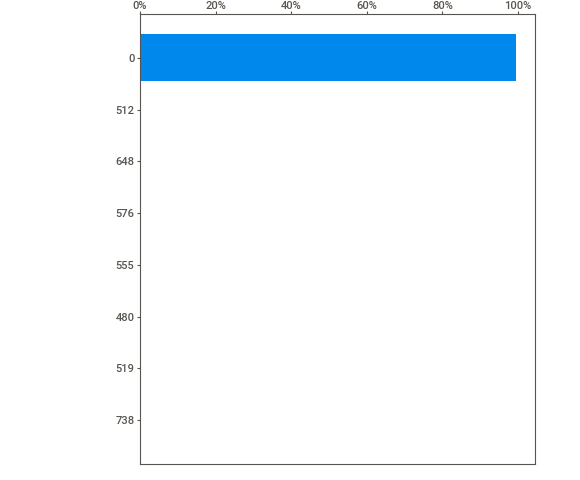
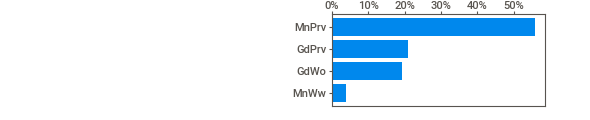
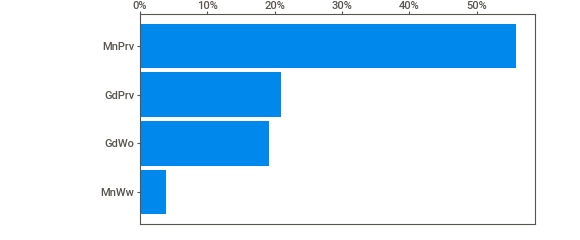
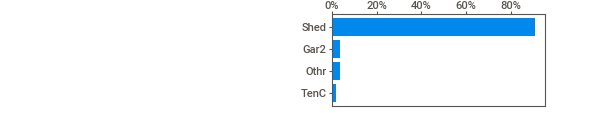
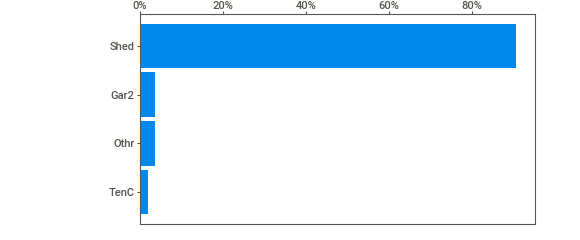
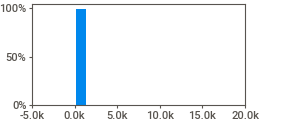
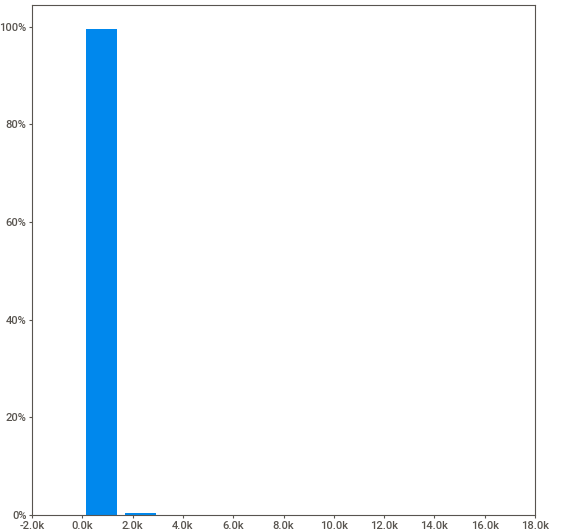
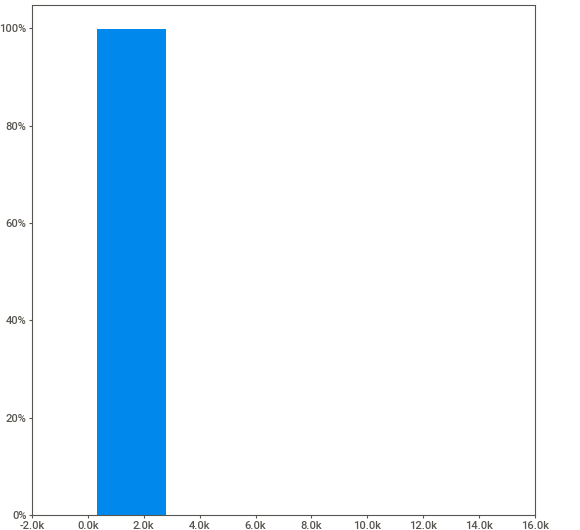
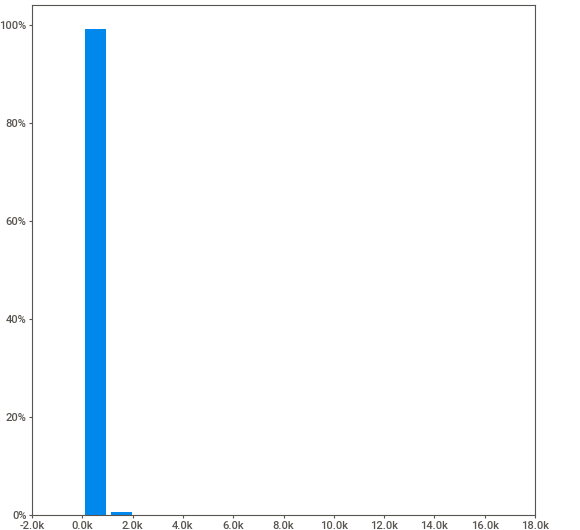
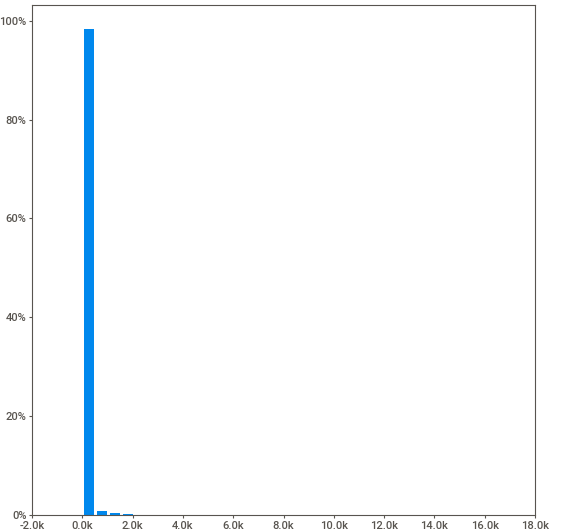
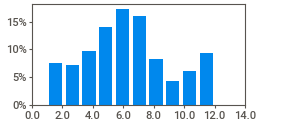
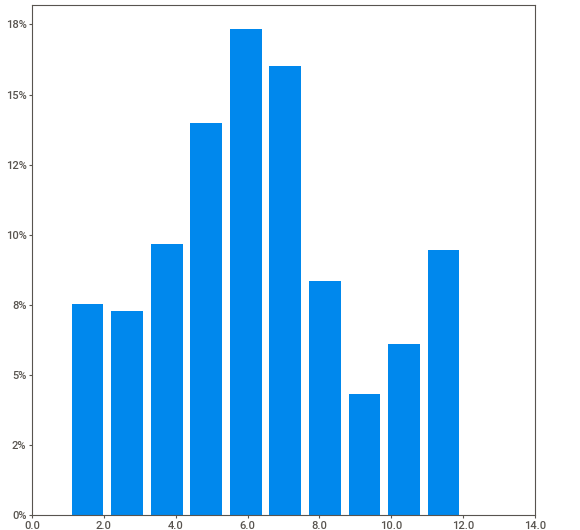
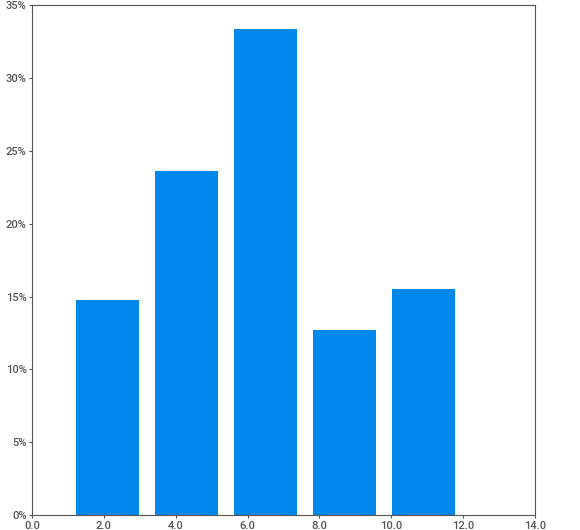
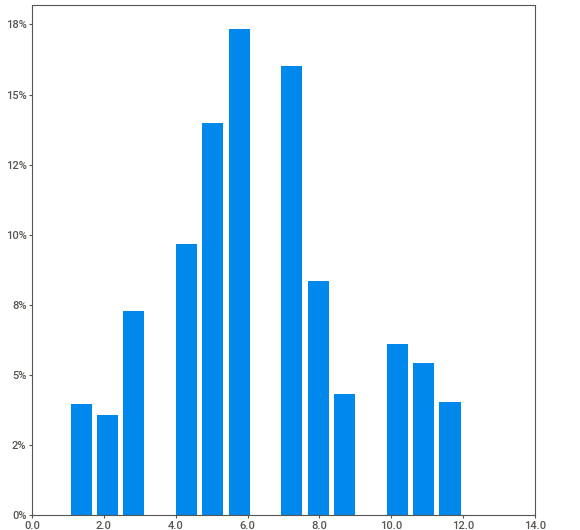
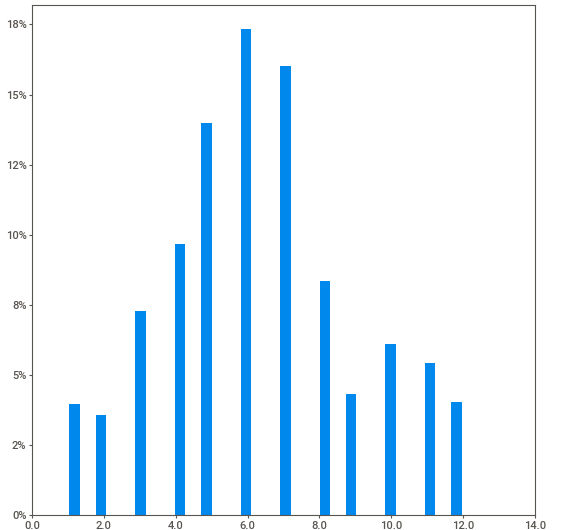
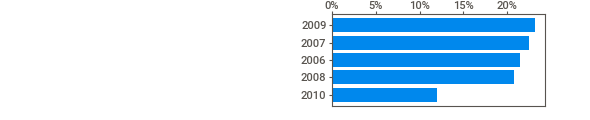
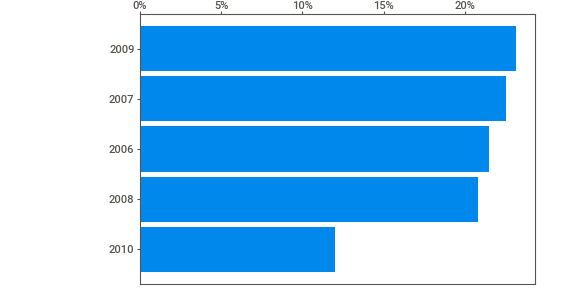
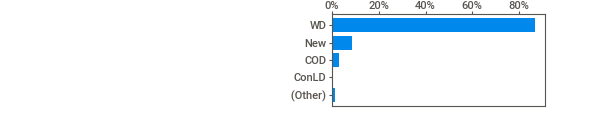
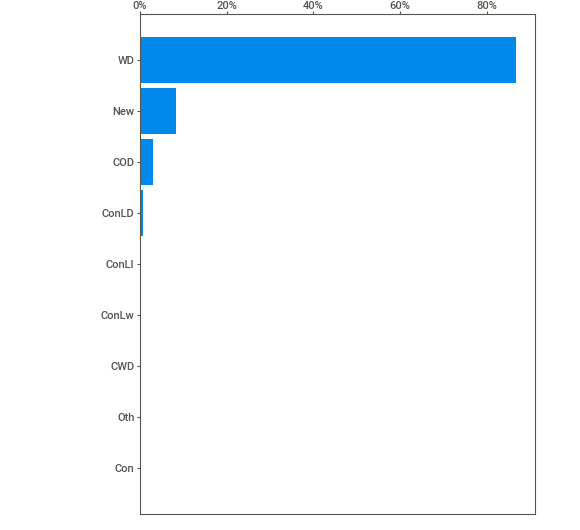
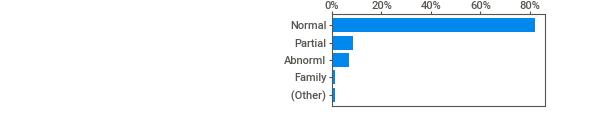
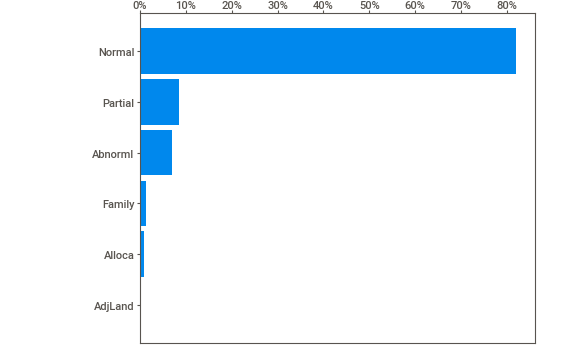
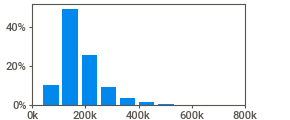
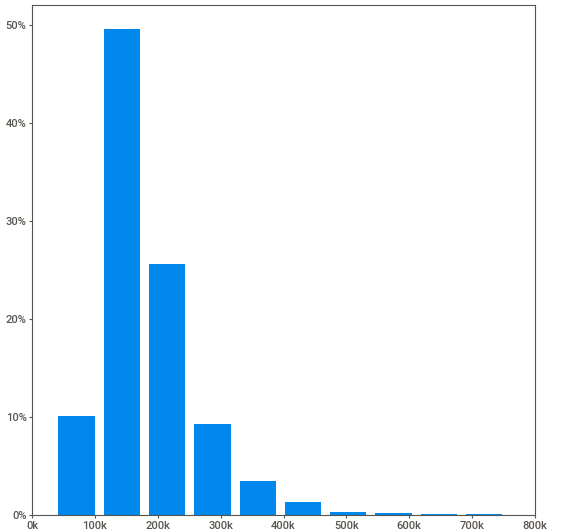
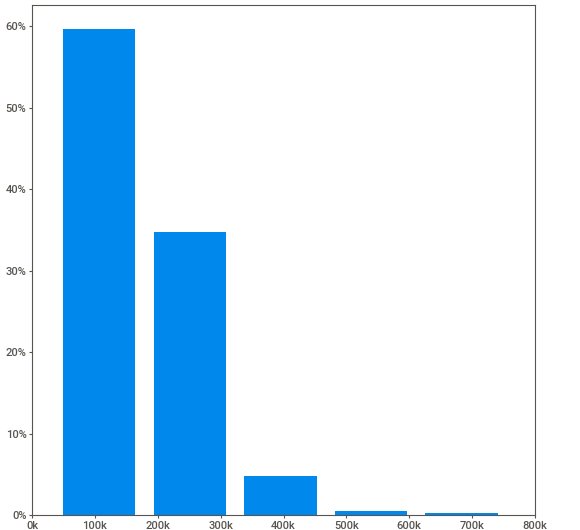
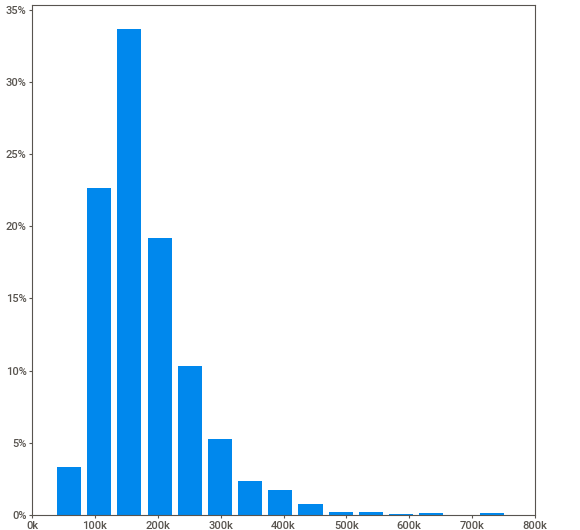
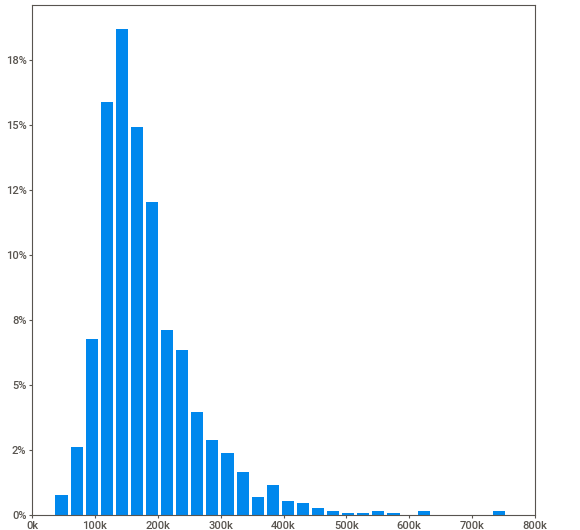
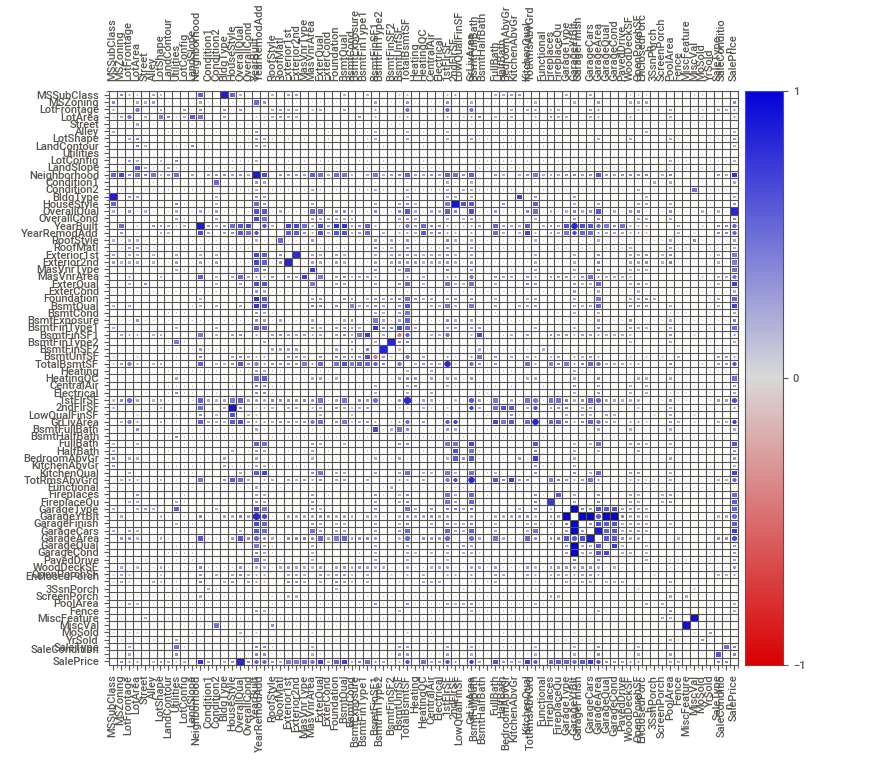
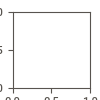

In [ ]:
House_pricing_report = sw.analyze(trainCSV)
House_pricing_report.show_notebook(layout='vertical')


# conclusion from the report

From the sweetviz reoprt i learnd the following:

Missing values in catagories:

  1. ***Alley-*** 1369/1460 rows missing
  2. ***FireplaceQu-*** 690/1460 rows missing
  3. ***PoolQc-*** 1453/1460 rows missing
  4. ***Fence-*** 1179/1460 rows missing
  5. ***MiscFeature-*** 1406/1460 rows missing

distinct catagories( >=90% fall into same catagories):

  1. ***Street-*** 99% = 'Pave'.
  2. ***LandContour-*** 90% = 'Lvl'.
  3. ***Condition2-*** 99% = 'Norm'.
  4. ***GarageQual-*** 95% = 'TA'.
  5. ***GarageCond-*** 96% = 'TA'.
  6. ***PavedDrive-*** 92% = 'Y'.
  7. ***3SsnPorch-*** 98.4% = 0.
  8. ***ScreenPorch-*** 92% = 0. 
  9. ***PoolArea-*** 99% = 0. 
  10. ***MiscVal-*** 96% = 0.
  11. ***Utilities-*** 99% = 'AllPub'. 
  12. ***Heating-*** 99% = 'GasA'.

In genral we have a lot of features we can screen throw.

lets decide that we will dop every feature the meet the following:
  1. Missing values >= 40%.
  2. Distinct catagories >=85% fall into same catagories.
  3. correlation threshold- 0.3 with 'SalePrice' 


In [ ]:
# Dropping columns
def dropWeakCorrelation(df, targetColume, corTarget):
  corr_colume_dict = np.abs(df.corr())[targetColume].items()
  drop_list = []

  for col_name, val in corr_colume_dict:
    if val < corTarget:
      drop_list.append(col_name)
  df.drop(columns = drop_list, axis = 1, inplace = True)


def dropMissingValCols(df, valThreshold):
  number_of_rows = len(df)
  drop_list = []

  for col in df.columns:
    if (df[col].isnull().sum() / number_of_rows) > valThreshold:
      drop_list.append(col)
  df.drop(columns = drop_list, axis = 1, inplace = True)


def dropDistinctOnThreshold(df, valThreshold):
  number_of_rows = len(df)
  drop_list = []
  for col in df.columns:
    highest_freq_val = df[col].mode()[0]
    appearance_num = (df[col] == highest_freq_val).sum()
    if (appearance_num / number_of_rows) > valThreshold:
      drop_list.append(col)
  df.drop(columns = drop_list, axis = 1, inplace = True)


In [ ]:
dropMissingValCols(trainCSV, 0.4)
dropDistinctOnThreshold(trainCSV, 0.85)
dropWeakCorrelation(trainCSV, "SalePrice", 0.3)

                                             |          | [  0%]   00:00 -> (? left)


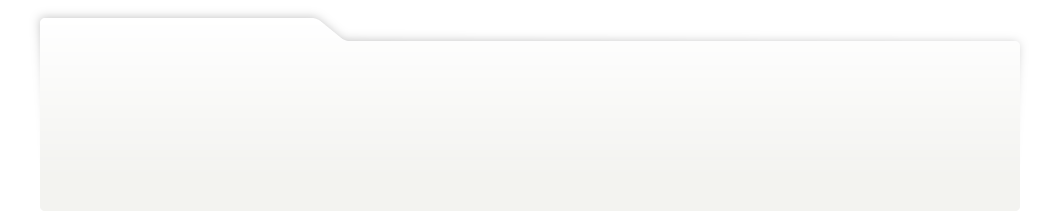
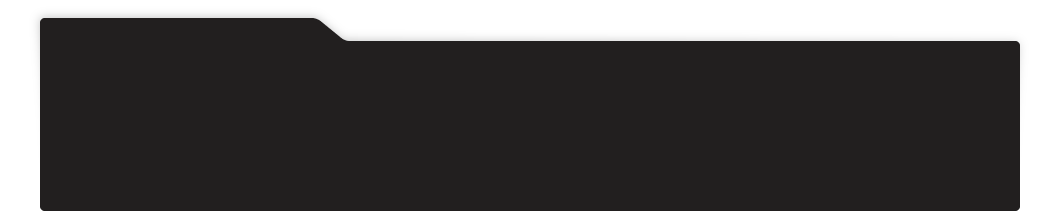
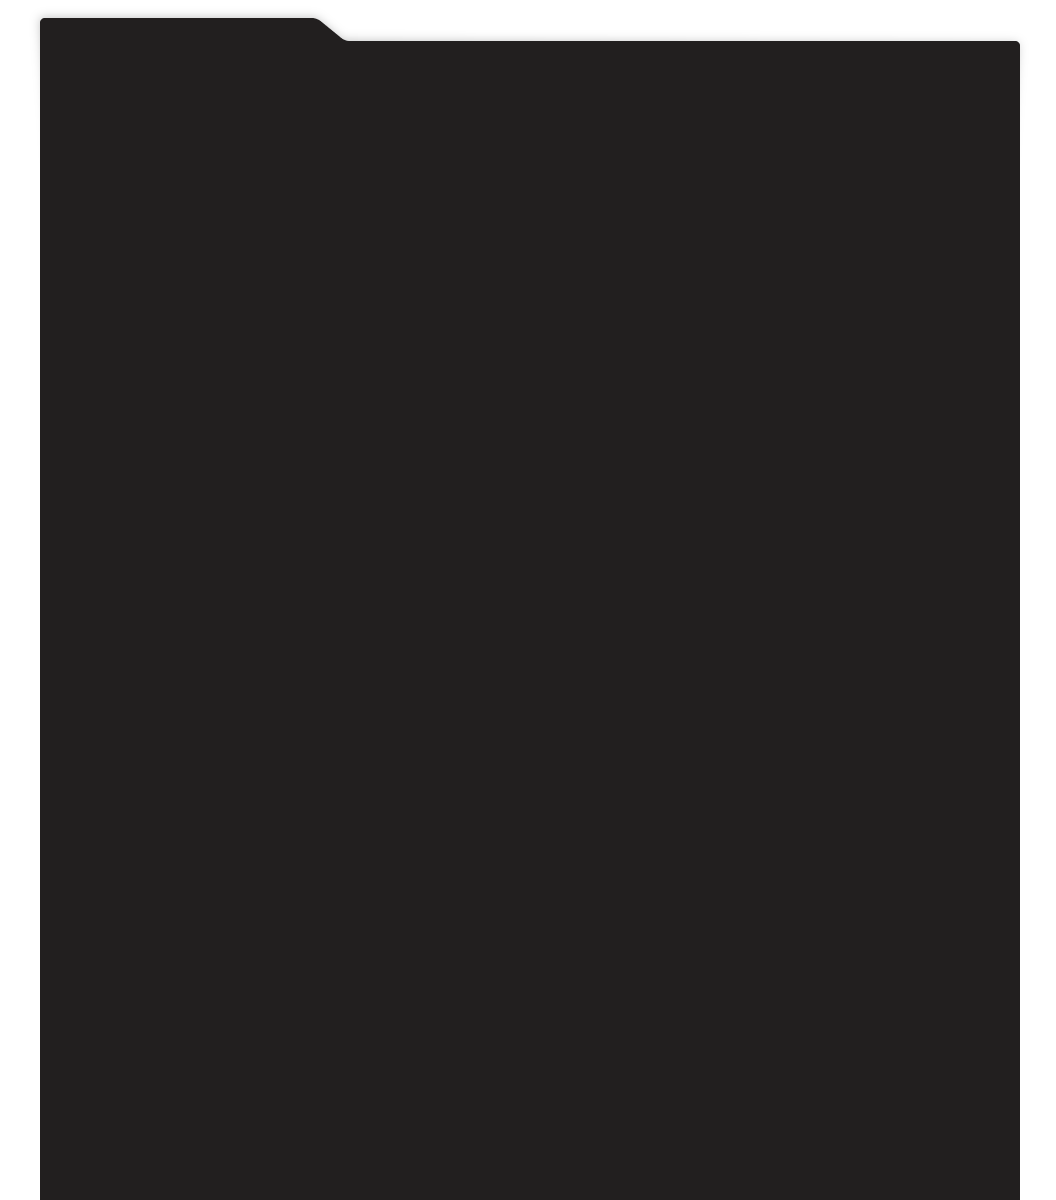
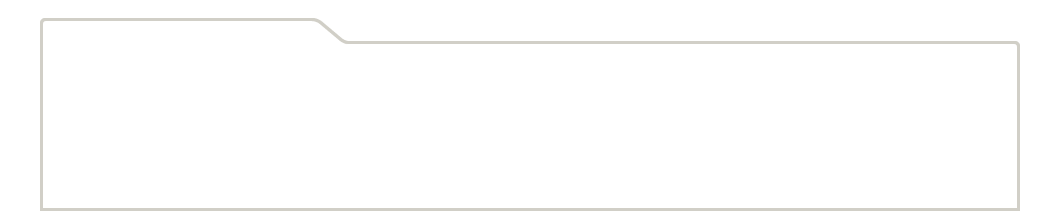
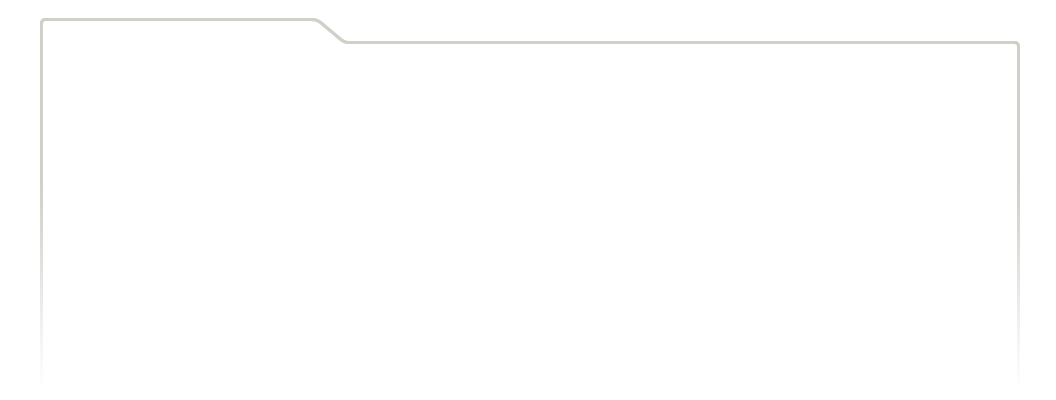
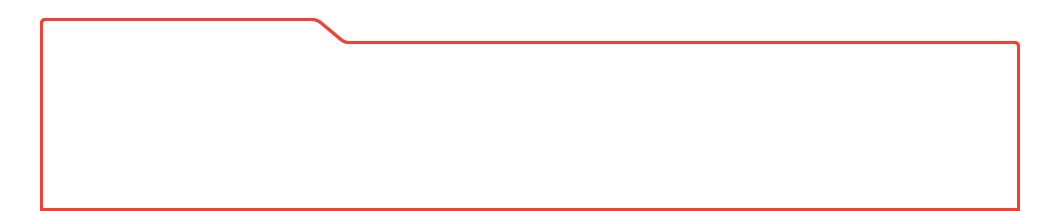
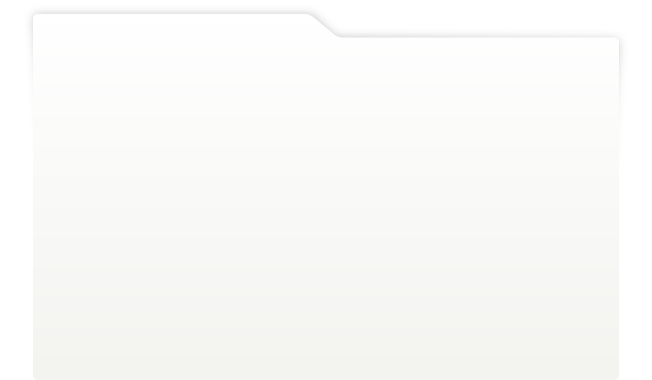
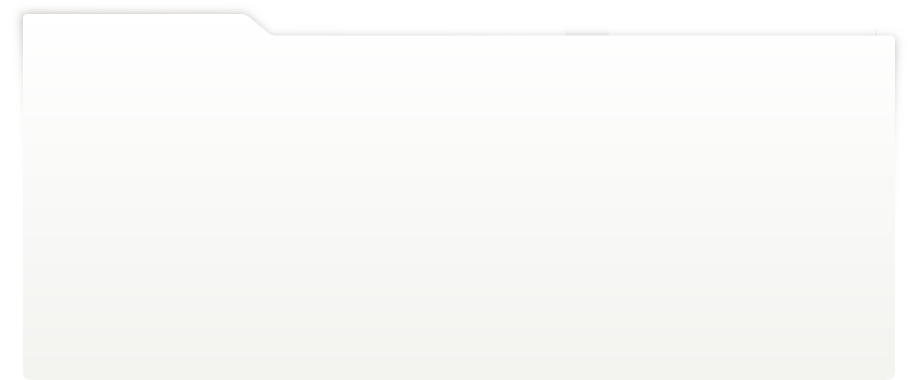
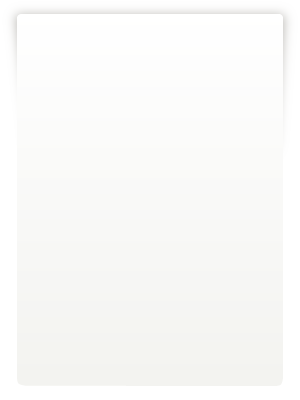
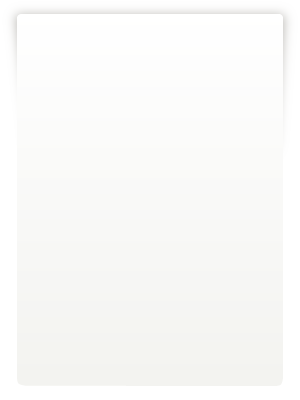
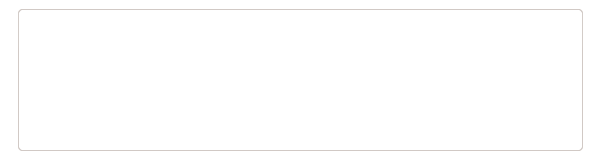
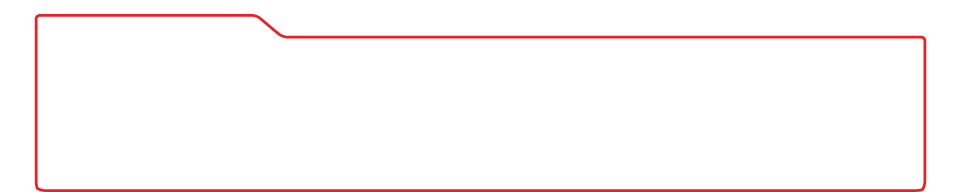
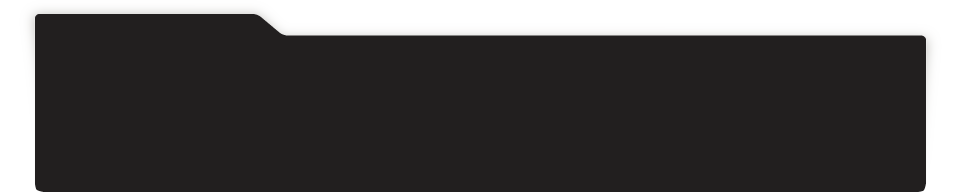
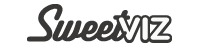
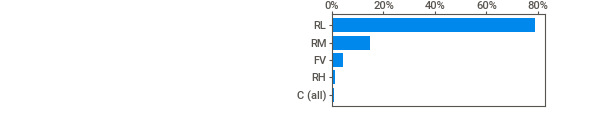
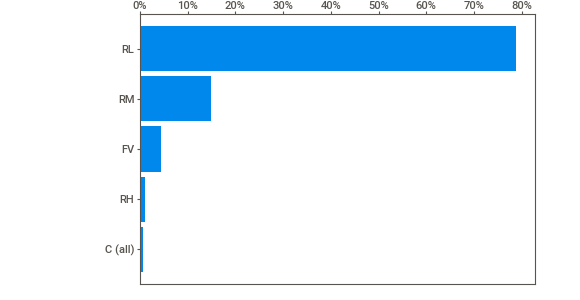
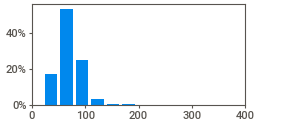
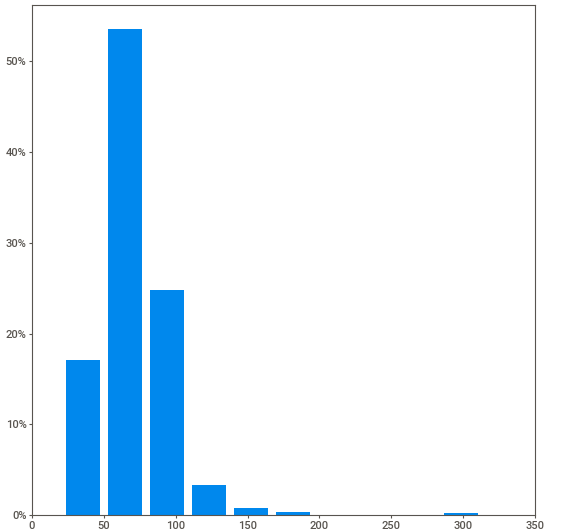
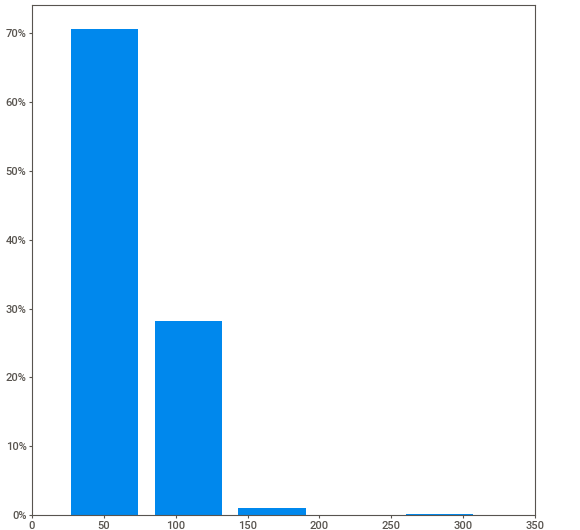
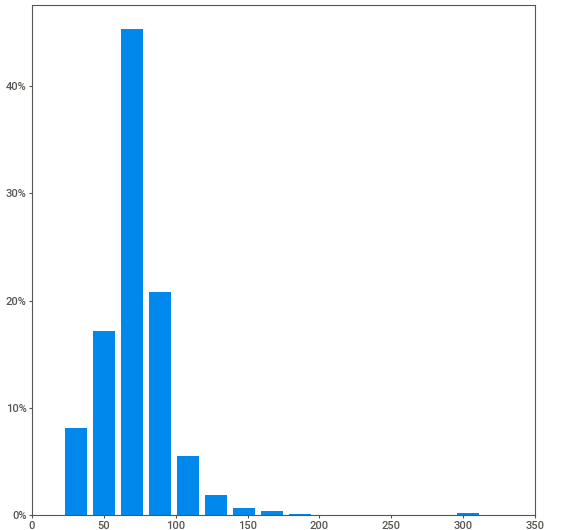
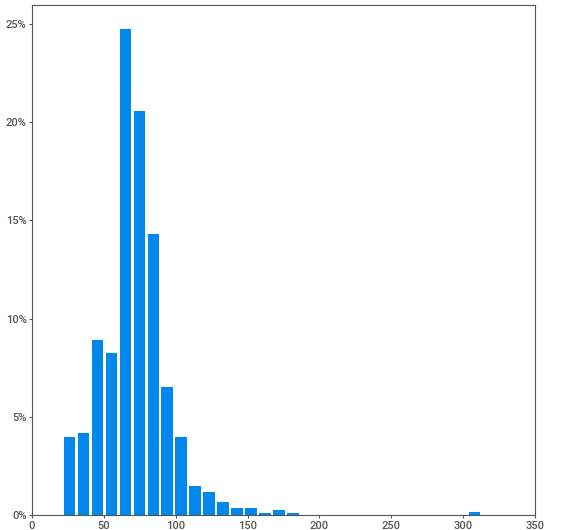
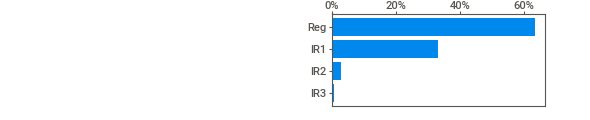
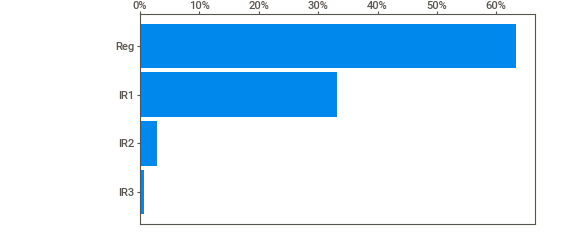
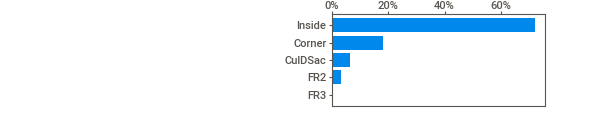
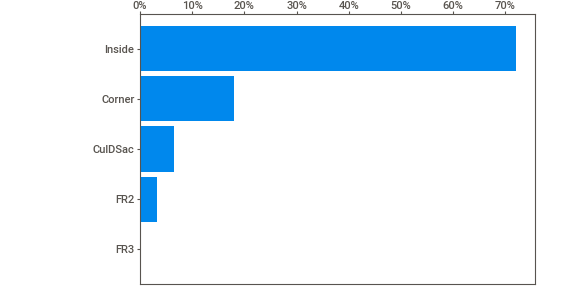
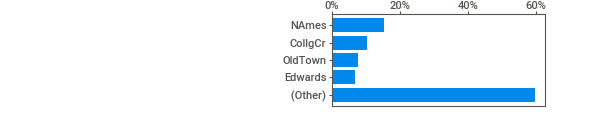
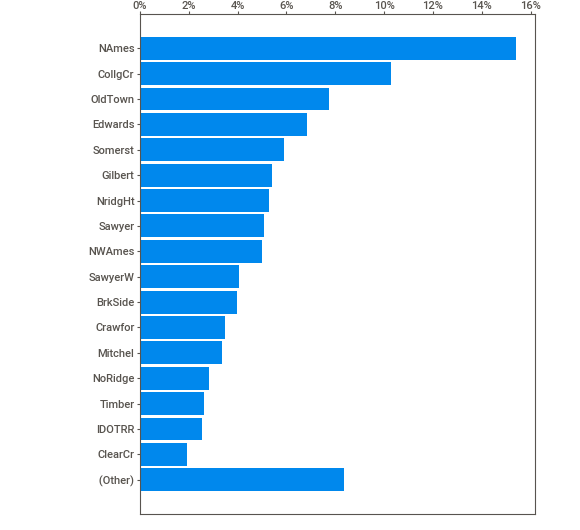
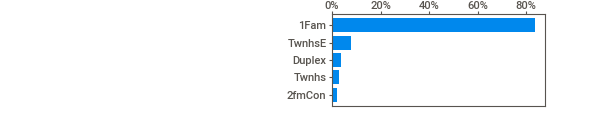
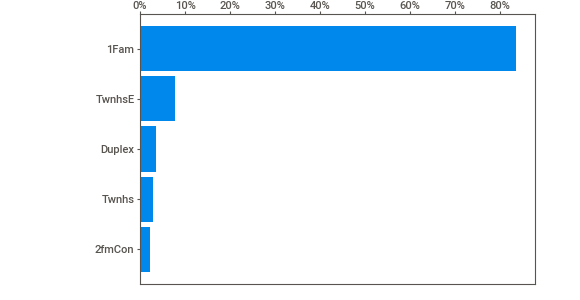
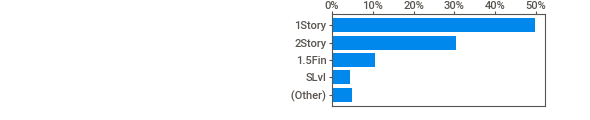
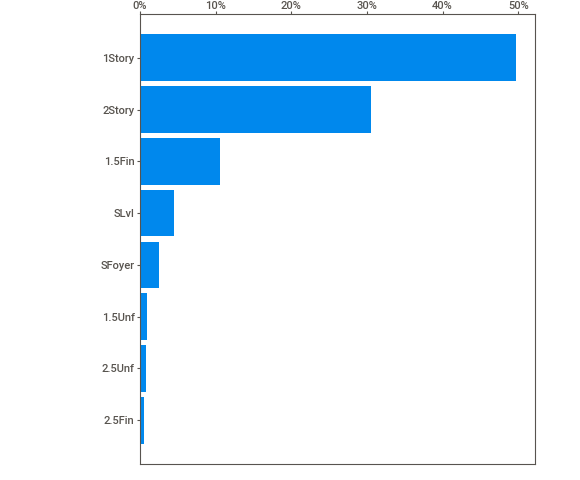
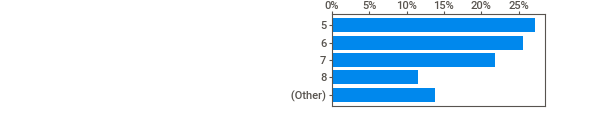
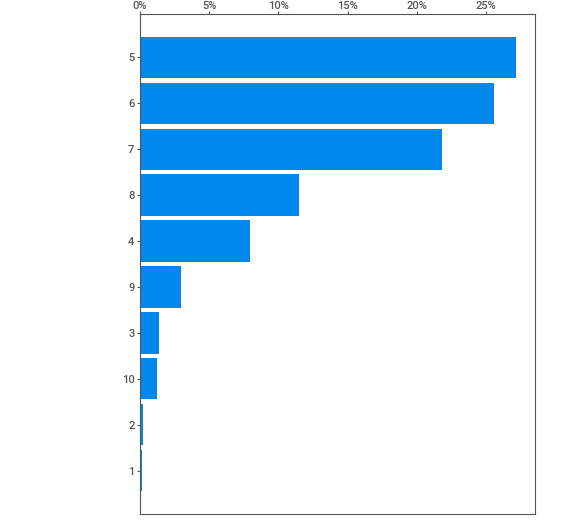
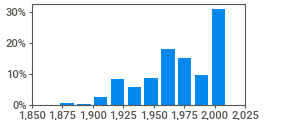
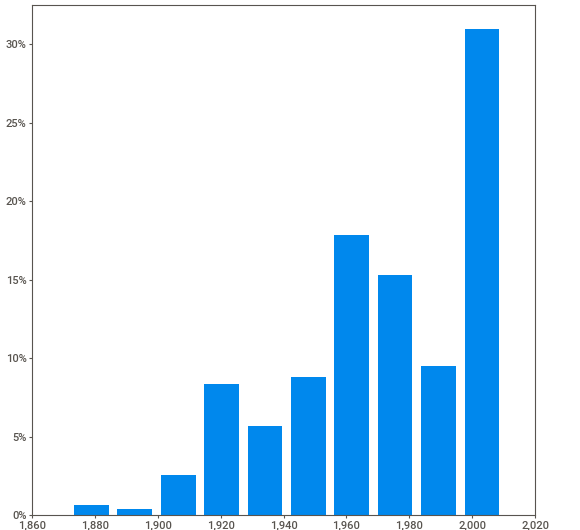
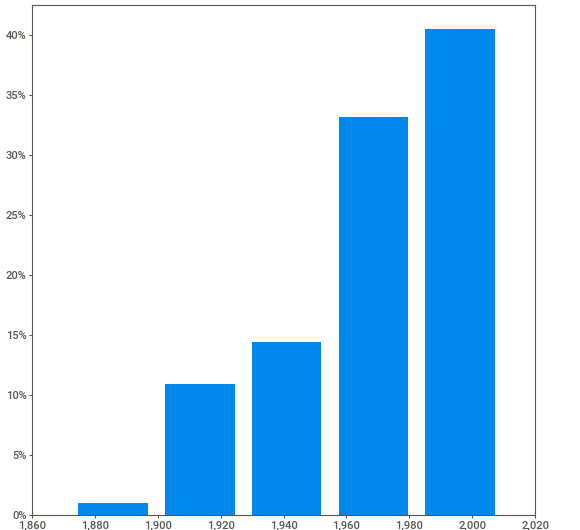
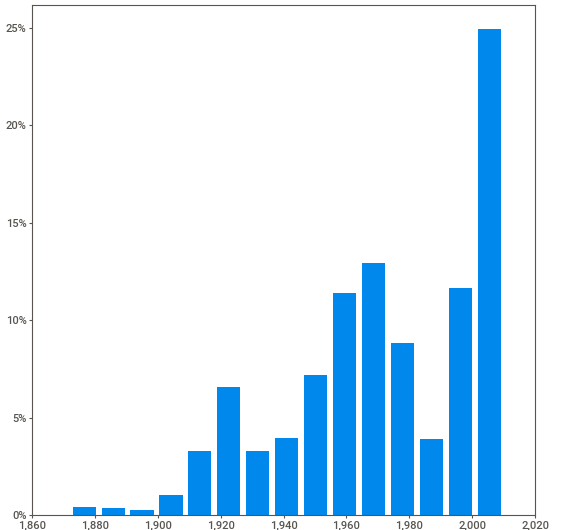
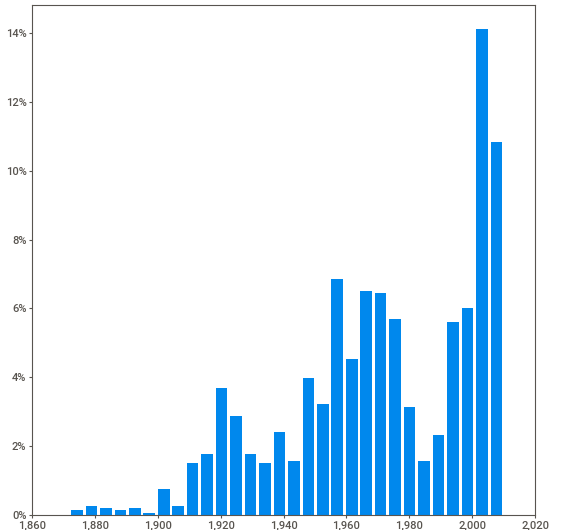
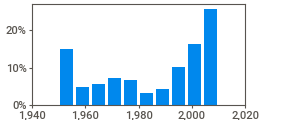
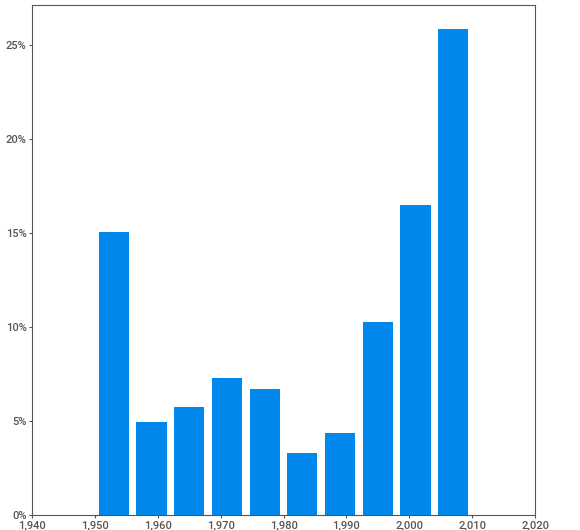
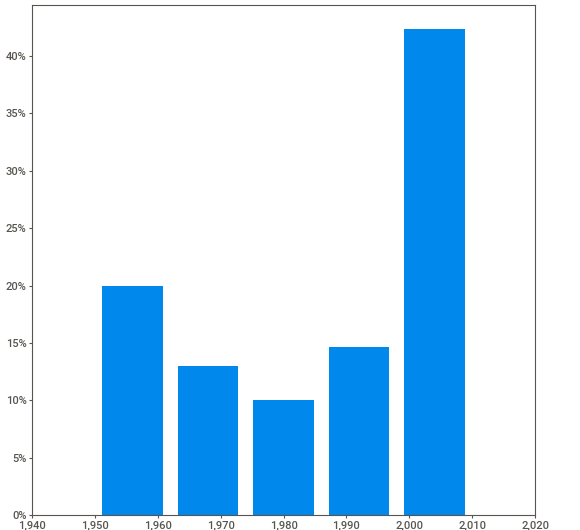
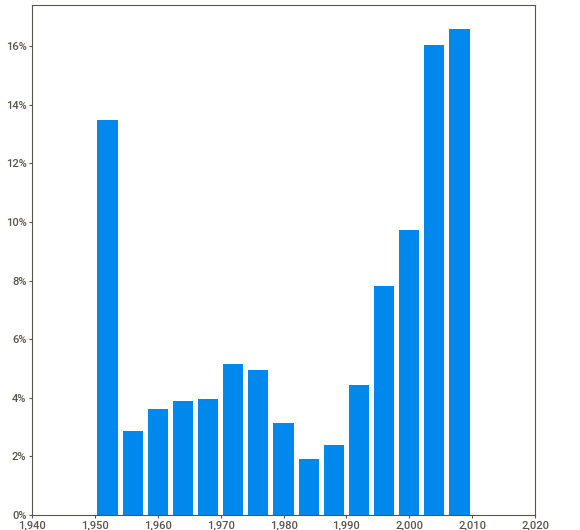
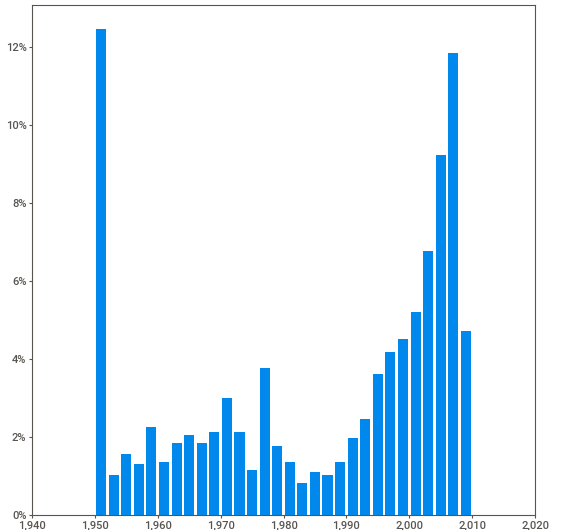
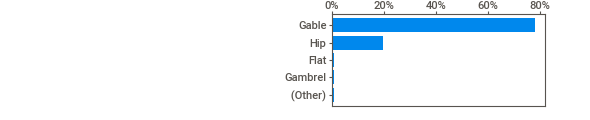
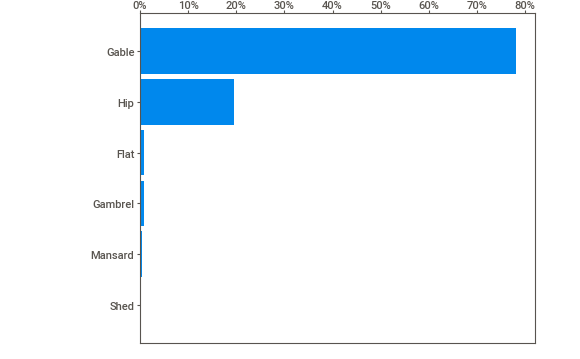
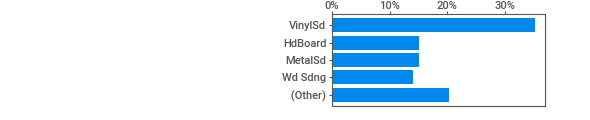
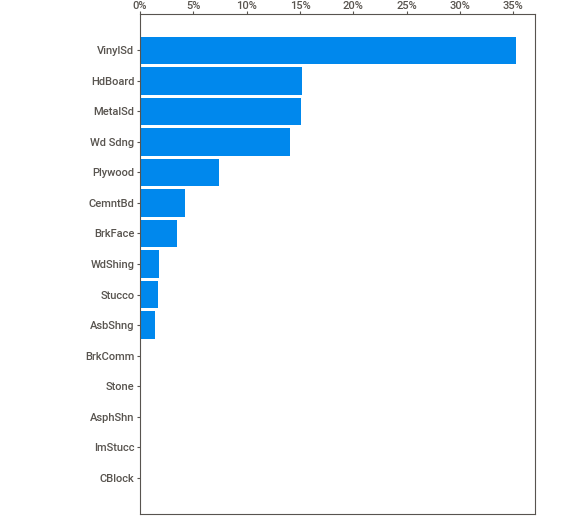
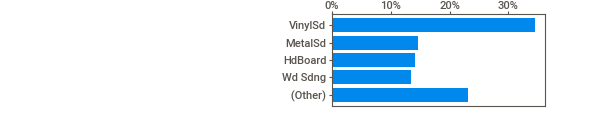
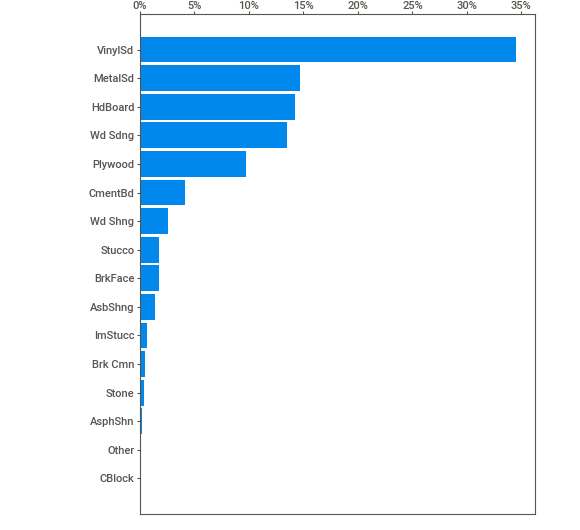
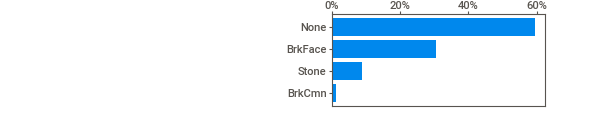
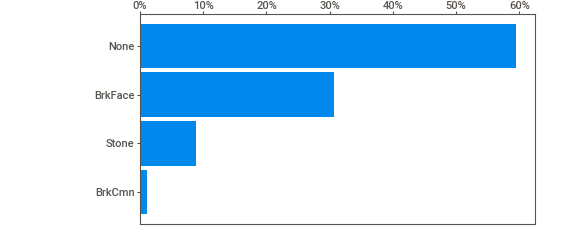
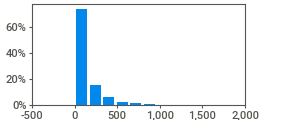
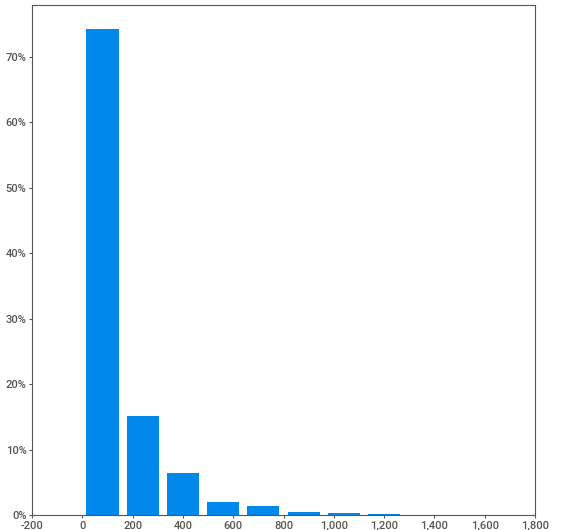
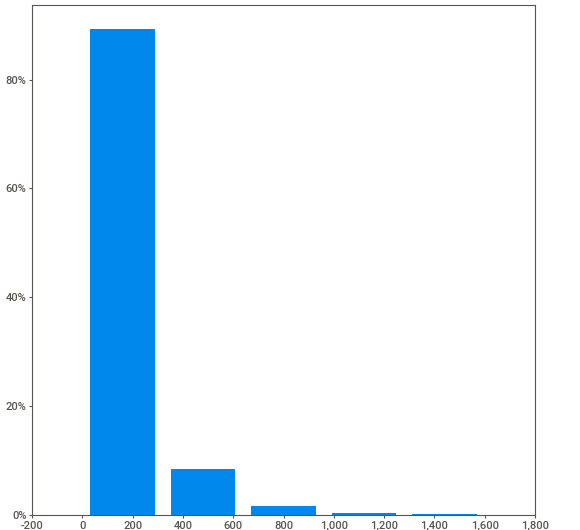
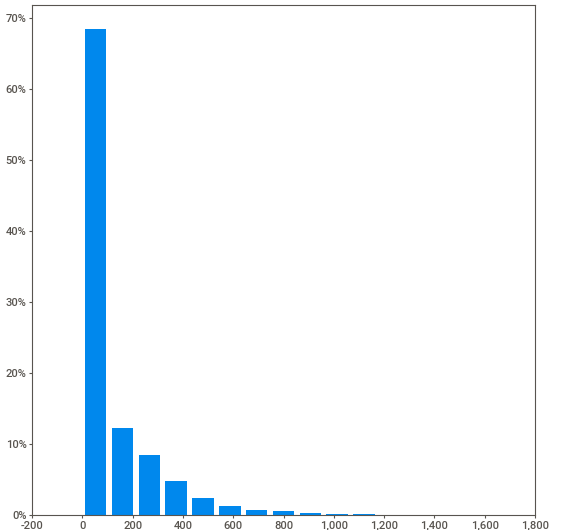
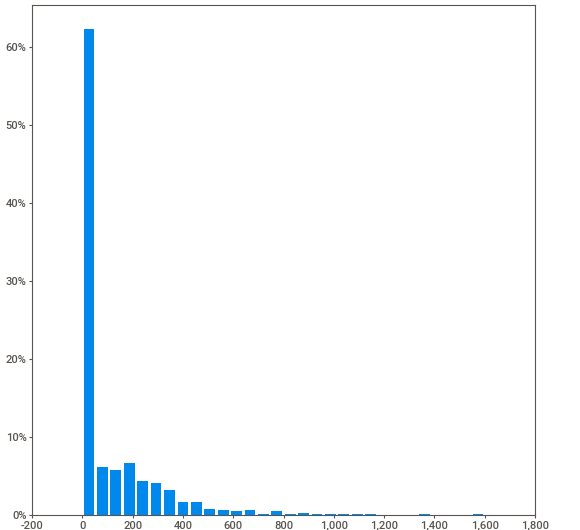
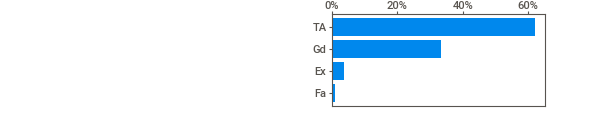
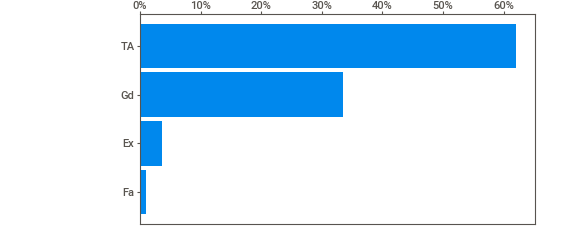
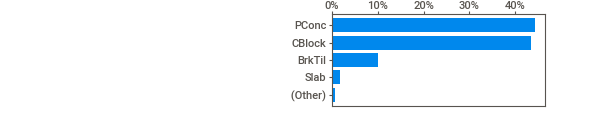
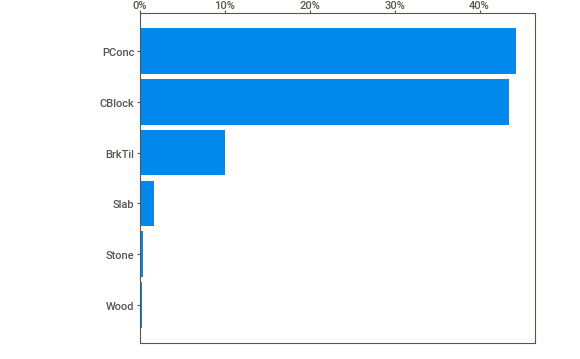
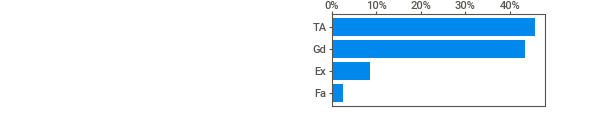
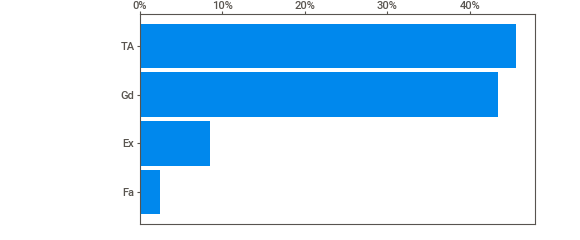
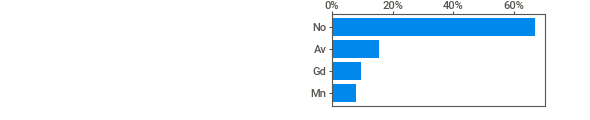
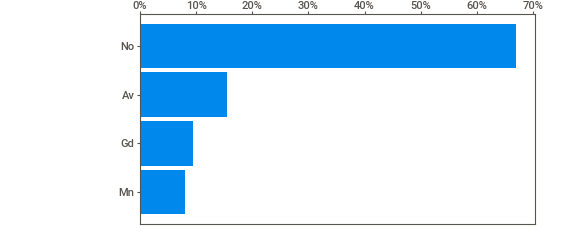
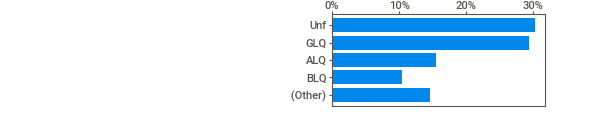
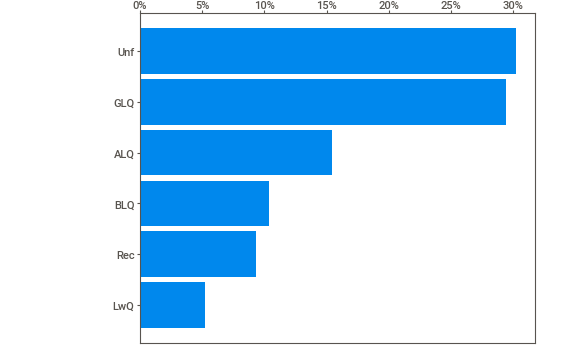
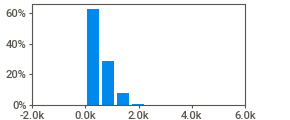
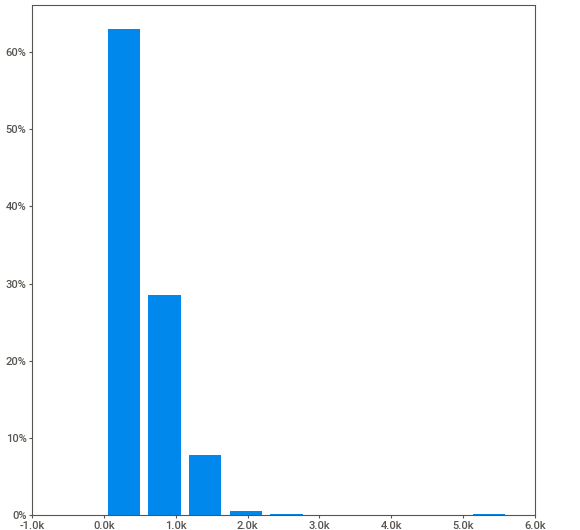
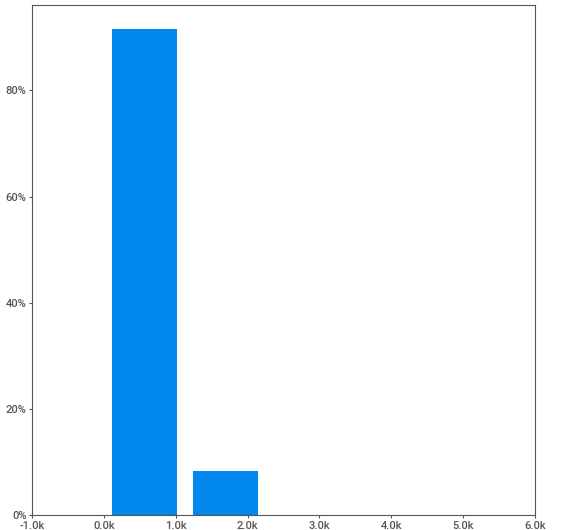
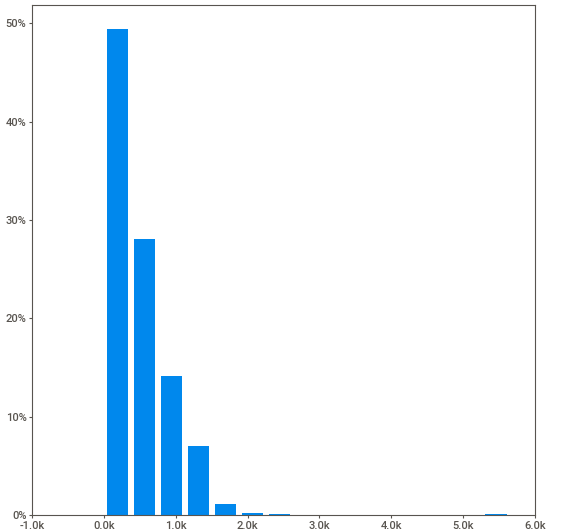
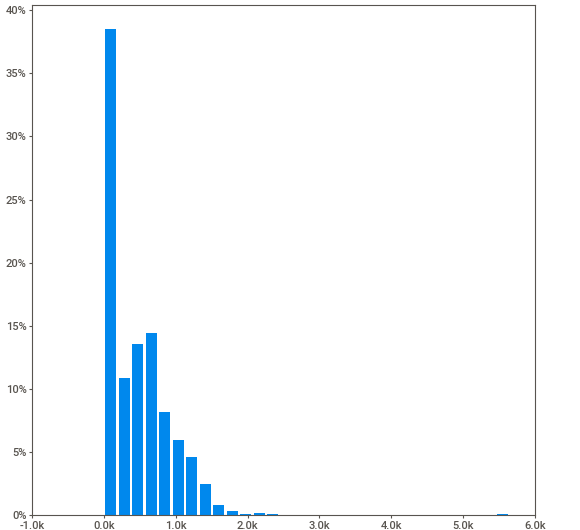
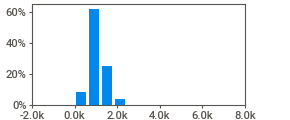
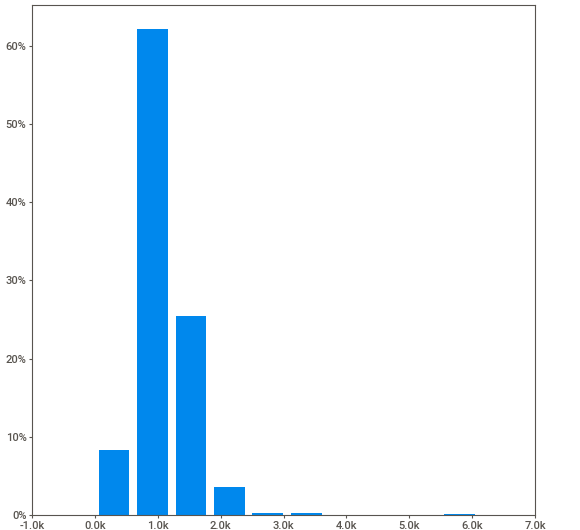
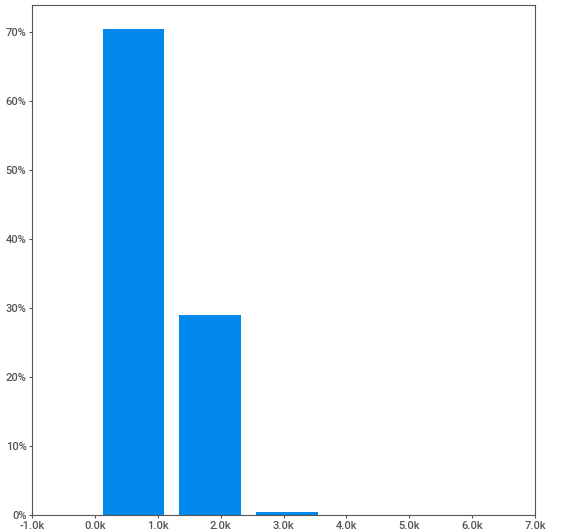
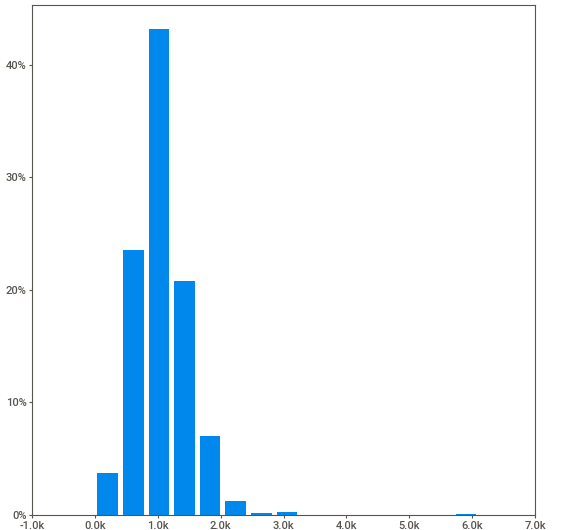
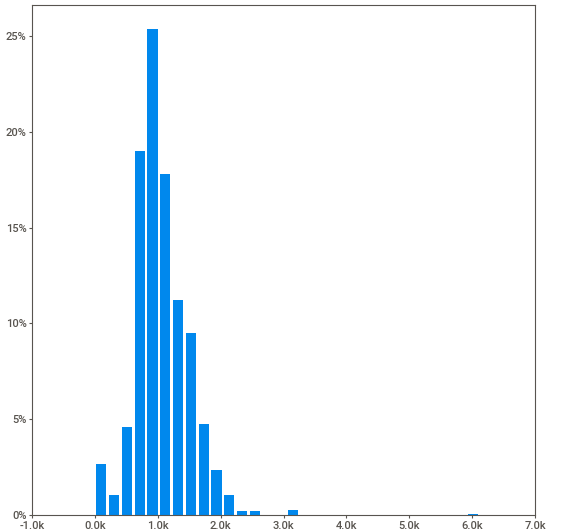
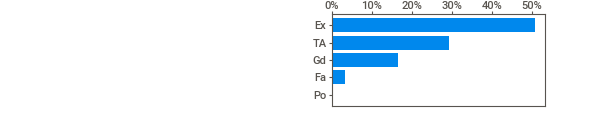
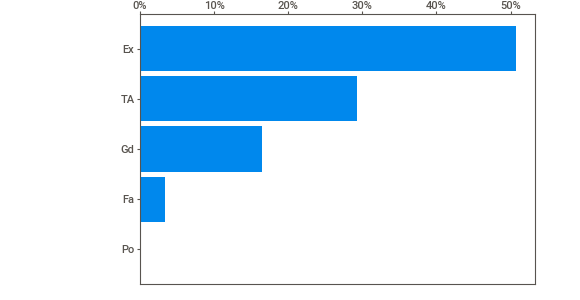
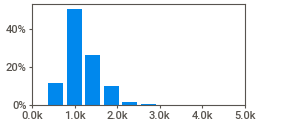
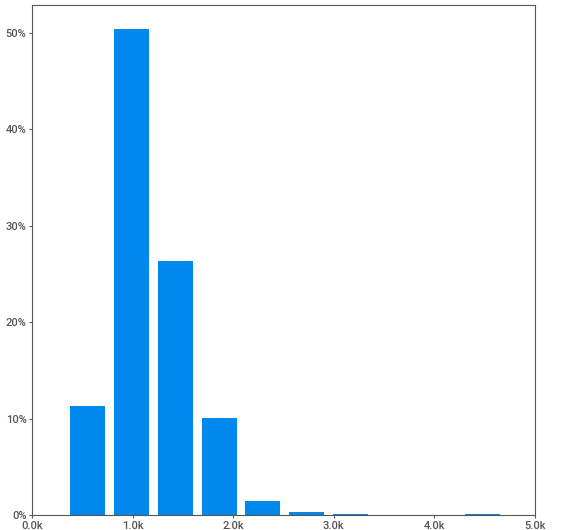
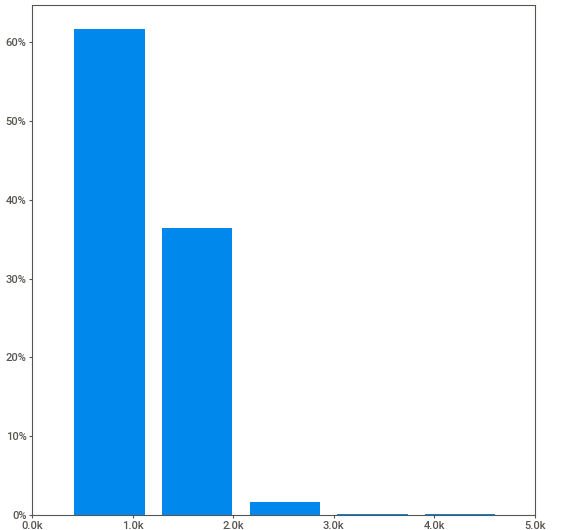
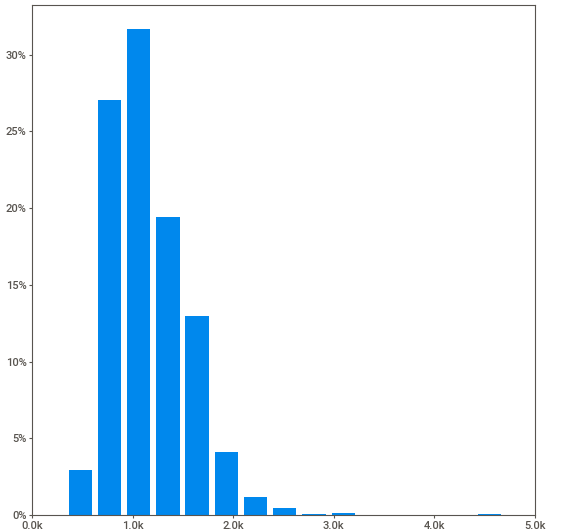
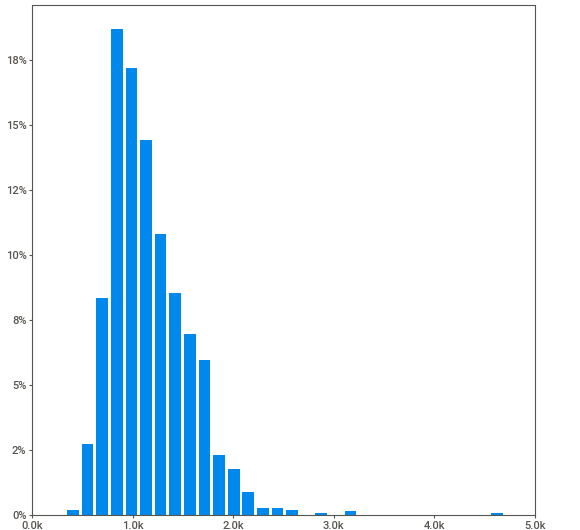
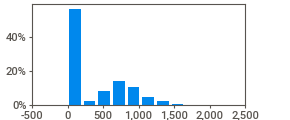
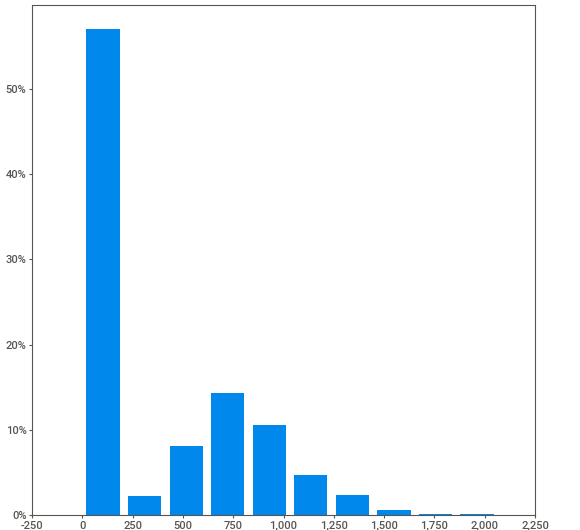
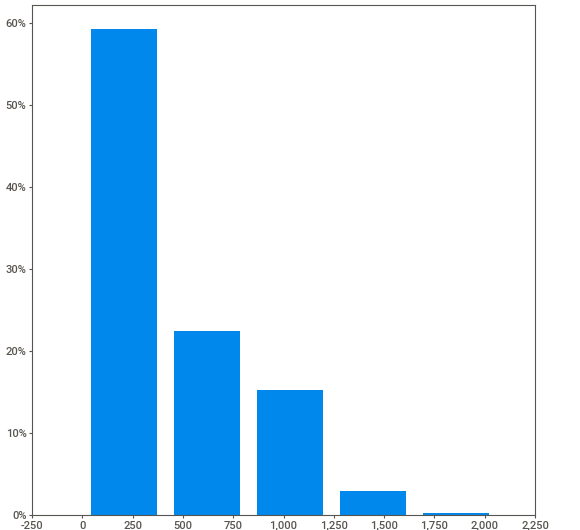
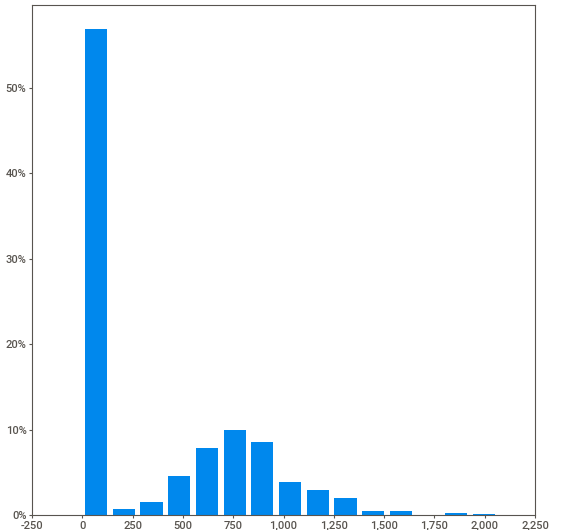
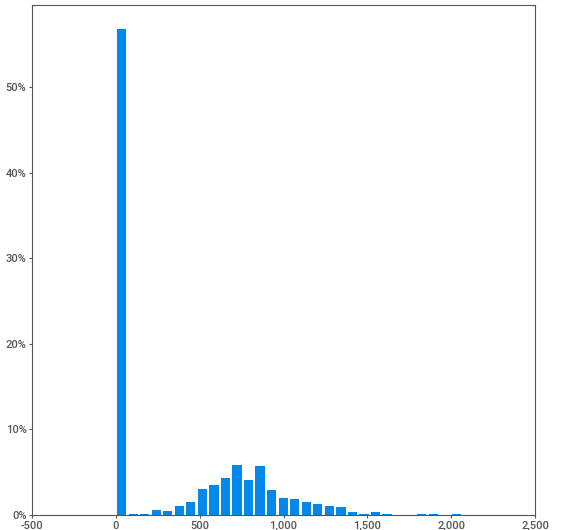
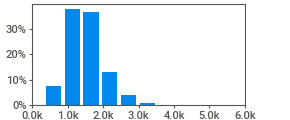
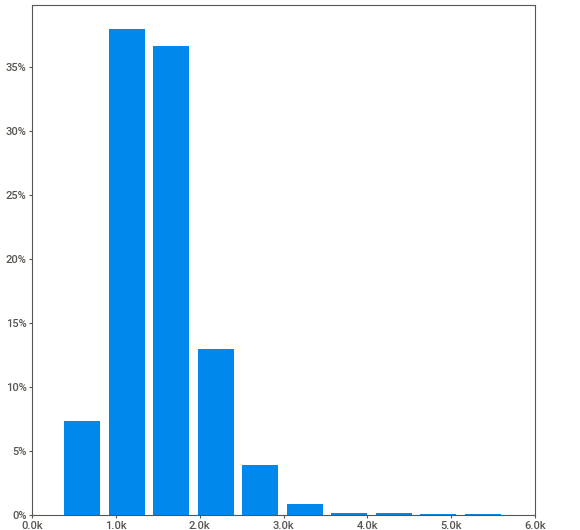
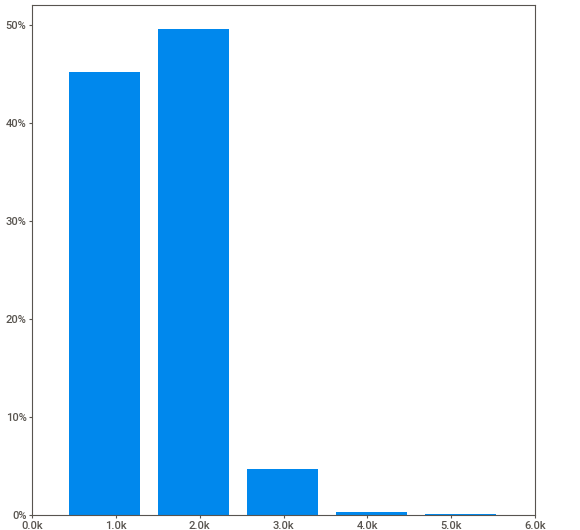
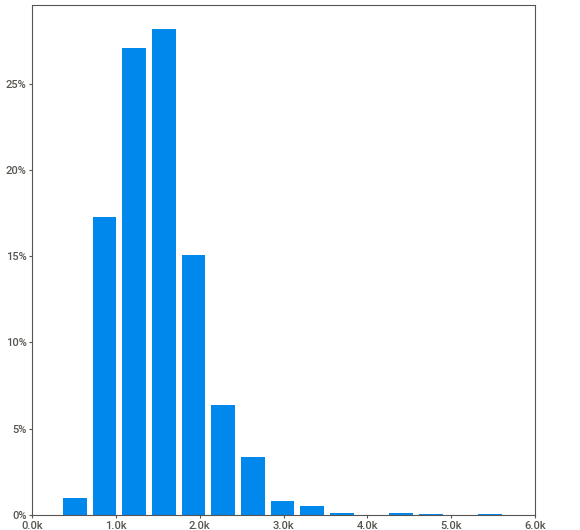
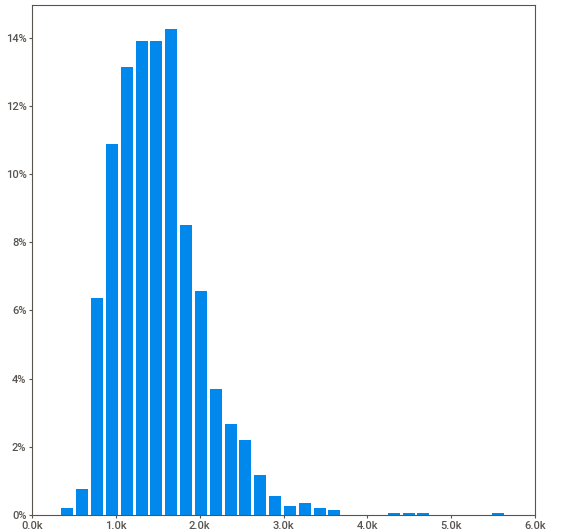
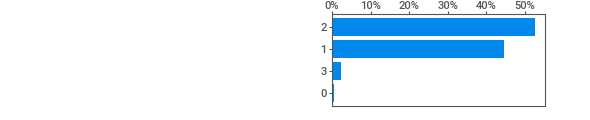
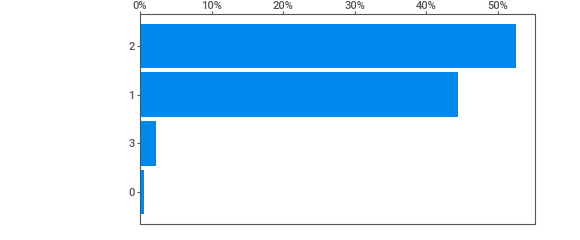
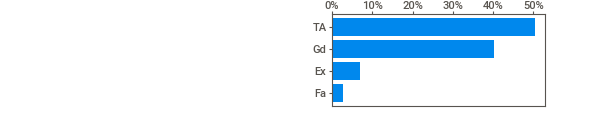
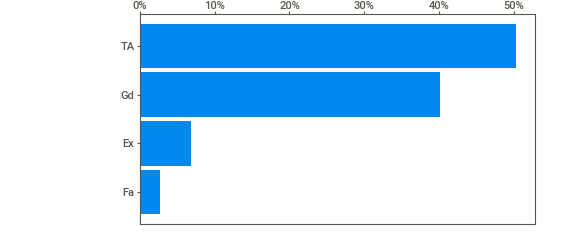
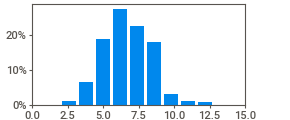
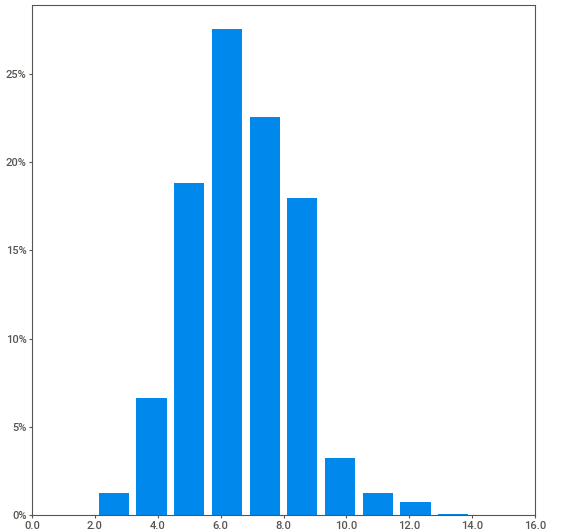
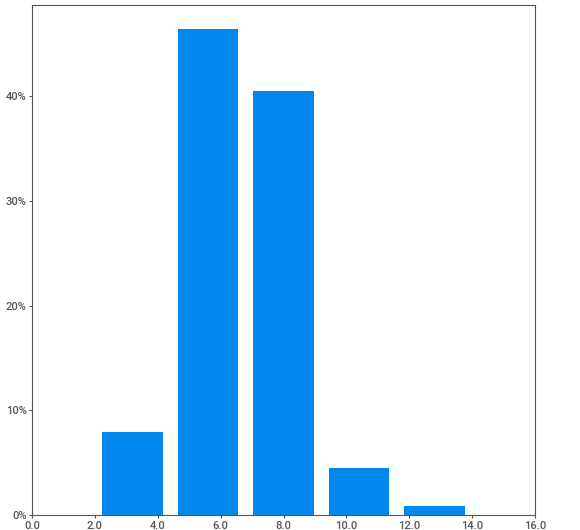
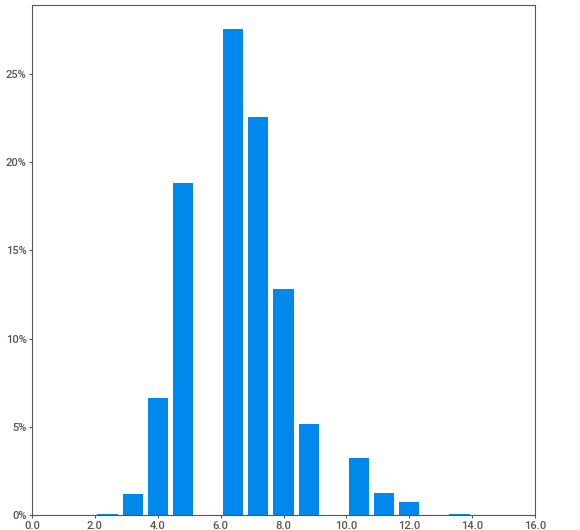
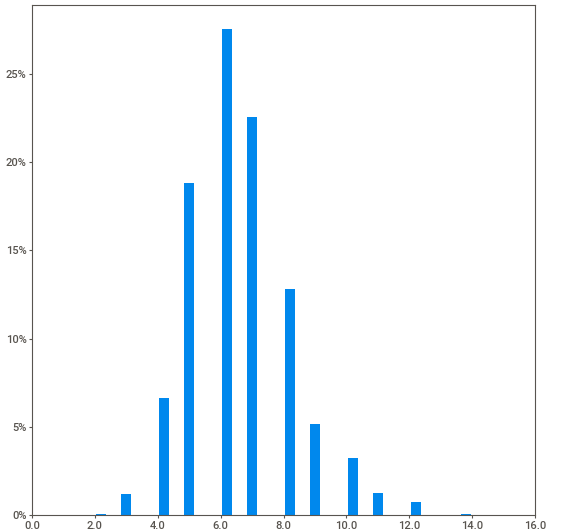
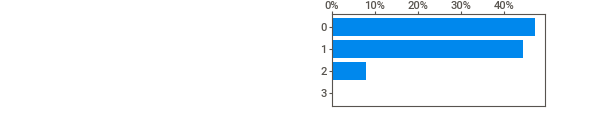
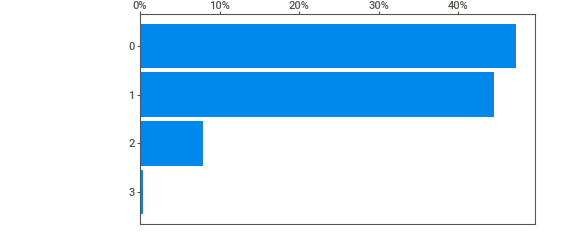
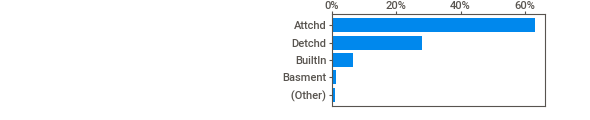
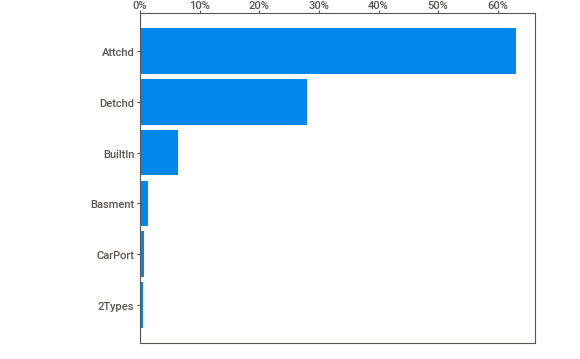
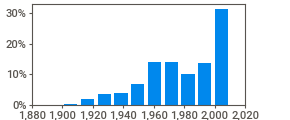
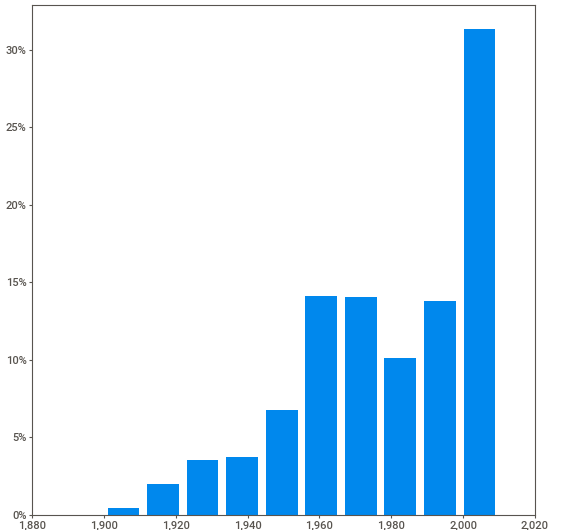
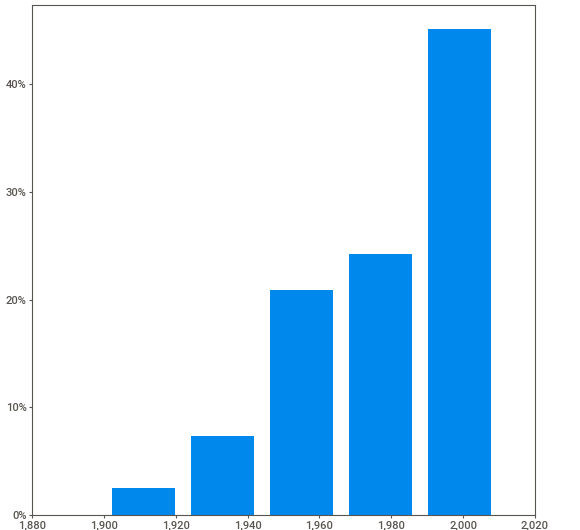
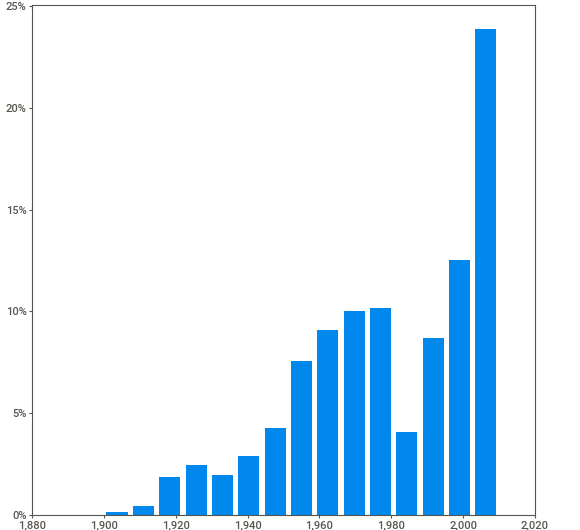
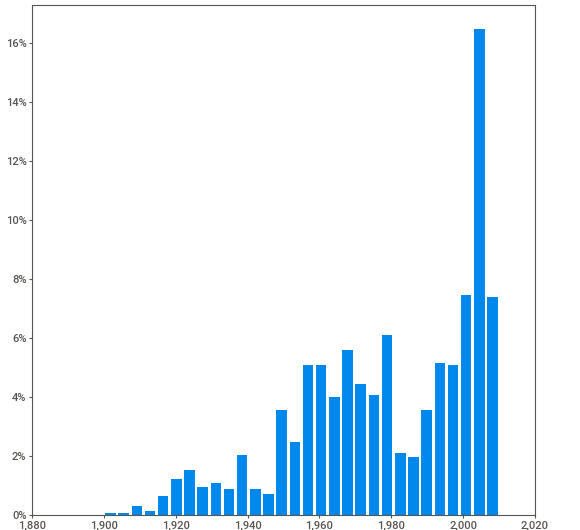
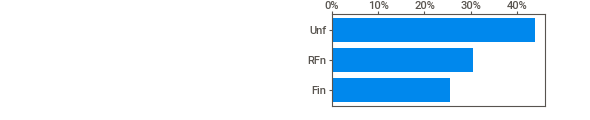
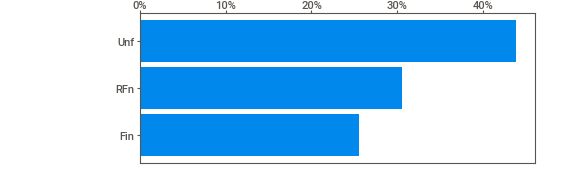
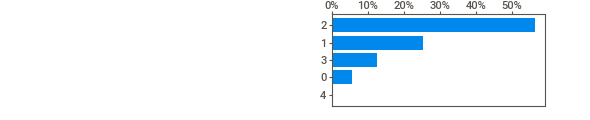
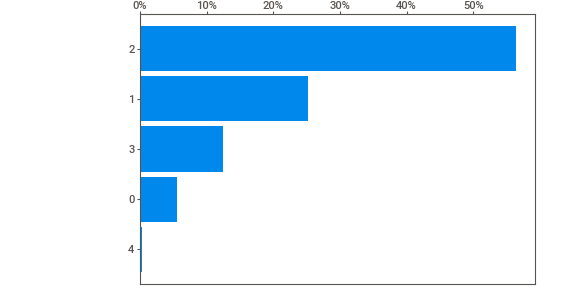
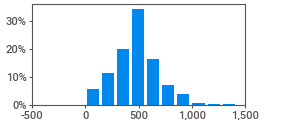
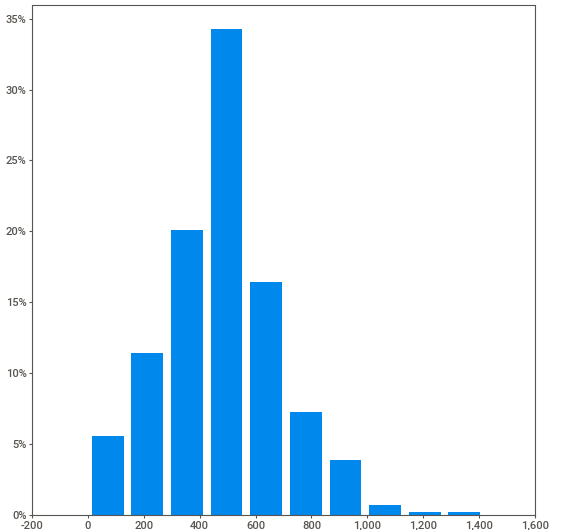
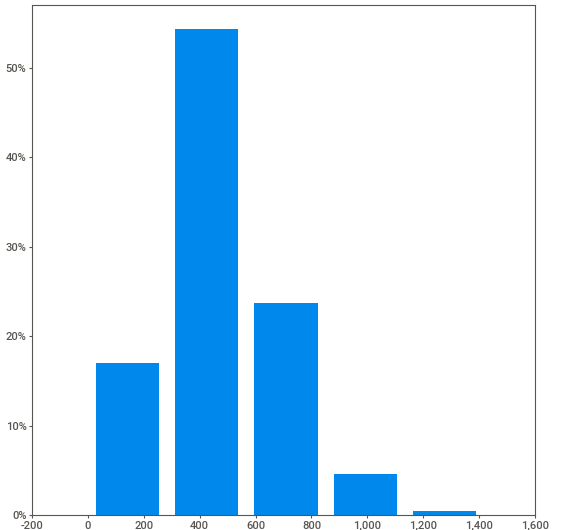
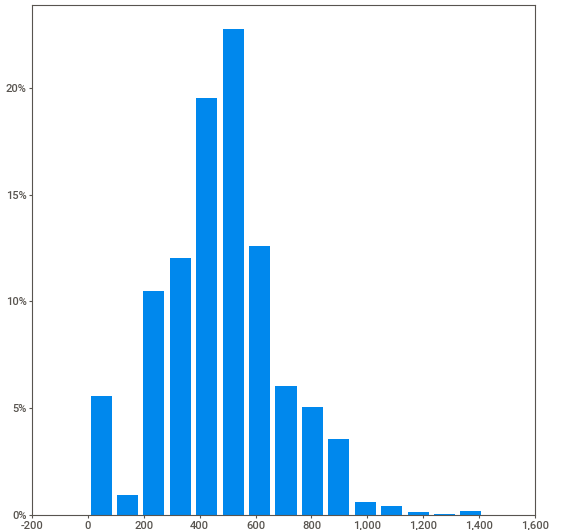
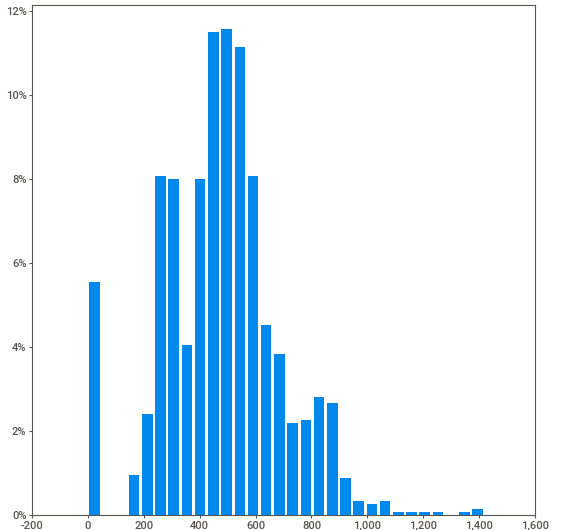
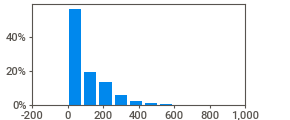
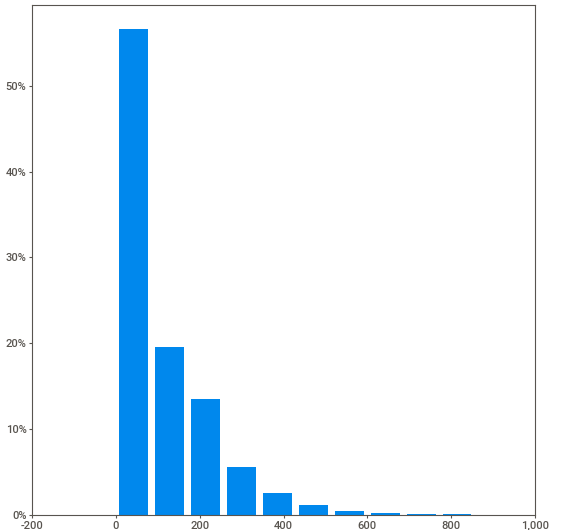
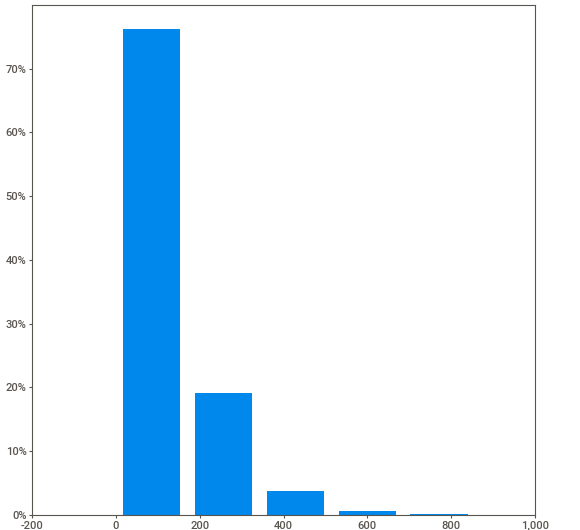
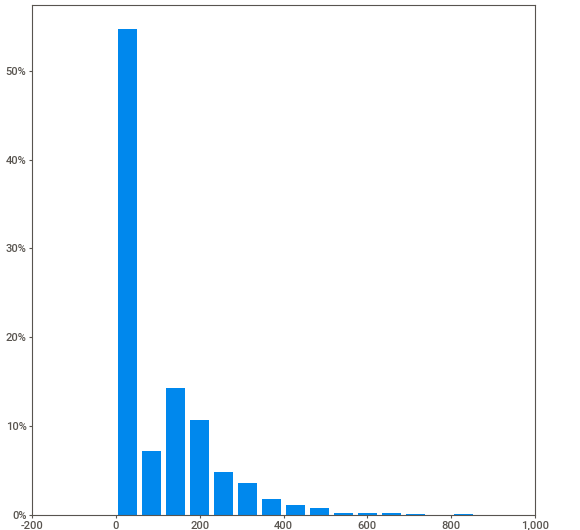
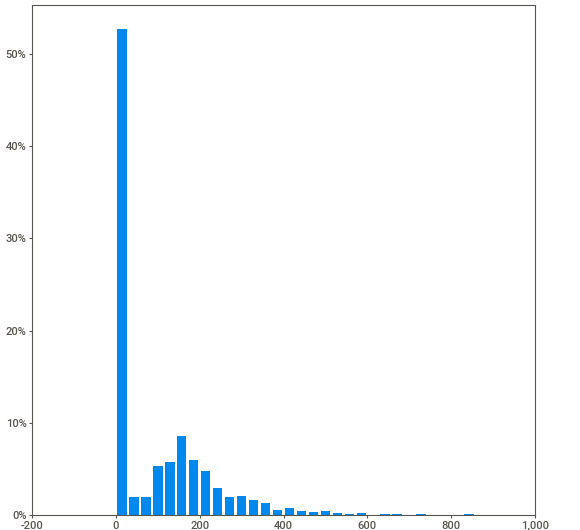
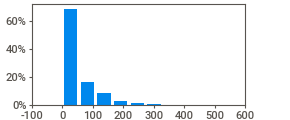
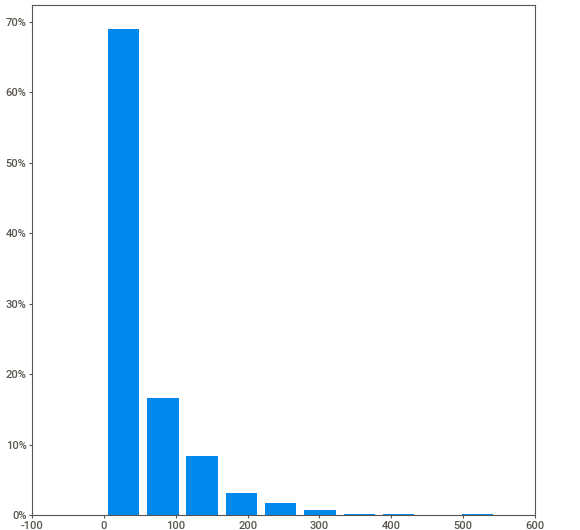
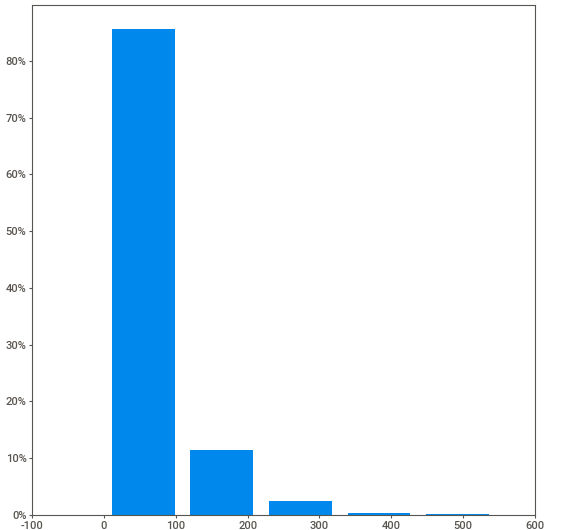
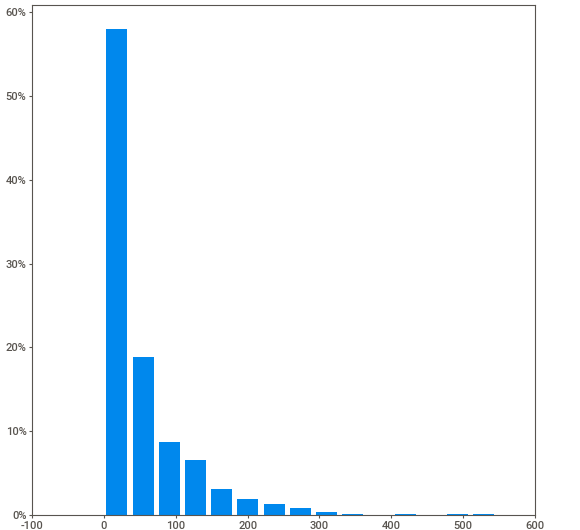
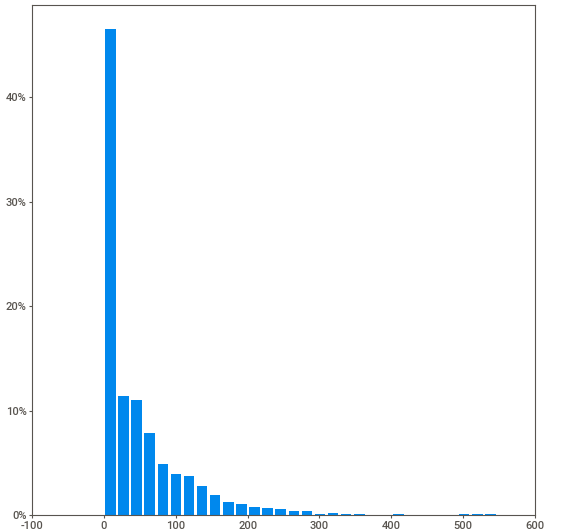
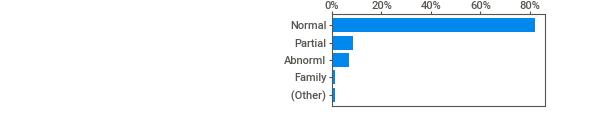
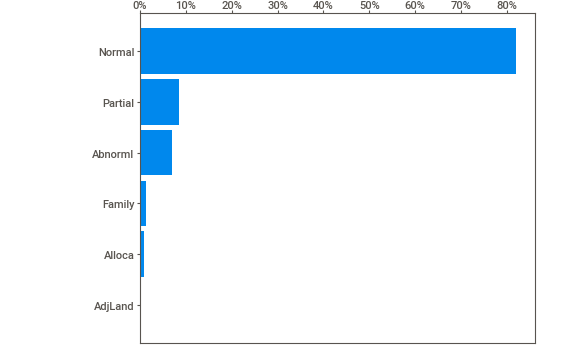
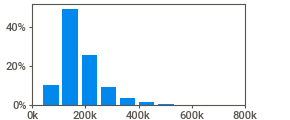
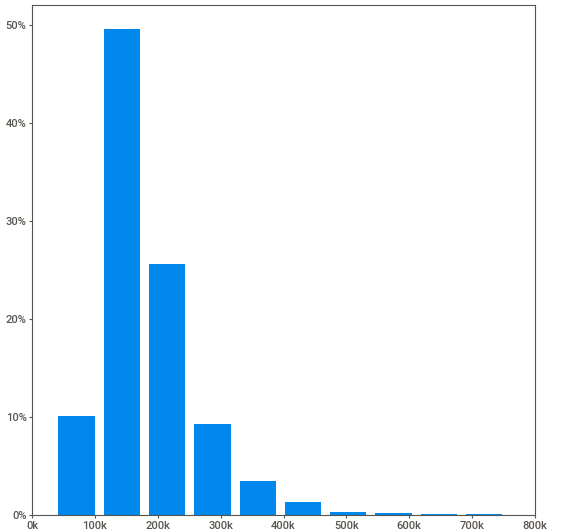
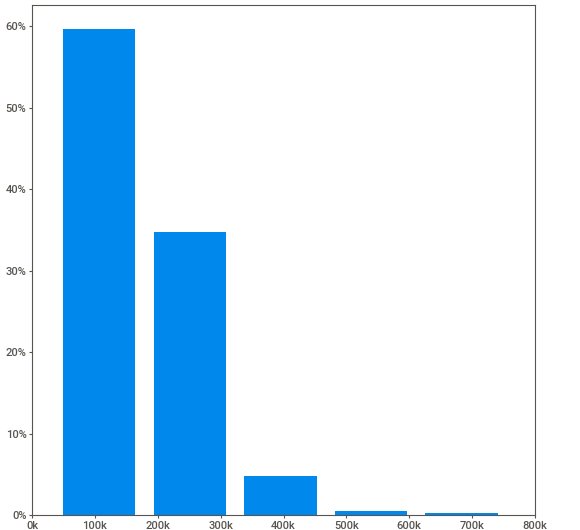
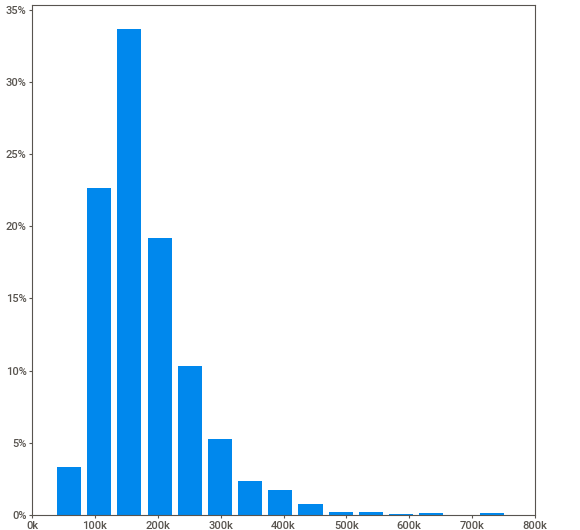
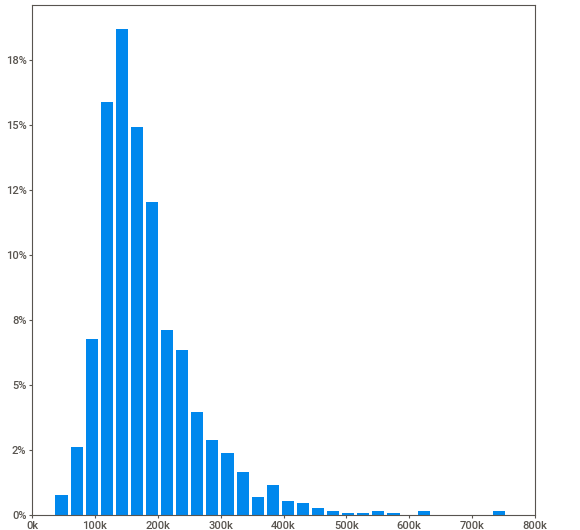
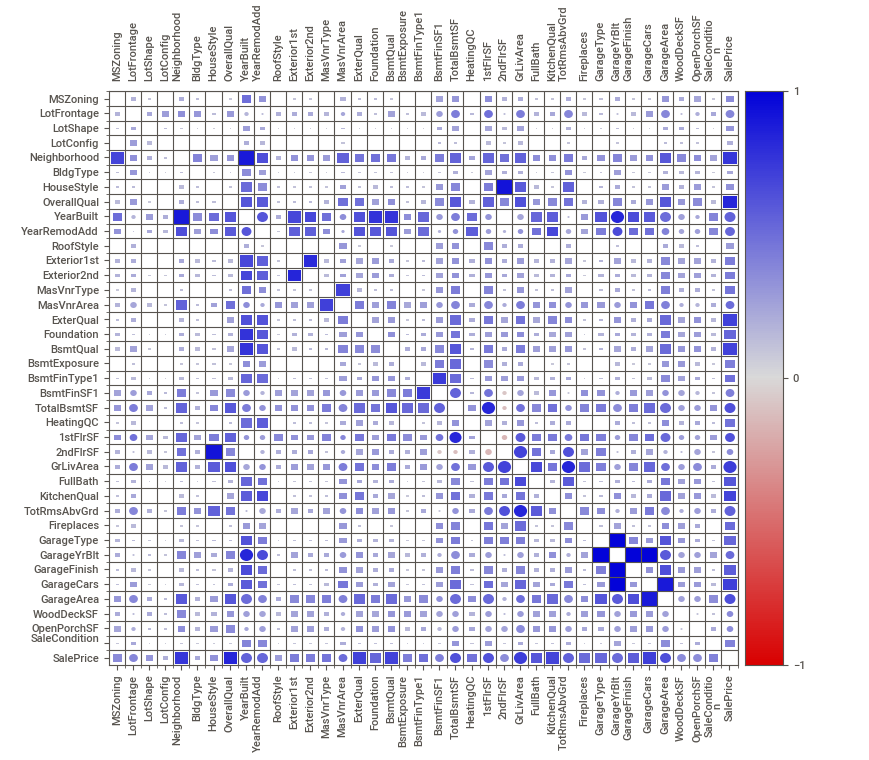
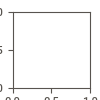

In [ ]:
House_pricing_report2 = sw.analyze(trainCSV)
House_pricing_report2.show_notebook(layout='vertical')

In [ ]:
def count_empty_values_in_each_column(df: pd.DataFrame):
  print('empty values')
  print('------------\n')
  
  for col in df.columns:
    print(f"{col}: {df[col].isna().sum()}")

count_empty_values_in_each_column(trainCSV)

empty values
------------

MSZoning: 0
LotFrontage: 259
LotShape: 0
LotConfig: 0
Neighborhood: 0
BldgType: 0
HouseStyle: 0
OverallQual: 0
YearBuilt: 0
YearRemodAdd: 0
RoofStyle: 0
Exterior1st: 0
Exterior2nd: 0
MasVnrType: 8
MasVnrArea: 8
ExterQual: 0
Foundation: 0
BsmtQual: 37
BsmtExposure: 38
BsmtFinType1: 37
BsmtFinSF1: 0
TotalBsmtSF: 0
HeatingQC: 0
1stFlrSF: 0
2ndFlrSF: 0
GrLivArea: 0
FullBath: 0
KitchenQual: 0
TotRmsAbvGrd: 0
Fireplaces: 0
GarageType: 81
GarageYrBlt: 81
GarageFinish: 81
GarageCars: 0
GarageArea: 0
WoodDeckSF: 0
OpenPorchSF: 0
SaleCondition: 0
SalePrice: 0


Now i will fill the missing values in the features that have missing values.

In [ ]:
# fill empty values in the dataframe
def fill_na_median(df, column_name):
    for c in column_name:
      df_not_null = df[~df[c].isnull()]
      df[c].fillna(df_not_null[c].median(), inplace=True) 

def fill_na_mean(df, column_name):
    for c in column_name:
     df_not_null = df[~df[c].isnull()]
     df[c].fillna(df_not_null[c].mean(), inplace=True) 

def fill_na_random_pick_column_distribution(df, column_name):
    for c in column_name:
      df_not_null = df[~df[c].isnull()]
      df[c] = df[c].apply(lambda x: np.random.choice(df_not_null[c]) if pd.isnull(x) else x)

def translateUniqueNAs(csv, translationsDicts):
  # Translating unique NA values (according to data_descryption.txt)
  for c, translation in translationsDicts.items():
    csv[c].replace({np.nan : translation}, inplace = True)

In [ ]:
numeric_by_mean =['MasVnrArea', 'LotFrontage', 'GarageYrBlt']
catagorial = ['GarageFinish', 'GarageType', 'BsmtFinType1','BsmtExposure', 'BsmtQual', 'MasVnrType']

fill_na_mean(trainCSV, numeric_by_mean)
fill_na_random_pick_column_distribution(trainCSV, catagorial)


Unique_NAs = {"MasVnrType" : "None", "BsmtQual" : "No Basement",
                              "BsmtExposure" : "No Basement", "BsmtFinType1" : "No Basement",
                               "GarageType" : "No Garage", "GarageFinish" : "No Garage",
                              }
translateUniqueNAs(trainCSV, Unique_NAs)

In [ ]:
count_empty_values_in_each_column(trainCSV)

empty values
------------

MSZoning: 0
LotFrontage: 0
LotShape: 0
LotConfig: 0
Neighborhood: 0
BldgType: 0
HouseStyle: 0
OverallQual: 0
YearBuilt: 0
YearRemodAdd: 0
RoofStyle: 0
Exterior1st: 0
Exterior2nd: 0
MasVnrType: 0
MasVnrArea: 0
ExterQual: 0
Foundation: 0
BsmtQual: 0
BsmtExposure: 0
BsmtFinType1: 0
BsmtFinSF1: 0
TotalBsmtSF: 0
HeatingQC: 0
1stFlrSF: 0
2ndFlrSF: 0
GrLivArea: 0
FullBath: 0
KitchenQual: 0
TotRmsAbvGrd: 0
Fireplaces: 0
GarageType: 0
GarageYrBlt: 0
GarageFinish: 0
GarageCars: 0
GarageArea: 0
WoodDeckSF: 0
OpenPorchSF: 0
SaleCondition: 0
SalePrice: 0


# Modle Setup

# Data Split

In [ ]:
# divide the data to features and target
t = trainCSV['SalePrice'].copy()
X = trainCSV.drop(['SalePrice'], axis=1)
logarithmicT = np.log(t)

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
all_cols = categorical_cols.tolist() + numerical_cols.tolist()

ct_enc_std = ColumnTransformer([
            ("encoding", OrdinalEncoder(), categorical_cols),
            ("standard", StandardScaler(), numerical_cols)])

X_encoded = pd.DataFrame(ct_enc_std.fit_transform(X, t), columns=all_cols)


# Feature Selection

Now i will use backwords feature selection in order to decide which features are best to use in our modle.

backwords feature selection start from a full set of features and drop features intl it reaches the best score.

In [ ]:
# find best subset of features on this dataset
def backwordsSelection(x, t, splits =3):
  selector = RFECV(SGDRegressor(random_state=1), cv=RepeatedKFold(n_splits= splits, n_repeats=10, random_state=1)).fit(x, t)
  return x.loc[:, selector.support_]

best_csv = backwordsSelection(X_encoded, t, 5)
best_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   float64
 1   BldgType       1460 non-null   float64
 2   RoofStyle      1460 non-null   float64
 3   MasVnrType     1460 non-null   float64
 4   Foundation     1460 non-null   float64
 5   SaleCondition  1460 non-null   float64
 6   OverallQual    1460 non-null   float64
 7   YearBuilt      1460 non-null   float64
 8   YearRemodAdd   1460 non-null   float64
 9   MasVnrArea     1460 non-null   float64
 10  BsmtFinSF1     1460 non-null   float64
 11  1stFlrSF       1460 non-null   float64
 12  2ndFlrSF       1460 non-null   float64
 13  GrLivArea      1460 non-null   float64
 14  Fireplaces     1460 non-null   float64
 15  GarageCars     1460 non-null   float64
dtypes: float64(16)
memory usage: 182.6 KB


# Hyper-Parameters Search
Let's implement regularization by finding out the best combination of penalty and alpha, out of the next possible options:

  1. Penlaty (Regularization methods): l1 (Ridge), l2 (Lasso), elasticnet
  2. Alpha (Regularization constant): 0.0001, 0.001, 0.01, 0.1
  3. Eta0 (Learning rate constant): 0.0001, 0.001, 0.01, 0.1

i will do that by using GridSearch.

In [ ]:
# train with grid search and get best parameters
def getOptimalHyperParameters(x, t):
  hyperParams = {"penalty": ["l2", "l1", "elasticnet"], "alpha": [0.0001, 0.001, 0.01, 0.1], "eta0": [0.0001, 0.001, 0.01, 0.1]}
  gridSearch = GridSearchCV(SGDRegressor(random_state = 1), hyperParams).fit(x, t)

  return gridSearch.best_params_["penalty"], gridSearch.best_params_["alpha"], gridSearch.best_params_["eta0"]

# Setting up linear regression model
bestPenalty, bestAlpha, bestEta0 = getOptimalHyperParameters(X_encoded, logarithmicT)
print("Best hyper-parameters:")
print(f"\teta0: {bestEta0}\n\tpenalty: {bestPenalty}\n\talpha: {bestAlpha}")

model = SGDRegressor(penalty = bestPenalty, alpha = bestAlpha, learning_rate = "constant", eta0 = bestEta0, random_state = 1)

Best hyper-parameters:
	eta0: 0.01
	penalty: l1
	alpha: 0.1


In [ ]:
# Required methods:
def find_generator_len(generator, useProgressBar = True):
    i = 0
    
    if useProgressBar:
        pbar = tqdm(desc = "Calculating Length", ncols = 1000, bar_format = "{desc}{bar:10}{r_bar}")
    for a in generator:
        i += 1
        if useProgressBar:
            pbar.update()

    if useProgressBar:
        pbar.close()

    return i

def get_cv_score_and_loss(x, t, model, columnTransformer = None, k = None, p = None, showGraphs = False, showProgressBar = True):
    resultsDF = pd.DataFrame(columns = ["Fold ID", "Split", "Score", "Loss"])
    cvMethod = ""

    if k is not None:
      cvMethod = "K-Fold"
      cv = KFold(n_splits = k, shuffle = True, random_state = 1)
    elif p is not None:
      cvMethod = f"Leave-{p}-Out"
      cv = LeavePOut(p)
    else:
        raise ValueError("Choose k (for K-Fold) or p (for Leave-P-Out)")

    if showProgressBar:
        pbar = tqdm(desc = "Computing Models", total = find_generator_len(cv.split(x)))

    for i, (trainIDs, validationIDs) in enumerate(cv.split(x)):
        xTrain = x.loc[trainIDs]
        tTrain = t.loc[trainIDs]
        xValidation = x.loc[validationIDs]
        tValidation = t.loc[validationIDs]

        model.fit(xTrain, tTrain)

        yTrain = model.predict(xTrain)
        yValidation = model.predict(xValidation)
        resultsDF.loc[len(resultsDF)] = [i, "train", model.score(xTrain, tTrain),
                                         mean_squared_error(tTrain, yTrain)]
        resultsDF.loc[len(resultsDF)] = [i, "validation", model.score(xValidation, tValidation),
                                         mean_squared_error(tValidation, yValidation)]

        if showProgressBar:
            pbar.update()

    if showProgressBar:
        pbar.close()

    val_resultsDF = resultsDF[resultsDF["Split"] == "validation"]
    train_resultsDF = resultsDF[resultsDF["Split"] == "train"]

    validationScoreMean = val_resultsDF["Score"].mean()
    validationLossMean = val_resultsDF["Loss"].mean()
    trainScoreMean = train_resultsDF["Score"].mean()
    trainLossMean = train_resultsDF["Loss"].mean()

    if showGraphs:
      scoreTitle = f"{k if k is not None else p} {cvMethod} (Score):<br />Mean Validation Score: {validationScoreMean:.2f}<br />Mean Train Score: {trainScoreMean:.2f}"
      lossTitle = f"{k if k is not None else p} {cvMethod} (Loss):<br />Mean Validation Loss: {validationLossMean:.2f}<br />Mean Train Loss: {trainLossMean:.2f}"

      scoreFig = px.line(resultsDF, x = "Fold ID", y = "Score", color = "Split", title = scoreTitle)
      scoreFig.show()

      lossFig = px.line(resultsDF, x = "Fold ID", y = "Loss", color = "Split", title = lossTitle)
      lossFig.show()

    return validationScoreMean, validationLossMean, trainScoreMean, trainLossMean

validationScore, validationLoss, trainScore, trainLoss = get_cv_score_and_loss(best_csv, logarithmicT, model, k = 10, showGraphs = True)
validationScore, validationLoss, trainScore, trainLoss = get_cv_score_and_loss(best_csv, logarithmicT, model, k = 15, showGraphs = True)
validationScore, validationLoss, trainScore, trainLoss = get_cv_score_and_loss(best_csv, logarithmicT, model, k = 20, showGraphs = True)


Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/15 [00:00<?, ?it/s]

Calculating Length          | 0/? [00:00<?, ?it/s]

Computing Models:   0%|          | 0/20 [00:00<?, ?it/s]

# Cross Validation Conclusions:
It appears that the modle has the highest score with both on validation and train when we do 15-fold CV

# Submission

In [ ]:
# Reading and repairing test data
xTest = testCSV[best_csv.columns]
xTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1455 non-null   object 
 1   BldgType       1459 non-null   object 
 2   RoofStyle      1459 non-null   object 
 3   MasVnrType     1443 non-null   object 
 4   Foundation     1459 non-null   object 
 5   SaleCondition  1459 non-null   object 
 6   OverallQual    1459 non-null   int64  
 7   YearBuilt      1459 non-null   int64  
 8   YearRemodAdd   1459 non-null   int64  
 9   MasVnrArea     1444 non-null   float64
 10  BsmtFinSF1     1458 non-null   float64
 11  1stFlrSF       1459 non-null   int64  
 12  2ndFlrSF       1459 non-null   int64  
 13  GrLivArea      1459 non-null   int64  
 14  Fireplaces     1459 non-null   int64  
 15  GarageCars     1458 non-null   float64
dtypes: float64(3), int64(7), object(6)
memory usage: 182.5+ KB


In [ ]:
translateUniqueNAs(xTest, {"MasVnrType" : "None"})

numericalsByMean_t = ["MasVnrArea", "BsmtFinSF1"]
categoricals_t = ["MSZoning", "MasVnrType", "GarageCars"]
fill_na_mean(xTest, numericalsByMean_t)
fill_na_random_pick_column_distribution(xTest, categoricals_t)


# Setting up the final model
numericals = xTest.select_dtypes(include = ["int64", "float64"]).columns
categoricals = xTest.select_dtypes(include = ["object", "bool"]).columns
allCols = numericals.tolist() + categoricals.tolist()
columnTransformer = ColumnTransformer([
    ("encoding", OrdinalEncoder(), categoricals),
    ("standard", StandardScaler(), numericals)])

xTestEncoded = pd.DataFrame(columnTransformer.fit_transform(xTest, t), columns = allCols)
yTest = model.predict(xTestEncoded)

# Creating a submission file for the competition
submission = pd.read_csv("/content/sample_submission.csv")
submission["SalePrice"] = np.exp(yTest.astype(float))
submission.to_csv("submission.csv", index = False)
submission.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/skle

Id      SalePrice
0  1461  131277.577610
1  1462  158738.832317
2  1463  150861.443979
3  1464  171044.631053
4  1465  211564.987073

# Best Submission

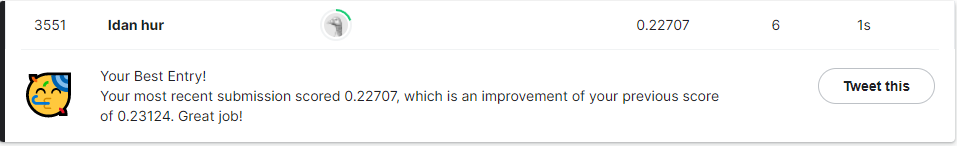

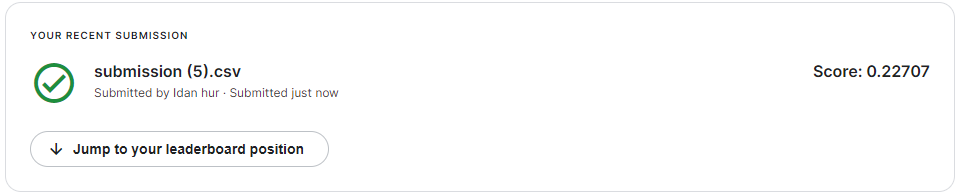

# Some of the other submission

1. Same as the best result but drop weak correlation to salePrice that are lower then 0.25 (insted of 0.3)

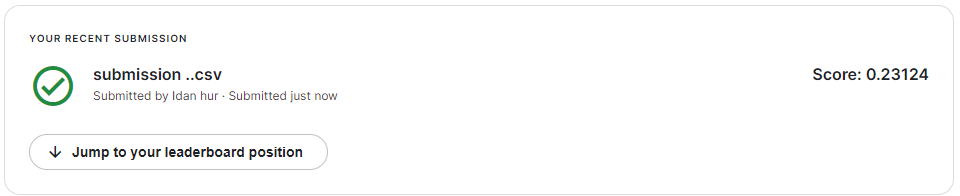

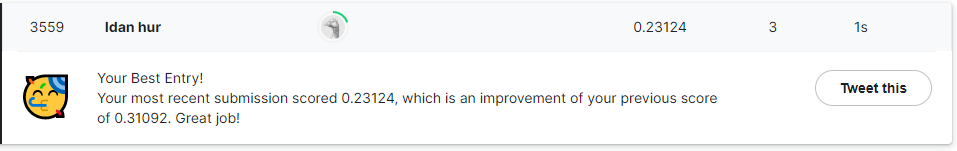

2. 
elasticnet Regularization

  and drop Distinct On Threshold was 0.9 (instead of 0.85 in best result)

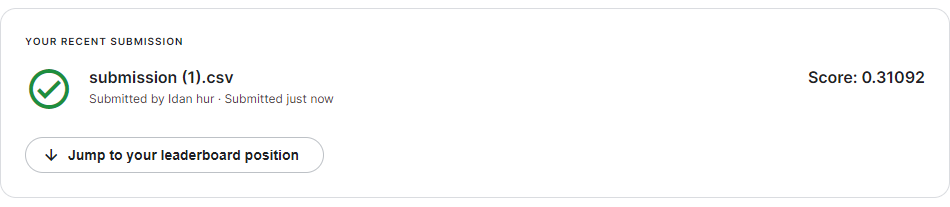

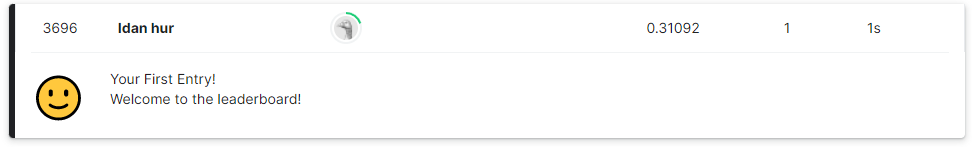

3. Same as the above (2) but drop weak correlation to salePrice that are lower then 0.25 (insted of 0.3)

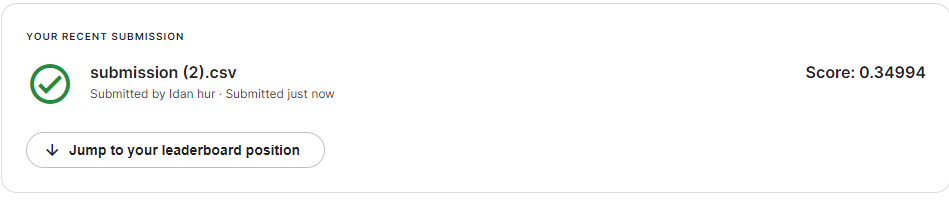

# Contest Summary
In this contest, I attempted to predict the prices of houses in Ames, Iowa. First, I got a visual display about the data in order to obtain details about missing values and correlations. After filling missing values and dropping expendable ones, I headed for the linear regression.

In the linear regression, I have used backwords feature selection to find the best features for this modle, activated Lasso Regularization and i have tested Cross Validation using K-Fold.

# references

  1. Sixth Practic ML notebook.
  2. Seventh Practice ML notebook.
  3. "Comprehensive data exploration with Python"- https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python